In [39]:
%load_ext autoreload
%autoreload 2
import os
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

from IPython.display import display
from particle import Particle
from rich import print
from scipy.special import gamma, erf
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp

from python.analysis import Master, Tags, Plots, cross_section

cross_section.SetPlotStyle()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# photon_file = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5"
# path = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/"

photon_file = "work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5"
path = "work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/"

df = pd.read_hdf(photon_file, "all_photons")
df["residual"] = df.reco_energy - df.true_energy
df["fractional_error"] = (df.reco_energy / df.true_energy) - 1
display(df)

save = False

if save is True:
    os.makedirs(path, exist_ok = True)

energy_range = (0, 1000)

reco_direction_x  reco_direction_y  reco_direction_z  true_direction_x  \
0              0.153913         -0.448695         -0.880332         -0.590795   
1             -0.661064          0.554671          0.505306         -0.424197   
2             -0.756088         -0.197167          0.624064         -0.701329   
3              0.249457          0.964629         -0.085210          0.193200   
4              0.155380          0.688973          0.707936          0.183152   
...                 ...               ...               ...               ...   
14761          0.011373          0.877751         -0.478983         -0.242268   
14762          0.111836         -0.140698          0.983716          0.008246   
14763          0.798531         -0.549687         -0.245342          0.835164   
14764         -0.624715         -0.701066          0.343858         -0.573940   
14765         -0.407494         -0.858595          0.311069         -0.360029   

       true_direction_y  true_direction_z  reco_startPos_x  reco_startPos_y  \
0             -0.028973          0.806301       -50.365143       407.080963   
1              0.145338          0.893831       -52.183834       411.270294   
2             -0.252144          0.666754       -49.407921       397.549896   
3              0.955984         -0.220834       -30.018709       461.599670   
4              0.116182          0.976195       -31.313984       416.477051   
...                 ...               ...              ...              ...   
14761         -0.775464          0.583062       -30.672031       416.636017   
14762          0.171117          0.985216       -71.344170       391.051880   
14763         -0.448058         -0.318976       -30.283005       407.297180   
14764         -0.774929          0.264721       -52.868820       399.063965   
14765         -0.765802          0.532848       -41.411198       401.060211   

       reco_startPos_z  true_startPos_x  true_startPos_y  true_startPos_z  \
0            98.167183       -43.642639       409.478907        67.878673   
1           106.403603       -45.169688       407.694394        72.551267   
2            84.161270       -42.295898       404.087491        59.877333   
3            65.955612       -43.965285       411.077788        62.175379   
4            35.445240       -33.800738       423.967888         7.582305   
...                ...              ...              ...              ...   
14761        50.672253       -31.746023       422.094157        24.018496   
14762       198.263290       -75.805059       387.943631       188.370734   
14763        62.054501       -25.913990       401.994875        39.414249   
14764        89.358643       -53.834842       407.246819        76.644387   
14765        43.301857       -37.473848       416.094869         9.617913   

       reco_showerLength  reco_nHits  reco_nHits_collection  reco_energy  \
0              21.146486         158                     52   135.342080   
1              17.180847          99                     28    40.070160   
2              27.705936         100                     31    52.691198   
3              54.935959         206                     50   187.161927   
4              26.456600         114                     38   107.040398   
...                  ...         ...                    ...          ...   
14761          20.341240          91                     30    78.233705   
14762          64.349915         747                    240   406.900812   
14763          25.282101         105                     27   132.396717   
14764          94.351921         439                     78   220.963373   
14765          20.369026          96                     31   107.666818   

       true_energy  true_mother    residual  fractional_error  
0       408.449428          111 -273.107348         -0.668644  
1       120.089489          111  -80.019329         -0.666331  
2        99.584041          111  -46.892842         -0.

# Selection

{'pi0_daughter': 13240, 'other': 1526}

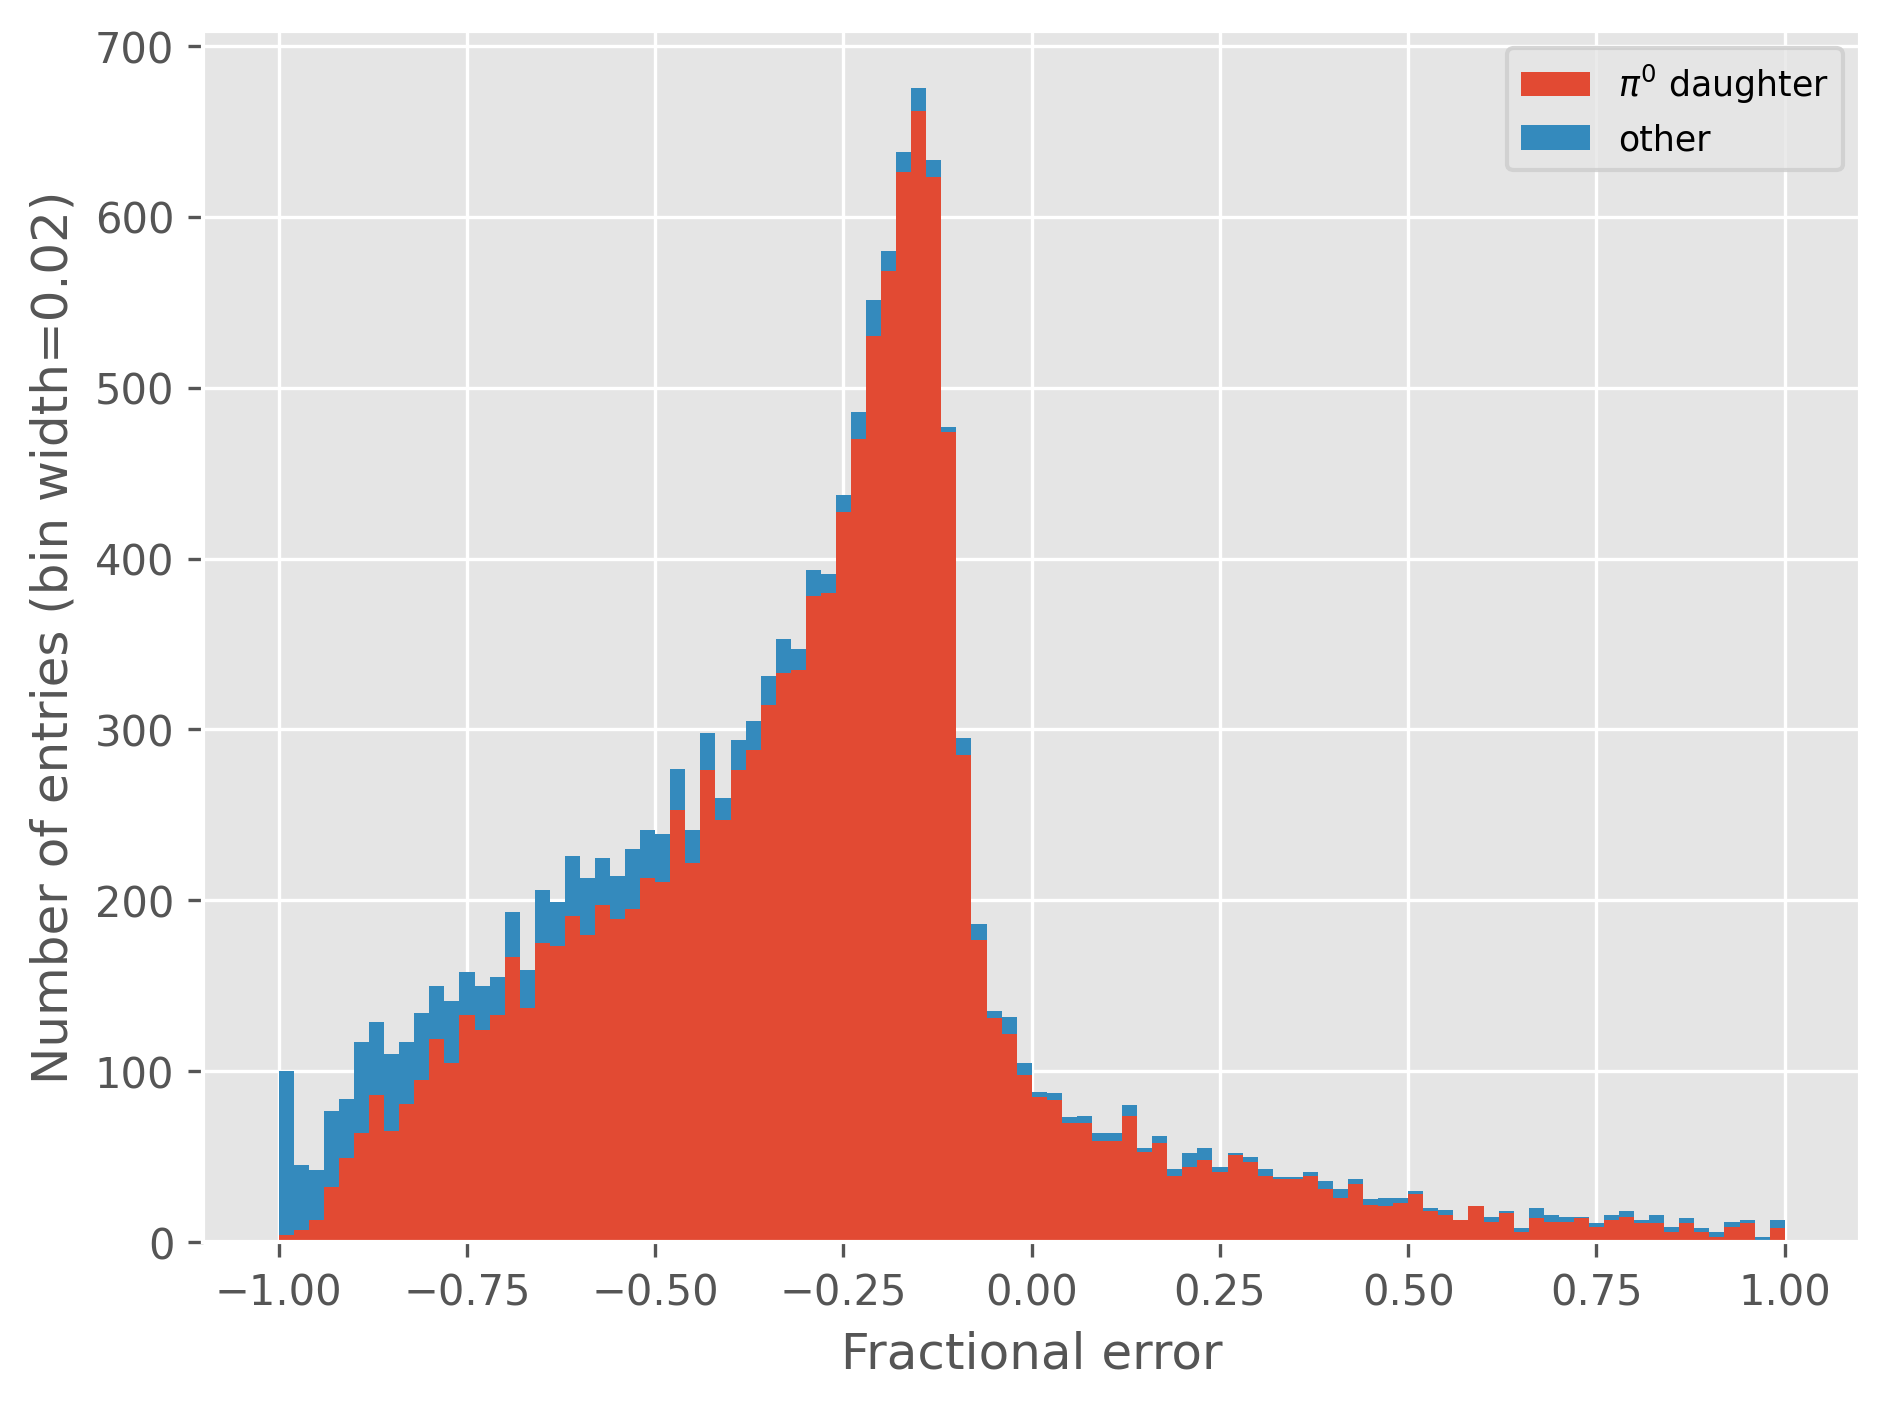

In [10]:
pi0_mother = df.true_mother == 111
counts = {"pi0_daughter" : len(pi0_mother[pi0_mother]), "other" : len(pi0_mother) - len(pi0_mother[pi0_mother])}
print(counts)

Plots.PlotHist([df[pi0_mother].fractional_error, df[~pi0_mother].fractional_error], stacked = True, range = [-1, 1], xlabel = "Fractional error", label = ["$\pi^{0}$ daughter", "other"])
if save is True: Plots.Save("fraction_error_stacked", path)

df = df[pi0_mother]

# Linear Correction

In [12]:
def LinearFit(x, m):
    return m * x

def binned_dataframe(bins : list) -> list:
    """ split a dataframe into a list of dataframes based on reco energy bins

    Args:
        bins (list): bin edges

    Returns:
        list: list of binned data frames
    """
    binned_data = []
    for i in range(1, len(bins)):
        data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
        binned_data.append(data[data.true_energy < max(energy_range)])
    return binned_data


def linear_fit(bins : list) -> float:
    """ perform linear fit of true energy vs reco energy, equivalent to the correction done in the microboone simulation paper.

    Args:
        bins (list): reco energy bins

    Returns:
        float: gradient of linear fit (correction)
    """
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array([d.true_energy.mean() for d in binned_dataframe(bins)])

    popt, pcov = curve_fit(LinearFit, x, y)

    print(popt, pcov**0.5)
    perr = np.array([pcov[i][i] for i in range(len(popt))])**0.5

    Plots.Plot(x, y, marker = "x", linestyle = "")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit")
    plt.fill_between(x, LinearFit(x, *(popt + perr)), LinearFit(x, *(popt - perr)), color = "C3", alpha = 0.5)
    Plots.Plot(x, x, newFigure = False, label = "$y = x$", xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)")
    plt.legend()


    Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 1500], y_range = [0, 1500], cmap = "summer")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit", color = "C0")
    Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
    Plots.Plot(x, y, marker = "x", linestyle = "", ylabel = "True shower energy (MeV)", xlabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")
    if save is True: Plots.Save("linear_correction_fit", path)
    return popt[0]


def LinearFitPerformance(linear_correction : float):
    """ Performance plots and metrics of linear correction.

    Args:
        linear_correction (float): correction from fit
    """
    corrected_energy = cross_section.EnergyCorrection.LinearCorrection(df.reco_energy, linear_correction)

    fe = (df.reco_energy / df.true_energy) - 1
    fec = (corrected_energy / df.true_energy) - 1

    print(f"correction factor : {linear_correction}")
    print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
    print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

    Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["uncorrected", "corrected"], xRange = [0, 2000], xlabel = "Shower energy (MeV)")
    Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["uncorrected", "corrected"], xRange=[-500, 500], xlabel = "Shower energy residual (MeV)")
    if save is True: Plots.Save("linear_correction_residual", path)

    Plots.PlotHist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*2, y_labels = ["Fractional error"]*2, titles = ["uncorrected", "corrected"])
    if save is True: Plots.Save("linear_correction_fe", path)
    return

[0.8838577] [[0.05409682]]

correction factor : 0.8838577005298143

mean shower energy fractional error: -0.2614682559526595 +- 0.34804647652219123

mean shower energy fractional error after correction: -0.1644223458090148 +- 0.39378112145604477

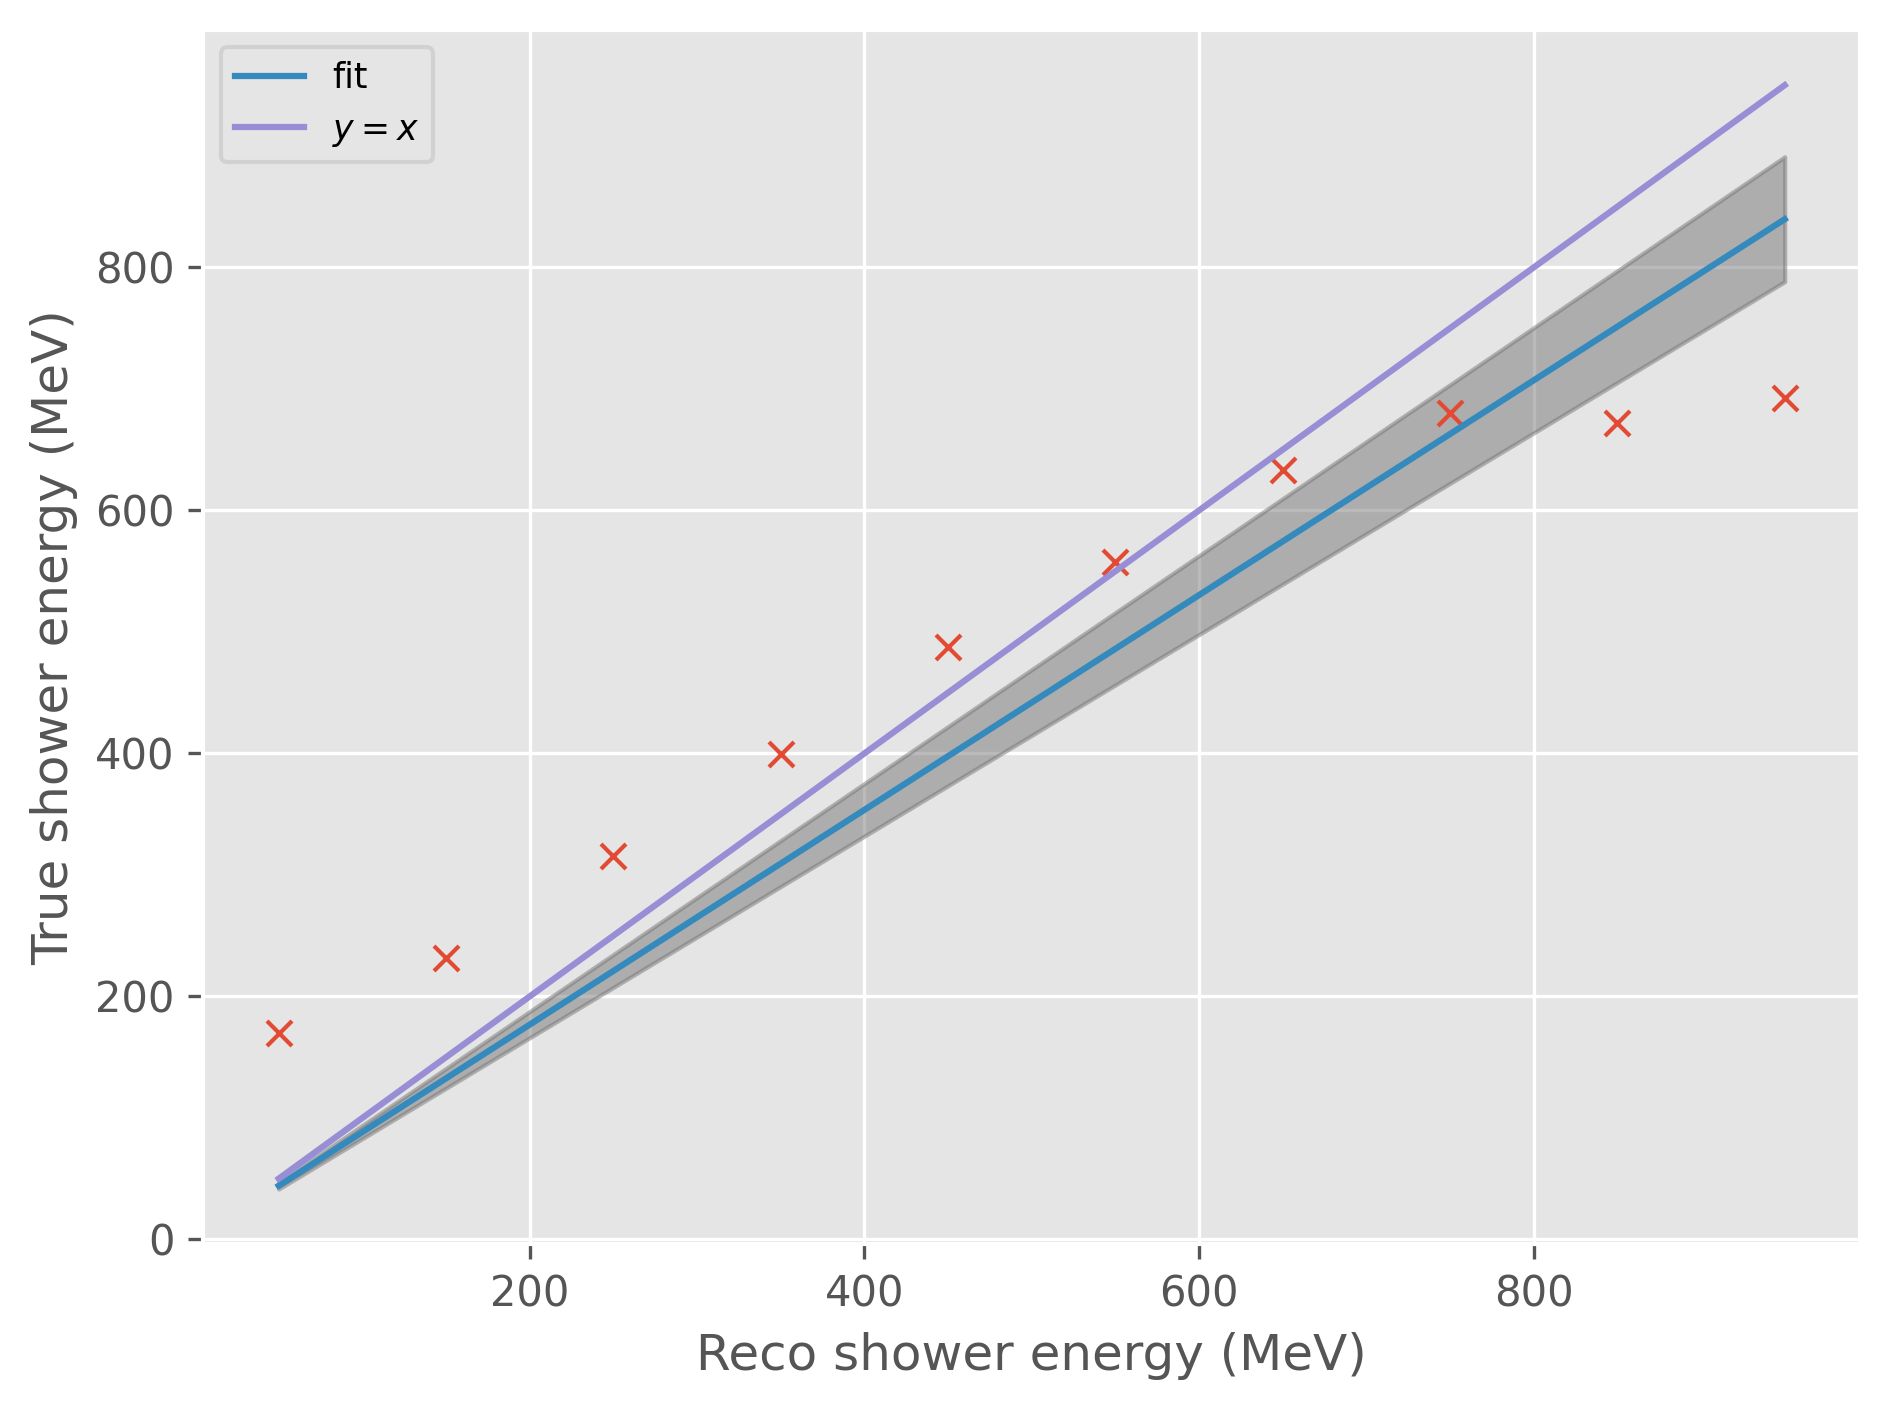

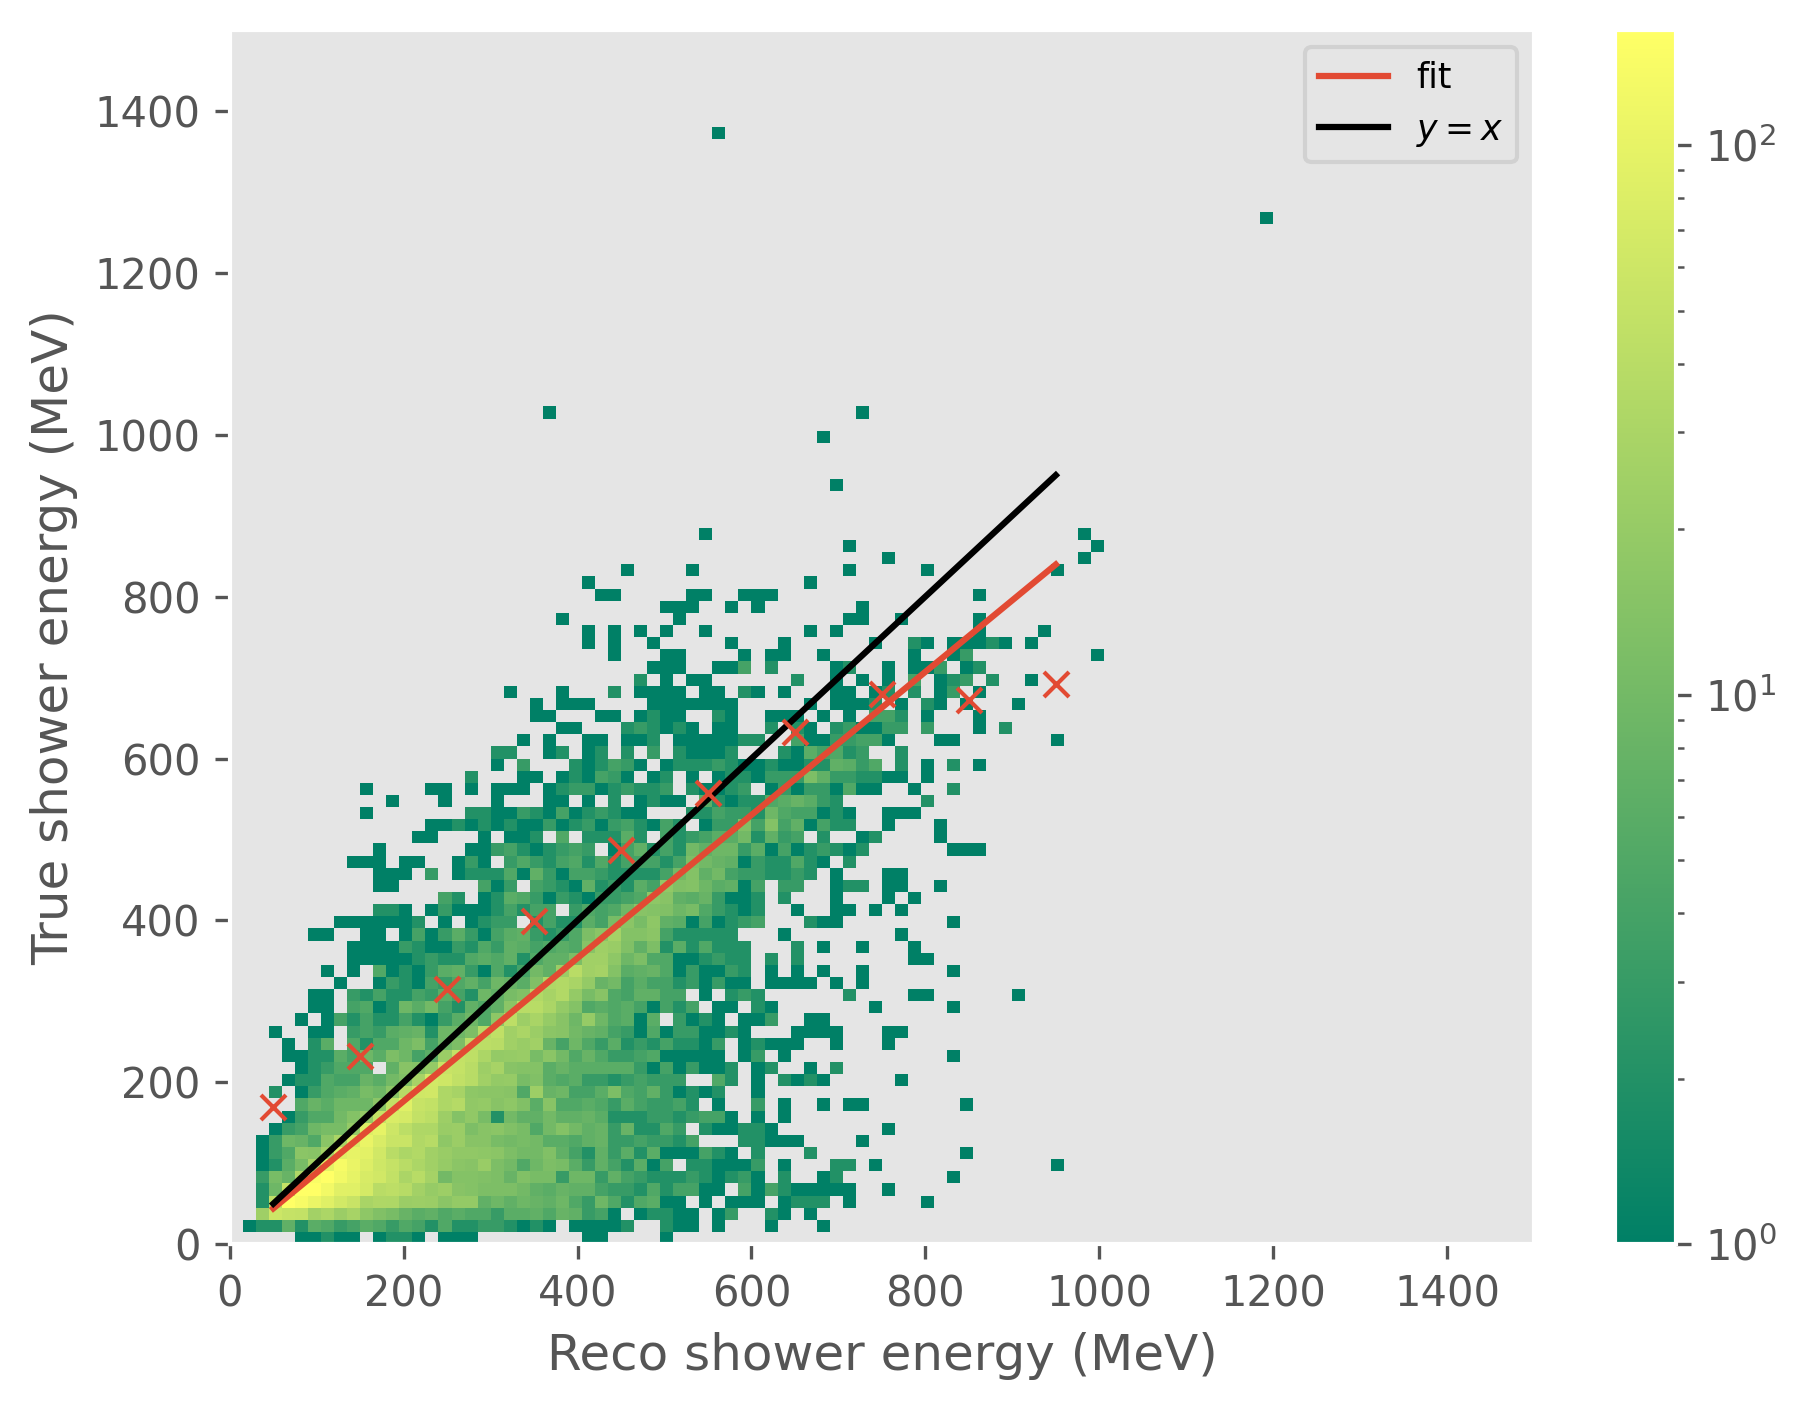

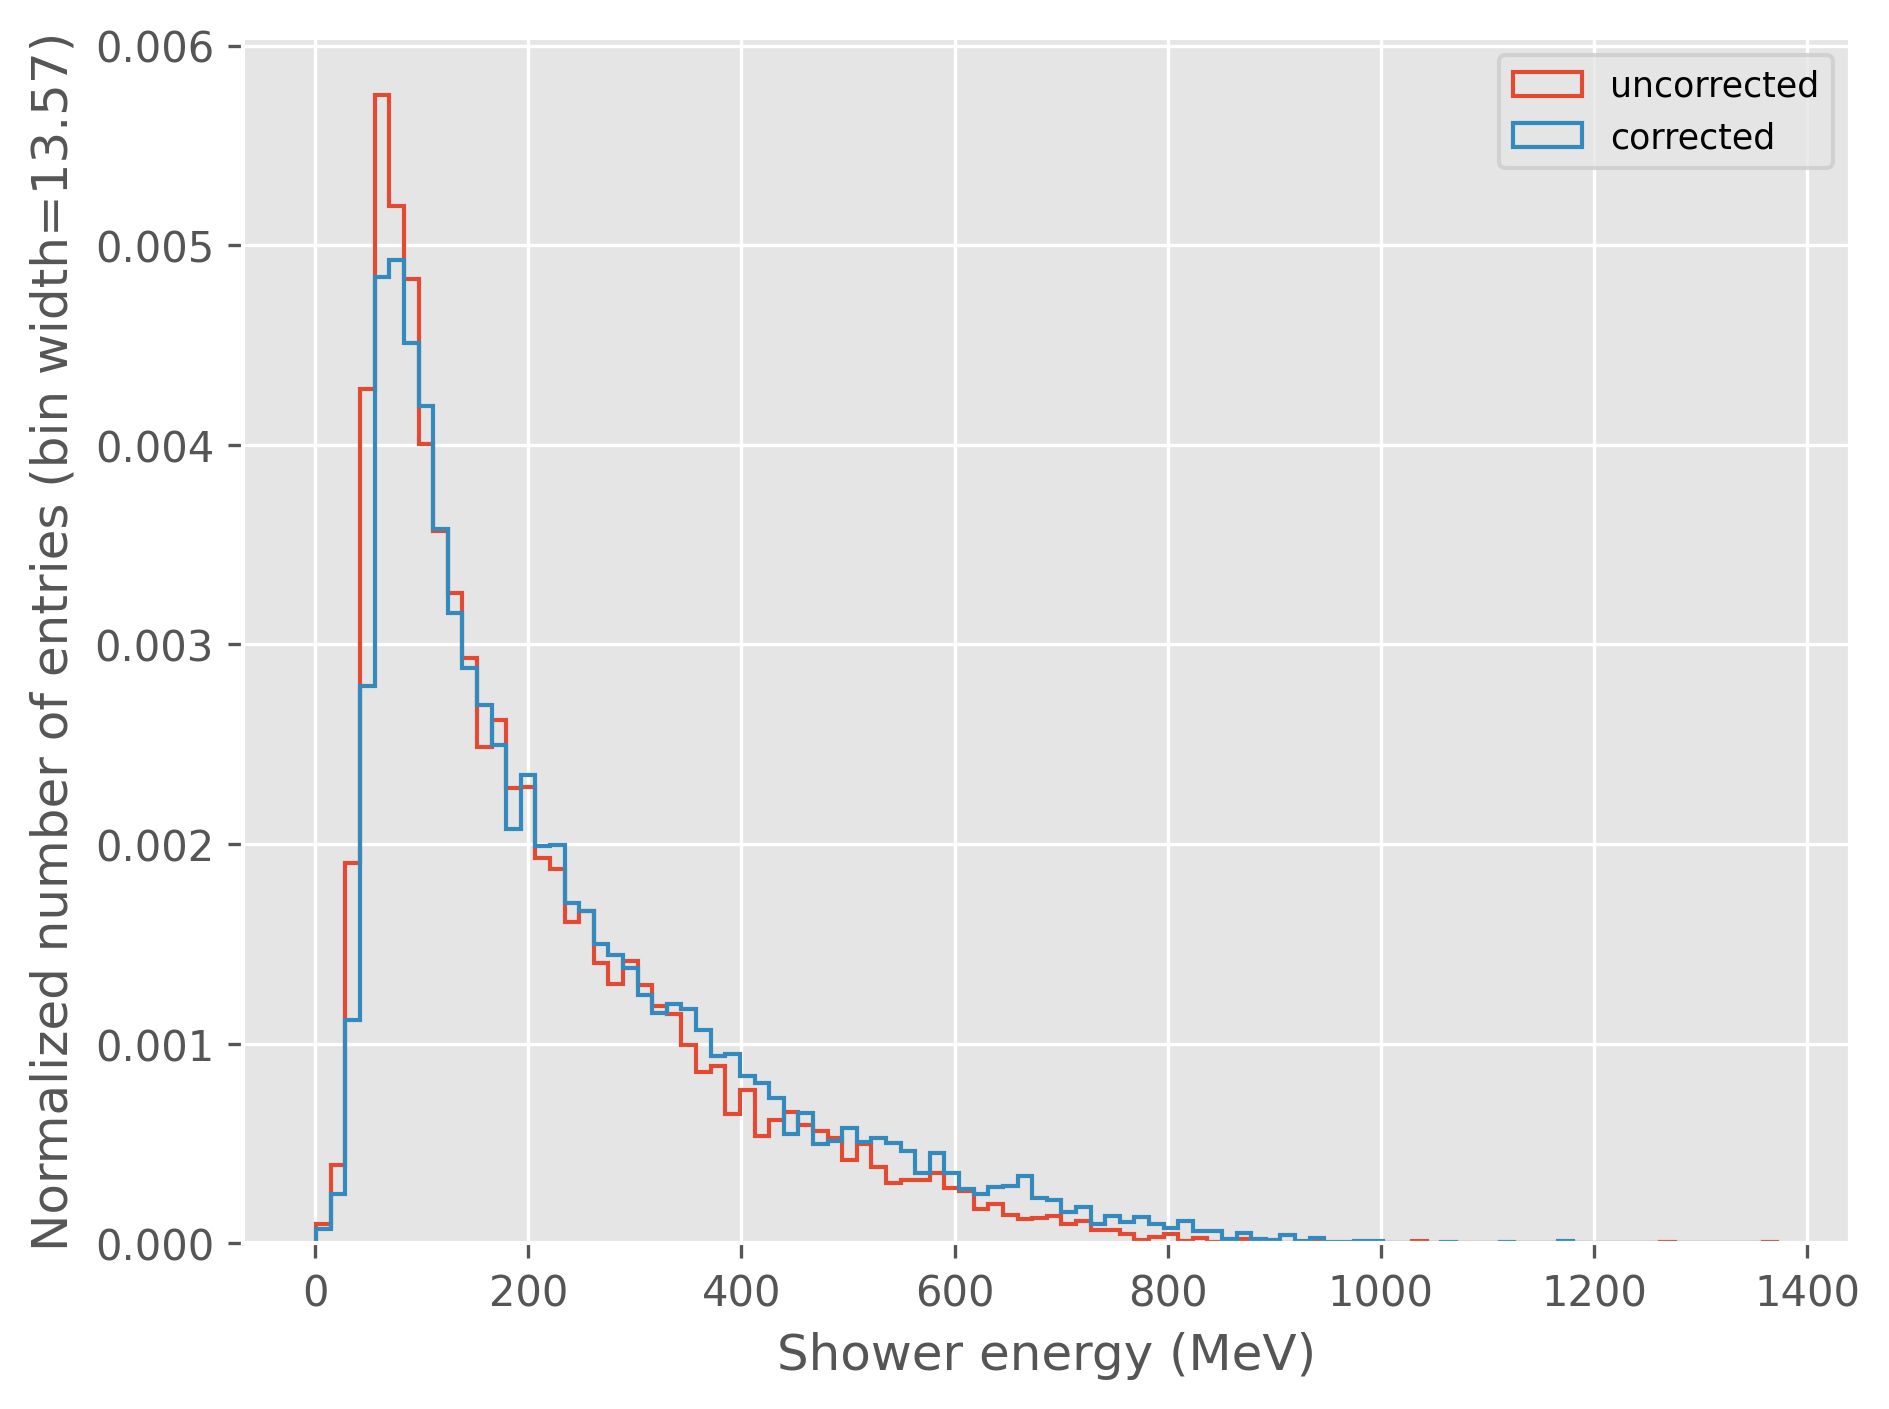

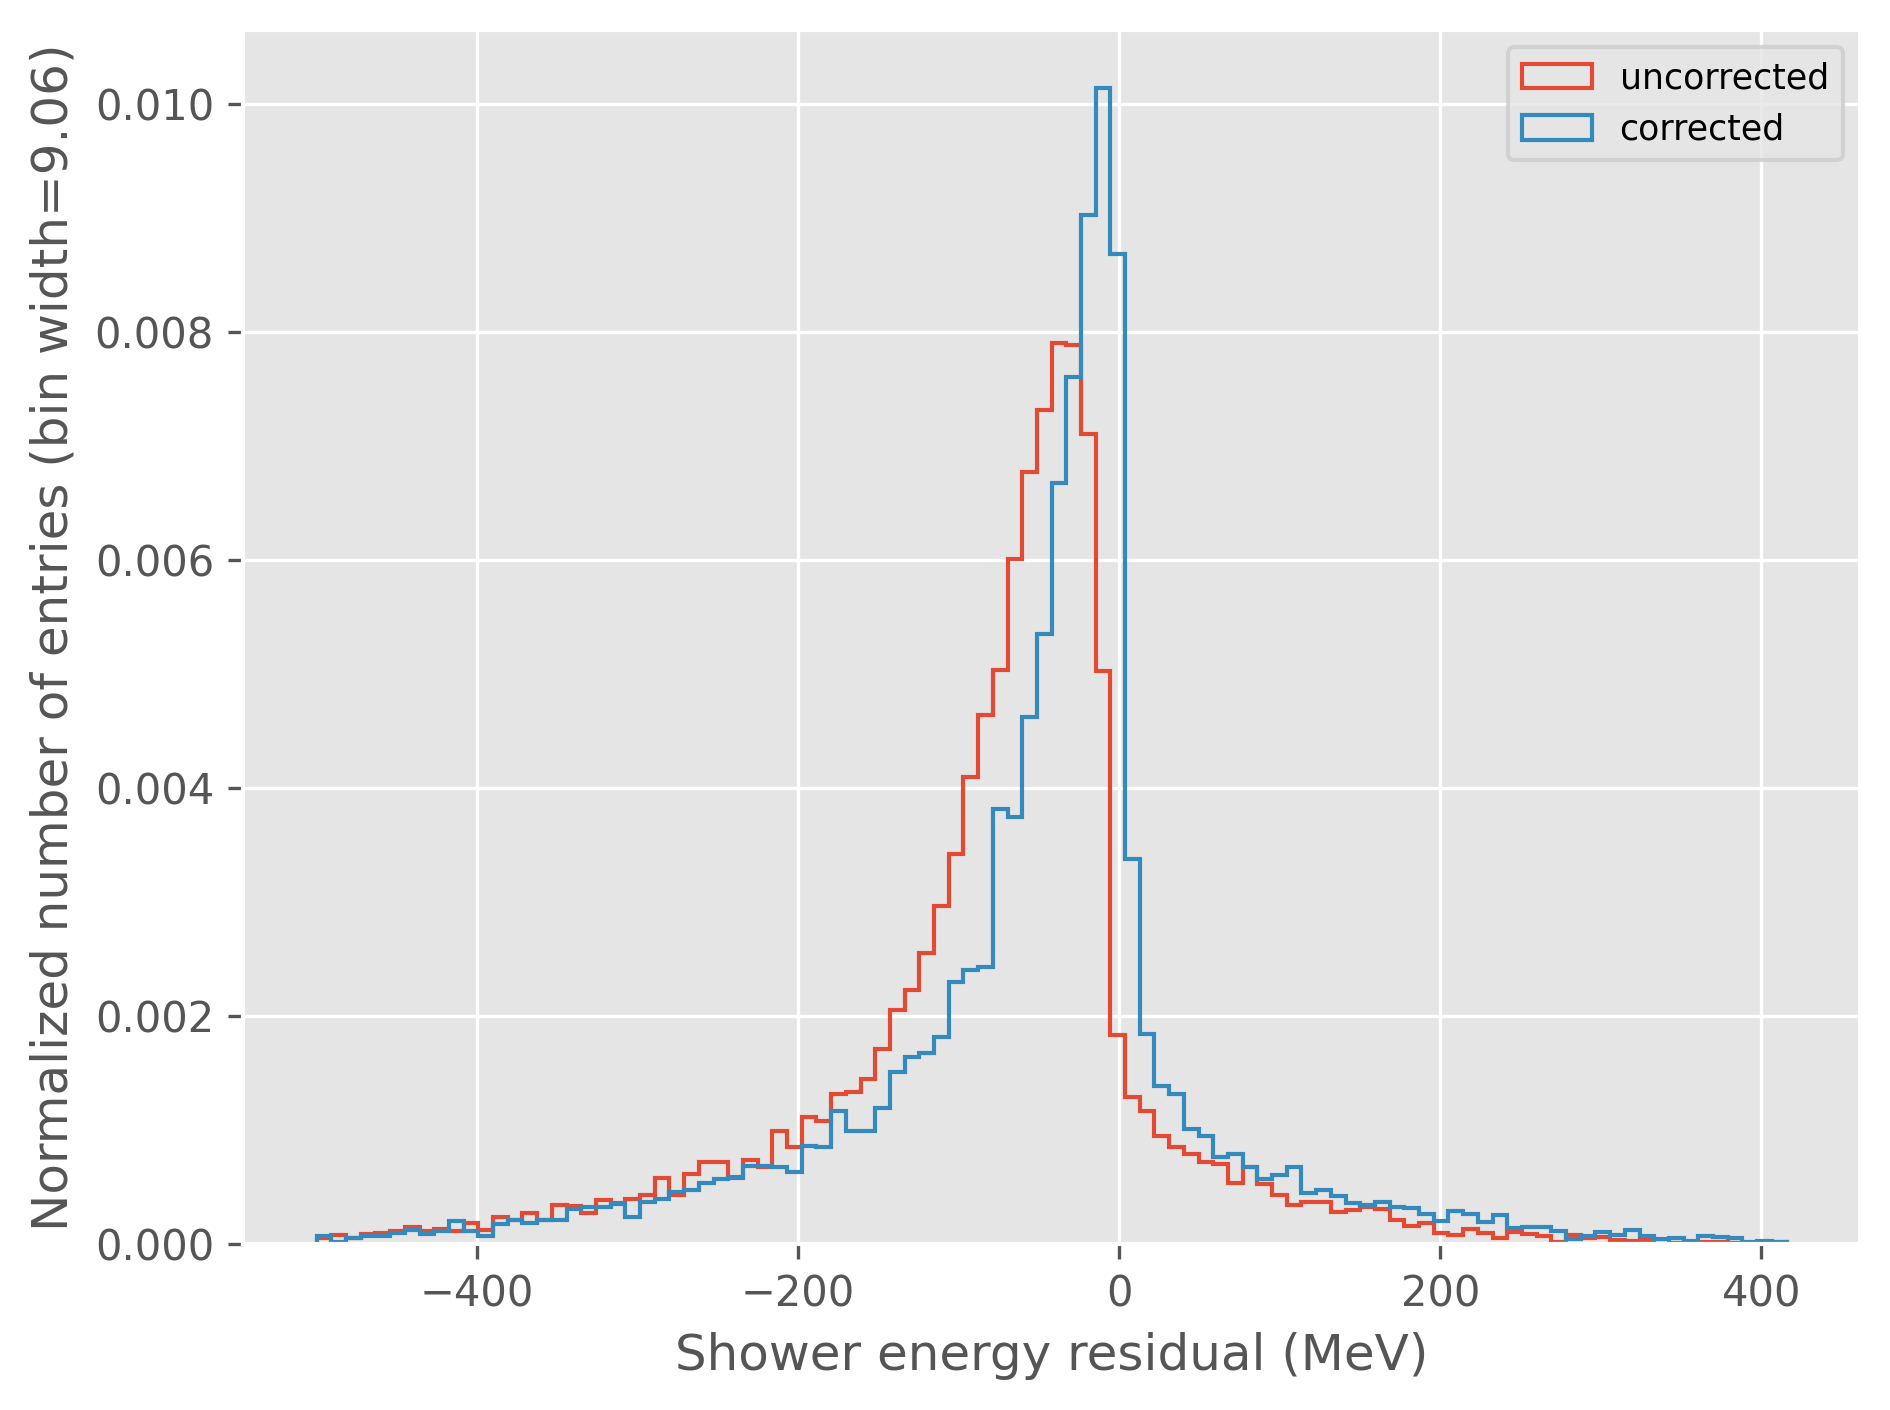

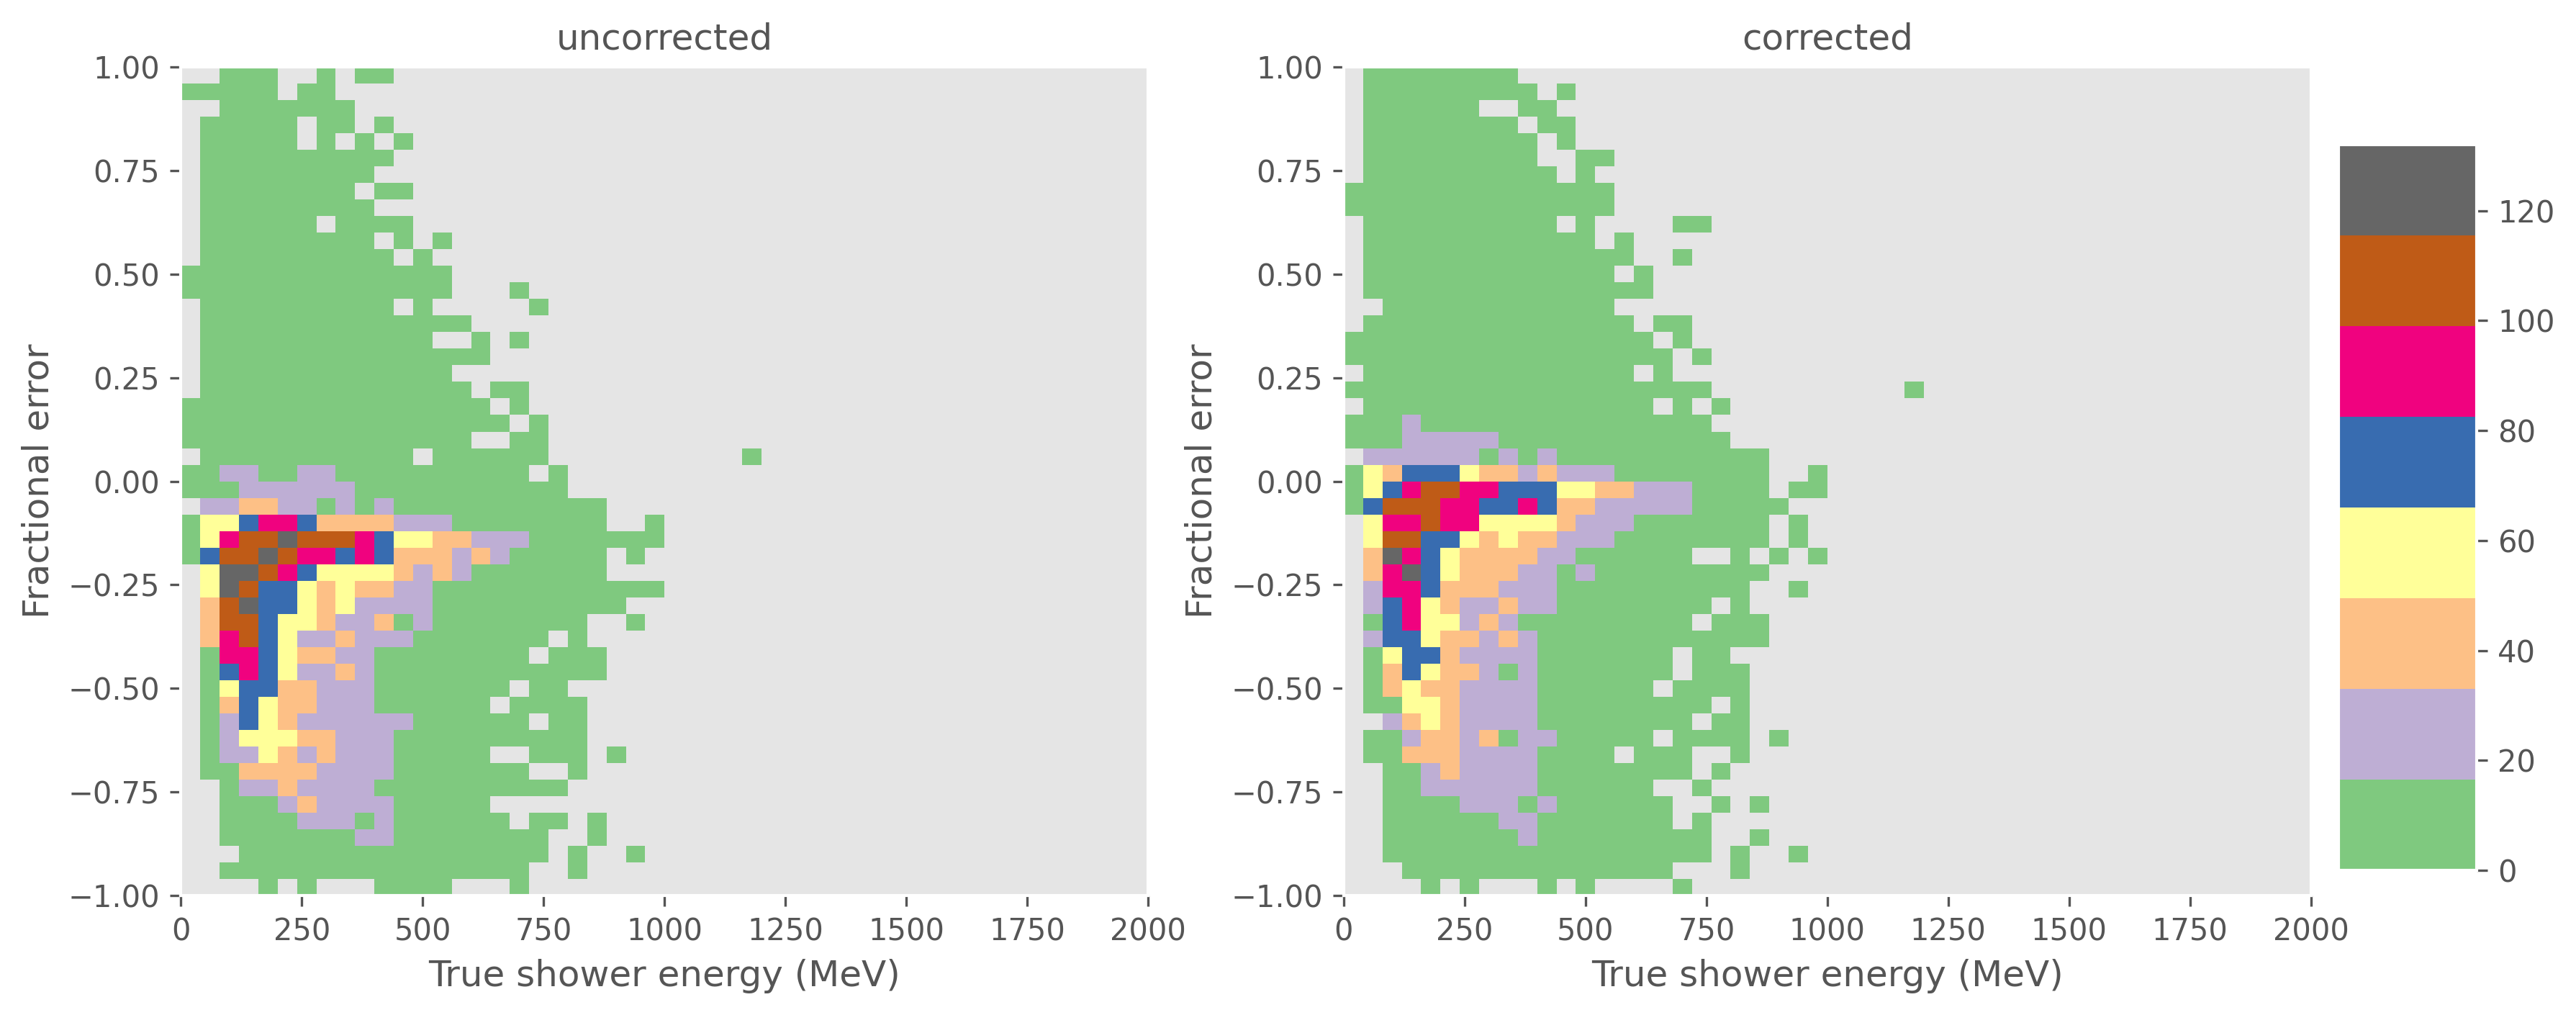

In [33]:
save = False
bins = np.linspace(min(energy_range), max(energy_range), 11)
linear_correction = linear_fit(bins)
LinearFitPerformance(linear_correction)

# Response correction

In [22]:
class FitFunction(ABC):
    @property
    @abstractmethod
    def n_params(self):
        """ number of fit parameters
        """
        pass

    @staticmethod
    @abstractmethod
    def func():
        pass

    @staticmethod
    @abstractmethod
    def bounds():
        pass

    @staticmethod
    @abstractmethod
    def p0():
        pass

    @staticmethod
    @abstractmethod
    def mu():
        pass
    
    @staticmethod
    @abstractmethod
    def var():
        pass

    def __init__(self) -> None:
        pass


class gaussian(FitFunction):
    n_params = 3

    @staticmethod
    def func(x, A, mu, sigma):
        return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

    @staticmethod
    def bounds():
        return [(0, -1, 0.001), (np.inf, 1, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), np.std(x)]
    
    @staticmethod
    def mu(A, mu, sigma):
        return mu

    @staticmethod
    def var(A, mu, sigma):
        return sigma**2


class student_t(FitFunction):
    n_params = 4
    
    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A, mu, nu, l):
        t = (x - mu)/ l
        return (A**2 / l) * (gamma((nu + 1)/2) / (np.sqrt(nu * np.pi) * gamma(nu/2))) * (1 + t**2/nu)**(-(nu + 1)/2)

    @staticmethod
    def bounds():
        return [(0, -1, 0.01, 0.001),
                (np.inf, 1, 10, np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.median(x), 2, np.std(x)]

    @staticmethod
    def mu(A, mu, nu, l):
        return mu

    @staticmethod
    def var(A, mu, nu, l):
        if nu > 2:
            return nu / (nu - 2)
        elif (nu <= 2) and nu > 1:
            return np.Inf
        else:
            return np.NaN


class double_gaussian(FitFunction):
    n_params = 6

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        return A_1 * np.exp(-(x - mu_1)**2 / (2 * sigma_1**2)) + A_2 * np.exp(-(x - mu_2)**2 / (2 * sigma_2**2))

    @staticmethod
    def bounds():
        return [(0     , -1, 0.001 , 0     , -1, 0.001),
                (np.inf, 1 , np.inf, np.inf, 1 , np.inf)]

    @staticmethod
    def p0(x, y):
        return [max(y), np.mean(x), np.std(x), max(y), np.mean(x), np.std(x)]

    @staticmethod
    def mu(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)
        return (w_1 * mu_1) + (w_2 * mu_2)

    @staticmethod
    def var(A_1, mu_1, sigma_1, A_2, mu_2, sigma_2):
        w_1 = A_1 / (A_1 + A_2)
        w_2 = A_2 / (A_1 + A_2)

        return w_1 * (sigma_1**2) + w_2 * (sigma_2**2) + (w_1 * (mu_1**2) + w_2 * (mu_2**2) - (w_1*mu_1 + w_2*mu_2)**2)


class crystal_ball(FitFunction):
    n_params = 5

    def __init__(self) -> None:
        pass

    @staticmethod
    def func(x, S, mu, sigma, alpha, n):
        t = (x - mu) / sigma

        a_alpha = abs(alpha)
        n_alpha = n / a_alpha

        A = (n_alpha)**n * np.exp(-a_alpha**2 / 2)

        B = n_alpha - a_alpha

        C = (n_alpha) * (1/(n - 1)) * np.exp(-a_alpha**2/2)

        D = np.sqrt(np.pi / 2) *(1 + erf(a_alpha/np.sqrt(2)))

        N = 1 / (C + D) # should be 1 / sigma * (C + D), but I dont want to normalise the function

        y = np.where(t > -alpha, np.exp(-t**2 / 2), A * (B - t)**-n)
        return S * N * y

    @staticmethod
    def bounds():
        return [(0, -1, 0.001, 1, 2),
                (np.inf, 1, np.inf, 3, 10)]

    @staticmethod
    def p0(x,y):
        return [max(y), np.mean(x), np.std(x), 1, 2]

    @staticmethod
    def mu(S, mu, sigma, alpha, n):
        return mu

    @staticmethod
    def var(S, mu, sigma, alpha, n):
        return sigma


In [28]:
def ExtractCentralValues(variable : str, v_range : list, funcs, reco_bins : list, hist_bins : int, log : bool = False):
    """ Estimate a central value in each reco energy bin based on some FitFunction or collection of FitFunctions.

    Args:
        variable (str): variable to fit to
        v_range (list): variable range
        funcs (FitFunction): functions to try fit
        reco_bins (list): reco energy bins
        hist_bins (int): number of bins for variable histograms
        log (bool, optional): verbose printout. Defaults to False.
    """
    def print_log(x):
        if log: print(x)

    cv = []
    cv_err = []
    fig_handles = None
    fig_labels = None
    for i in Plots.MultiPlot(len(reco_bins) - 1):
        if i == len(reco_bins): continue
        print_log(i)
        binned_data = df[(df.reco_energy > reco_bins[i]) & (df.reco_energy < reco_bins[i+1])]
    
        y, edges = np.histogram(binned_data[variable], bins = hist_bins, range = [min(v_range), max(v_range)])
        x = (edges[1:] + edges[:-1]) / 2
        x_interp = np.linspace(min(x), max(x), hist_bins*5)

        best_f = None
        best_popt = None
        best_perr = None
        k_best = None
        p_best = None

        for f in funcs:
            function = f()
            popt = None
            pcov = None
            perr = None
            try:
                popt, pcov = curve_fit(function.func, x, y, p0 = function.p0(x, y), method = "dogbox", bounds = function.bounds(), maxfev = 500000)
                perr = np.sqrt(np.diag(pcov))
                print_log(popt)
                print_log(perr)
                print_log(pcov)
            except Exception as e:
                print_log("could not fit")
                pass
            y_pred = function.func(x, *popt) if popt is not None else None
            if y_pred is not None:
                k, p = ks_2samp(y, y_pred)
            else:
                k = 1
                p = 0

            if p_best is None or p > p_best : # larger p value suggests a better fit
                p_best = p
                k_best = k
                best_popt = popt
                best_perr = perr
                best_f = f

        mean = None
        mean_error = None
        if best_popt is not None:
            function = best_f()
            mean = function.mu(*best_popt)
            mean_error = mean - (function.mu(*(best_popt + best_perr)) + function.mu(*(best_popt + best_perr))) / 2
            y_pred = function.func(x, *best_popt)
            y_pred_interp = function.func(x_interp, *best_popt)
            k, p = ks_2samp(y, y_pred)

            Plots.Plot(x_interp, y_pred_interp, marker = "", color = "black", newFigure = False, label = "fit")
            plt.axvline(mean, color = "black", linestyle = "--", label = "central value")
        Plots.PlotHist(binned_data[variable], bins = hist_bins, newFigure = False, title = f"bin : {[reco_bins[i], reco_bins[i+1]]}", range = [min(v_range), max(v_range)])

        plt.axvline(np.mean(binned_data[variable]), linestyle = "--", color = "C1", label = "mean")

        if not fig_handles: fig_handles, fig_labels = plt.gca().get_legend_handles_labels()

        if best_popt is not None:
            text = ""
            for j in range(len(best_popt)):
                text += f"\np{j}: ${best_popt[j]:.2f}\pm${best_perr[j]:.2f}"
            text += f"\nks : {k_best:.2f}, p : {p_best:.2f}"
            legend = plt.gca().legend(handlelength = 0, labels = [text[1:]], title = best_f.__name__.replace("_", " "))
            for l in legend.legendHandles:
                l.set_visible(False)

        cv.append(mean)
        cv_err.append(abs(mean_error) if mean_error is not None else mean_error)
    
    plt.gcf().legend(fig_handles, fig_labels, loc = "lower right", ncols = 3)
    plt.gcf().supxlabel(variable.replace("_", " "))
    plt.tight_layout()
    if save is True : Plots.Save("binned_fits_double_gaussian", path)
    return np.array(cv), np.array(cv_err)


def IterBinnedDF(variable : str, v_range: list, reco_bins : list) -> pd.DataFrame:
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        yield ranged_data[variable]


def calculate_mean(variable : str, v_range: list, reco_bins : list):
    means = []
    for column in IterBinnedDF(variable, v_range, reco_bins):
        means.append(column.mean())
    return np.array(means)


def calculate_sem(variable : str, v_range: list, reco_bins : list):
    sem = []
    for column in IterBinnedDF(variable, v_range, reco_bins):
        sem.append(column.std() / np.sqrt(len(column)))
    return np.array(sem)


def create_bins(value : pd.Series, n_entries, v_range : list = None):
    sorted_value = value.sort_values()
    n_bins = len(sorted_value) // n_entries

    bins = []
    for i in range(n_bins + 1):
        mi = sorted_value.values[i * n_entries]
        bins.append(mi)
    if v_range:
        bins[0] = min(v_range)
        bins[-1] = max(v_range)
    return np.array(bins)


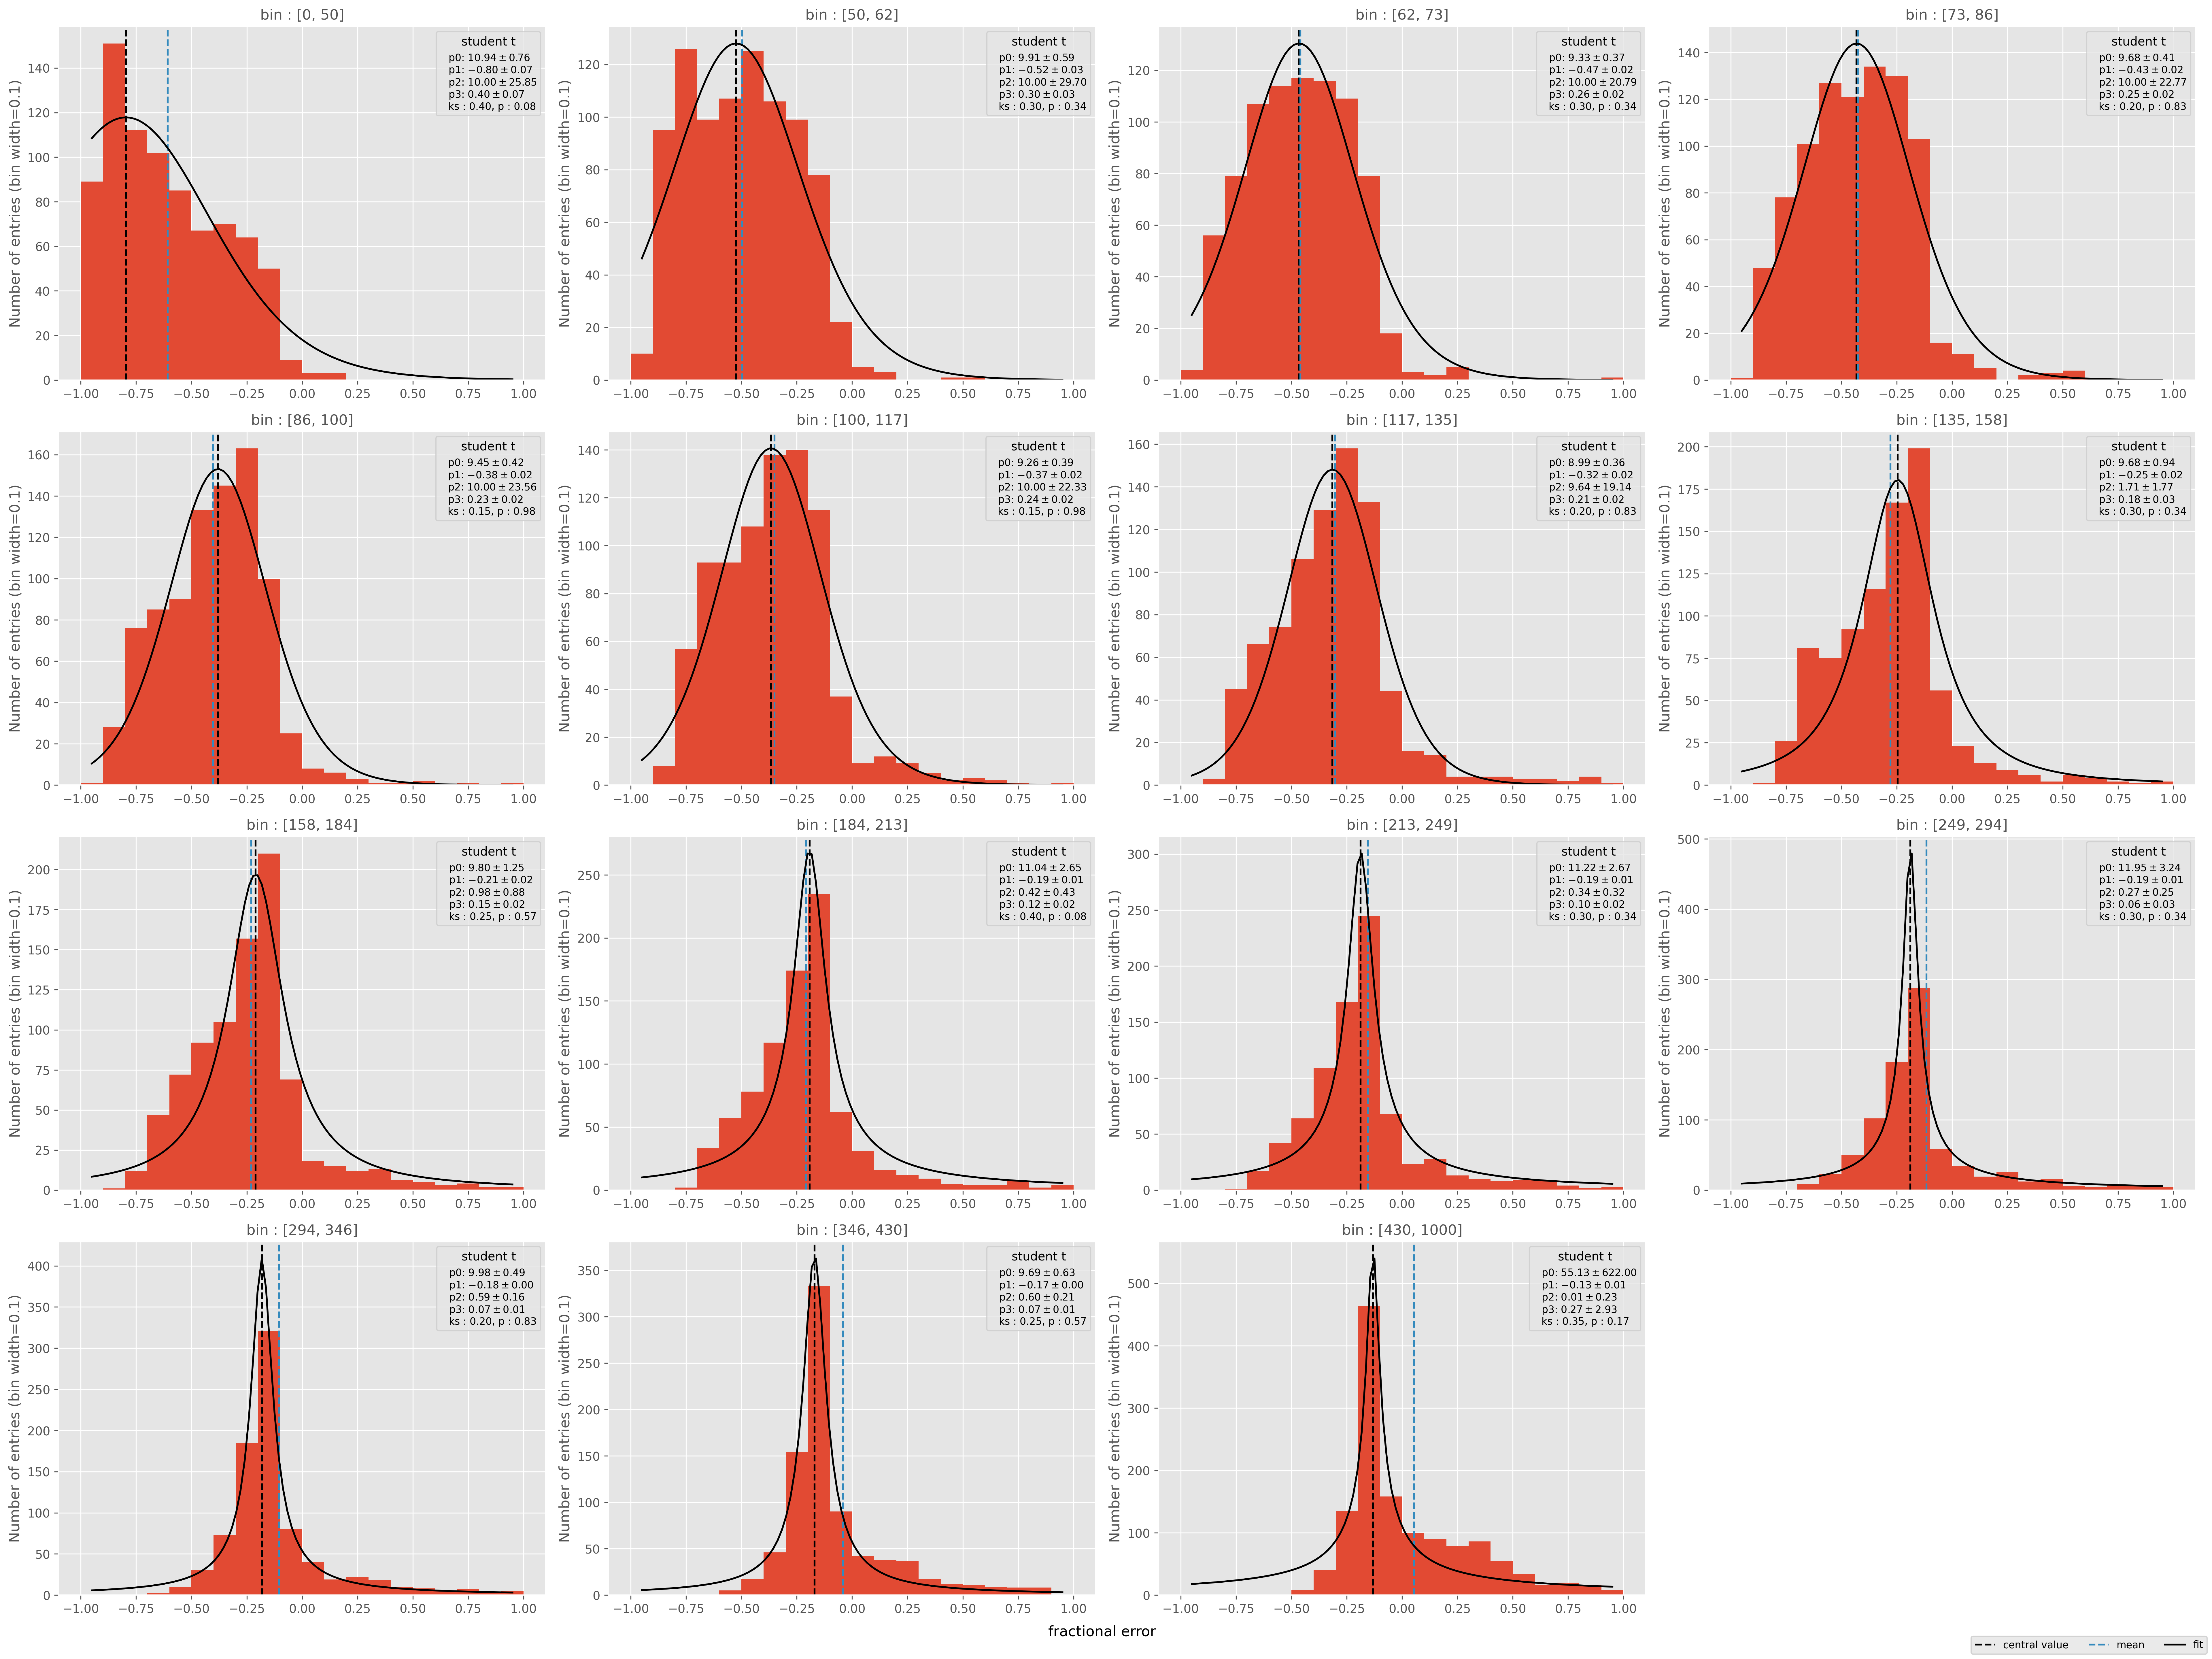

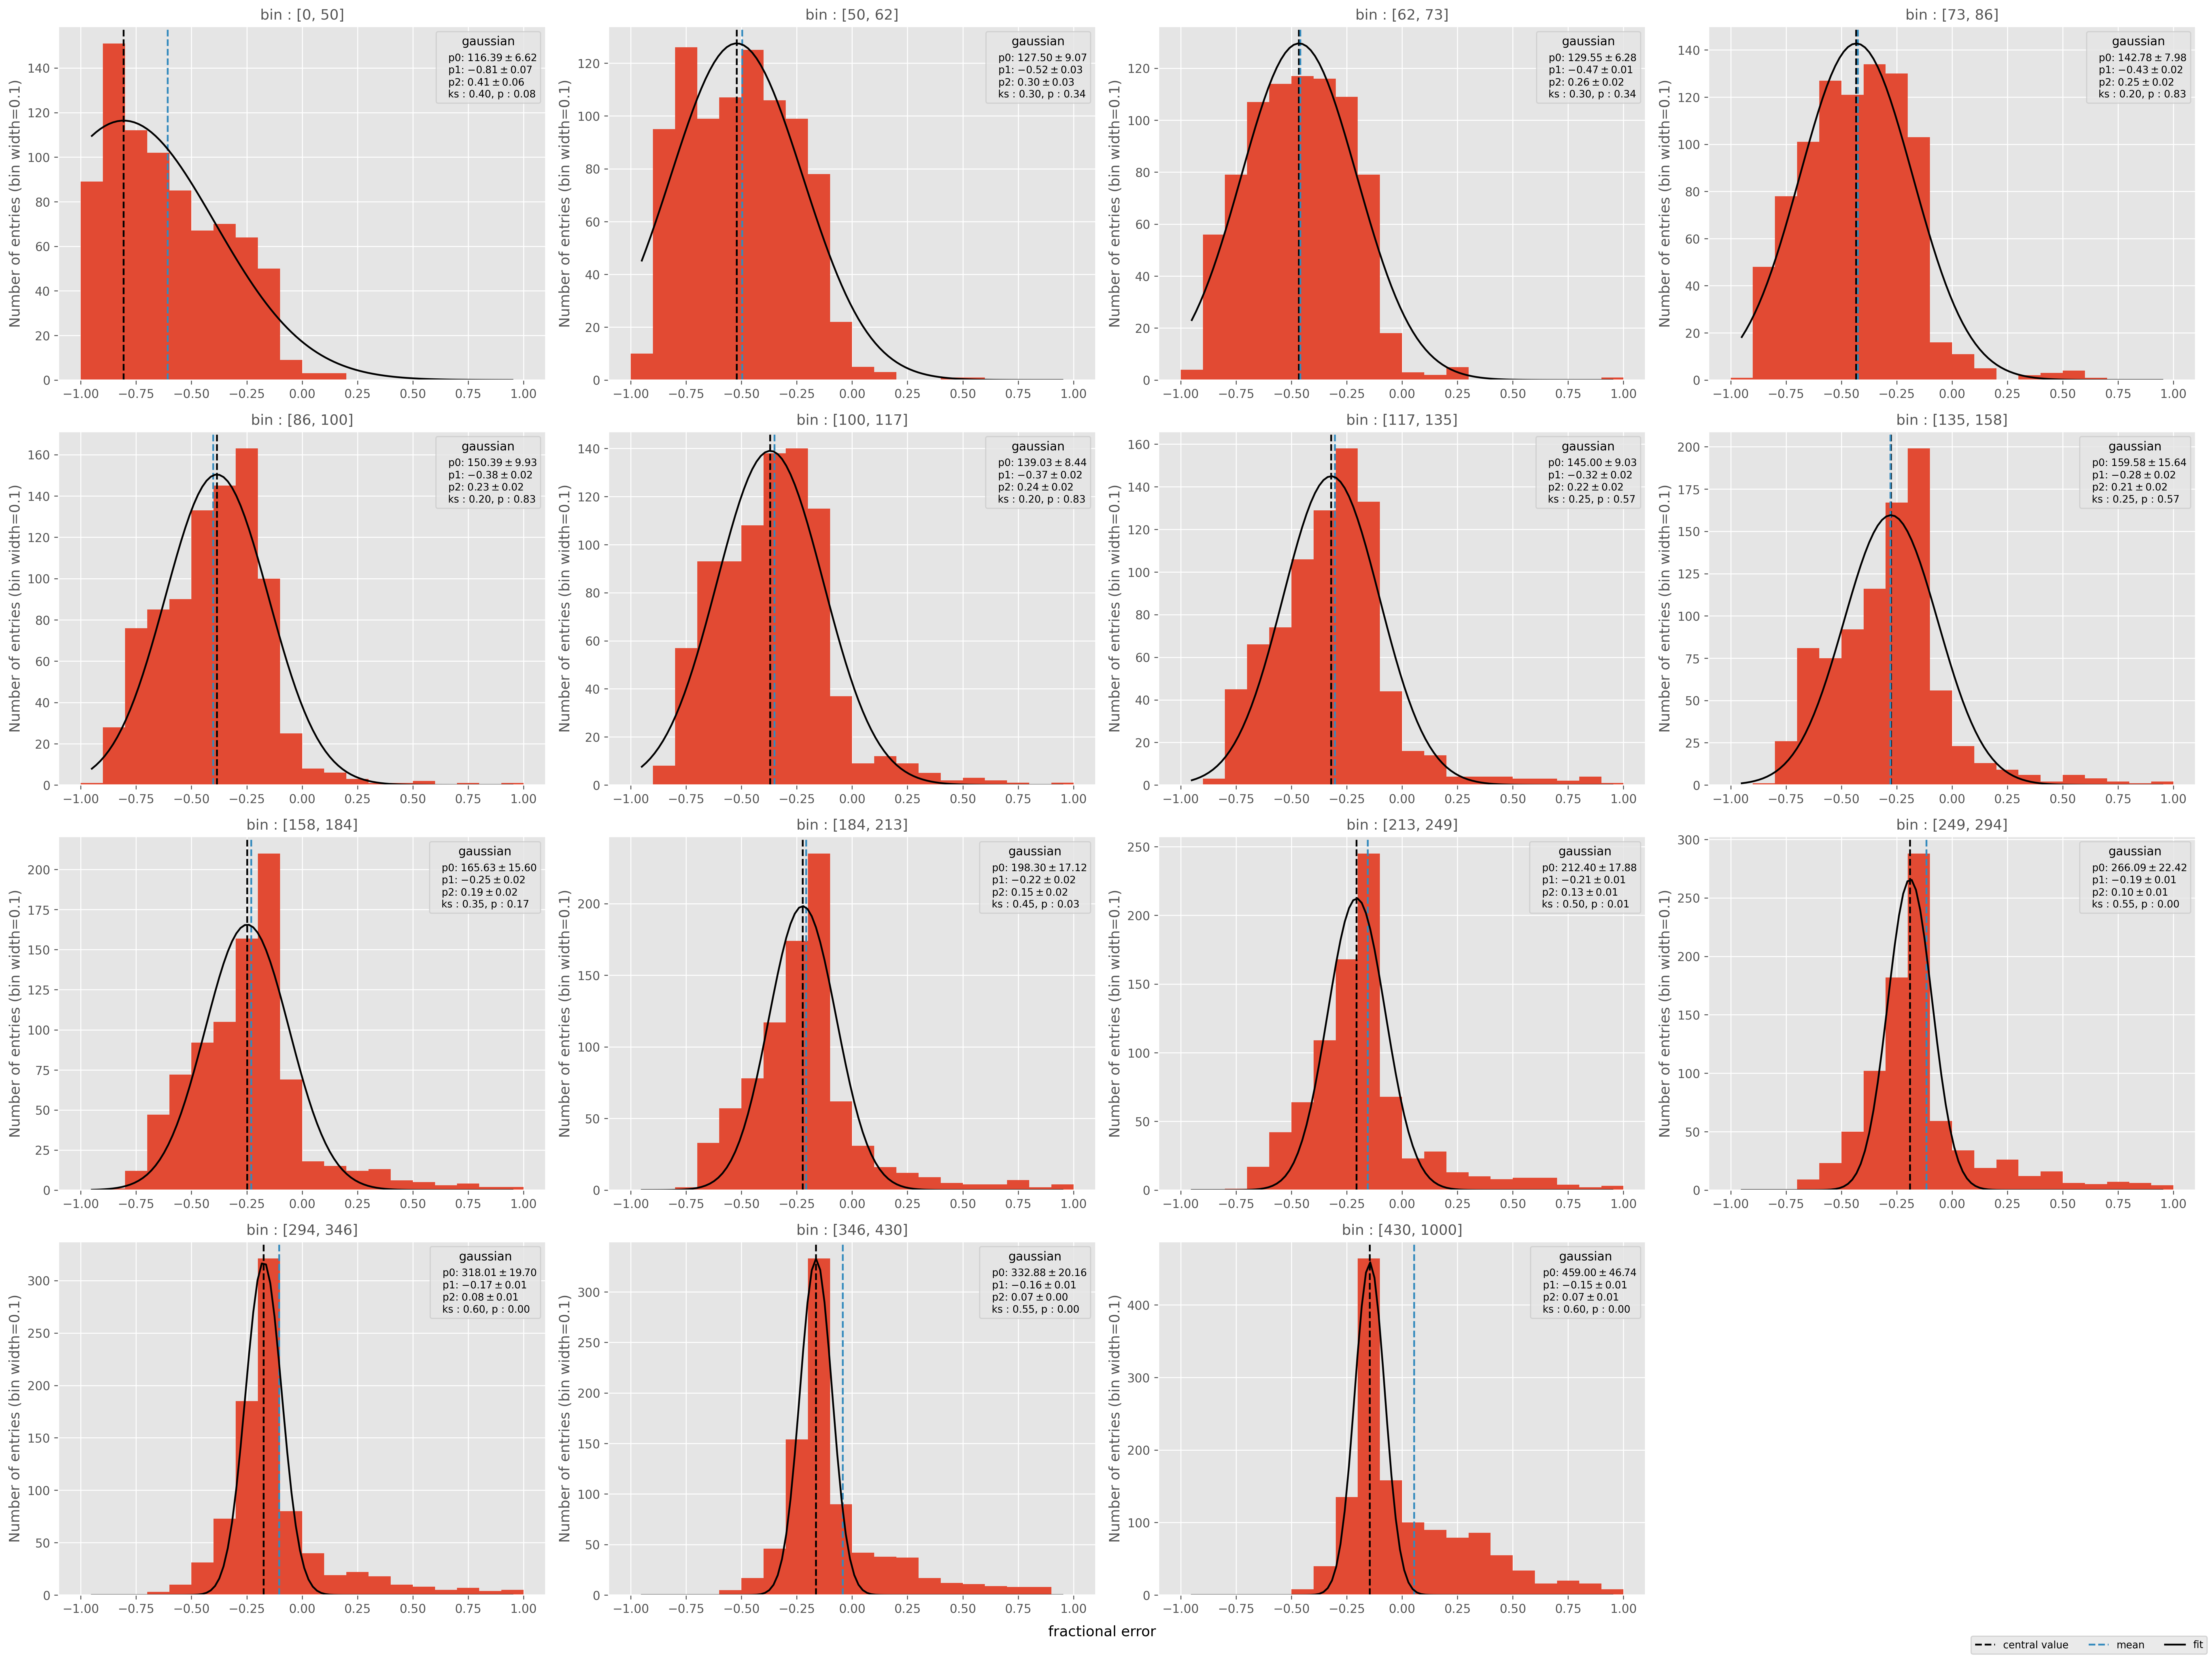

In [29]:
save = False
bins = np.array(create_bins(df.reco_energy, 850, energy_range), dtype = int)

central_values = {
    "student_t" : ExtractCentralValues("fractional_error", [-1, 1], [student_t], bins, 20),
    "gaussian" : ExtractCentralValues("fractional_error", [-1, 1], [gaussian], bins, 20),
    # "double_gaussian" : fit_regions("fractional_error", [-1, 1], [double_gaussian], bins, 20),
    "mean" : [calculate_mean("fractional_error", [-1, 1], bins), calculate_sem("fractional_error", [-1, 1], bins)]
    }

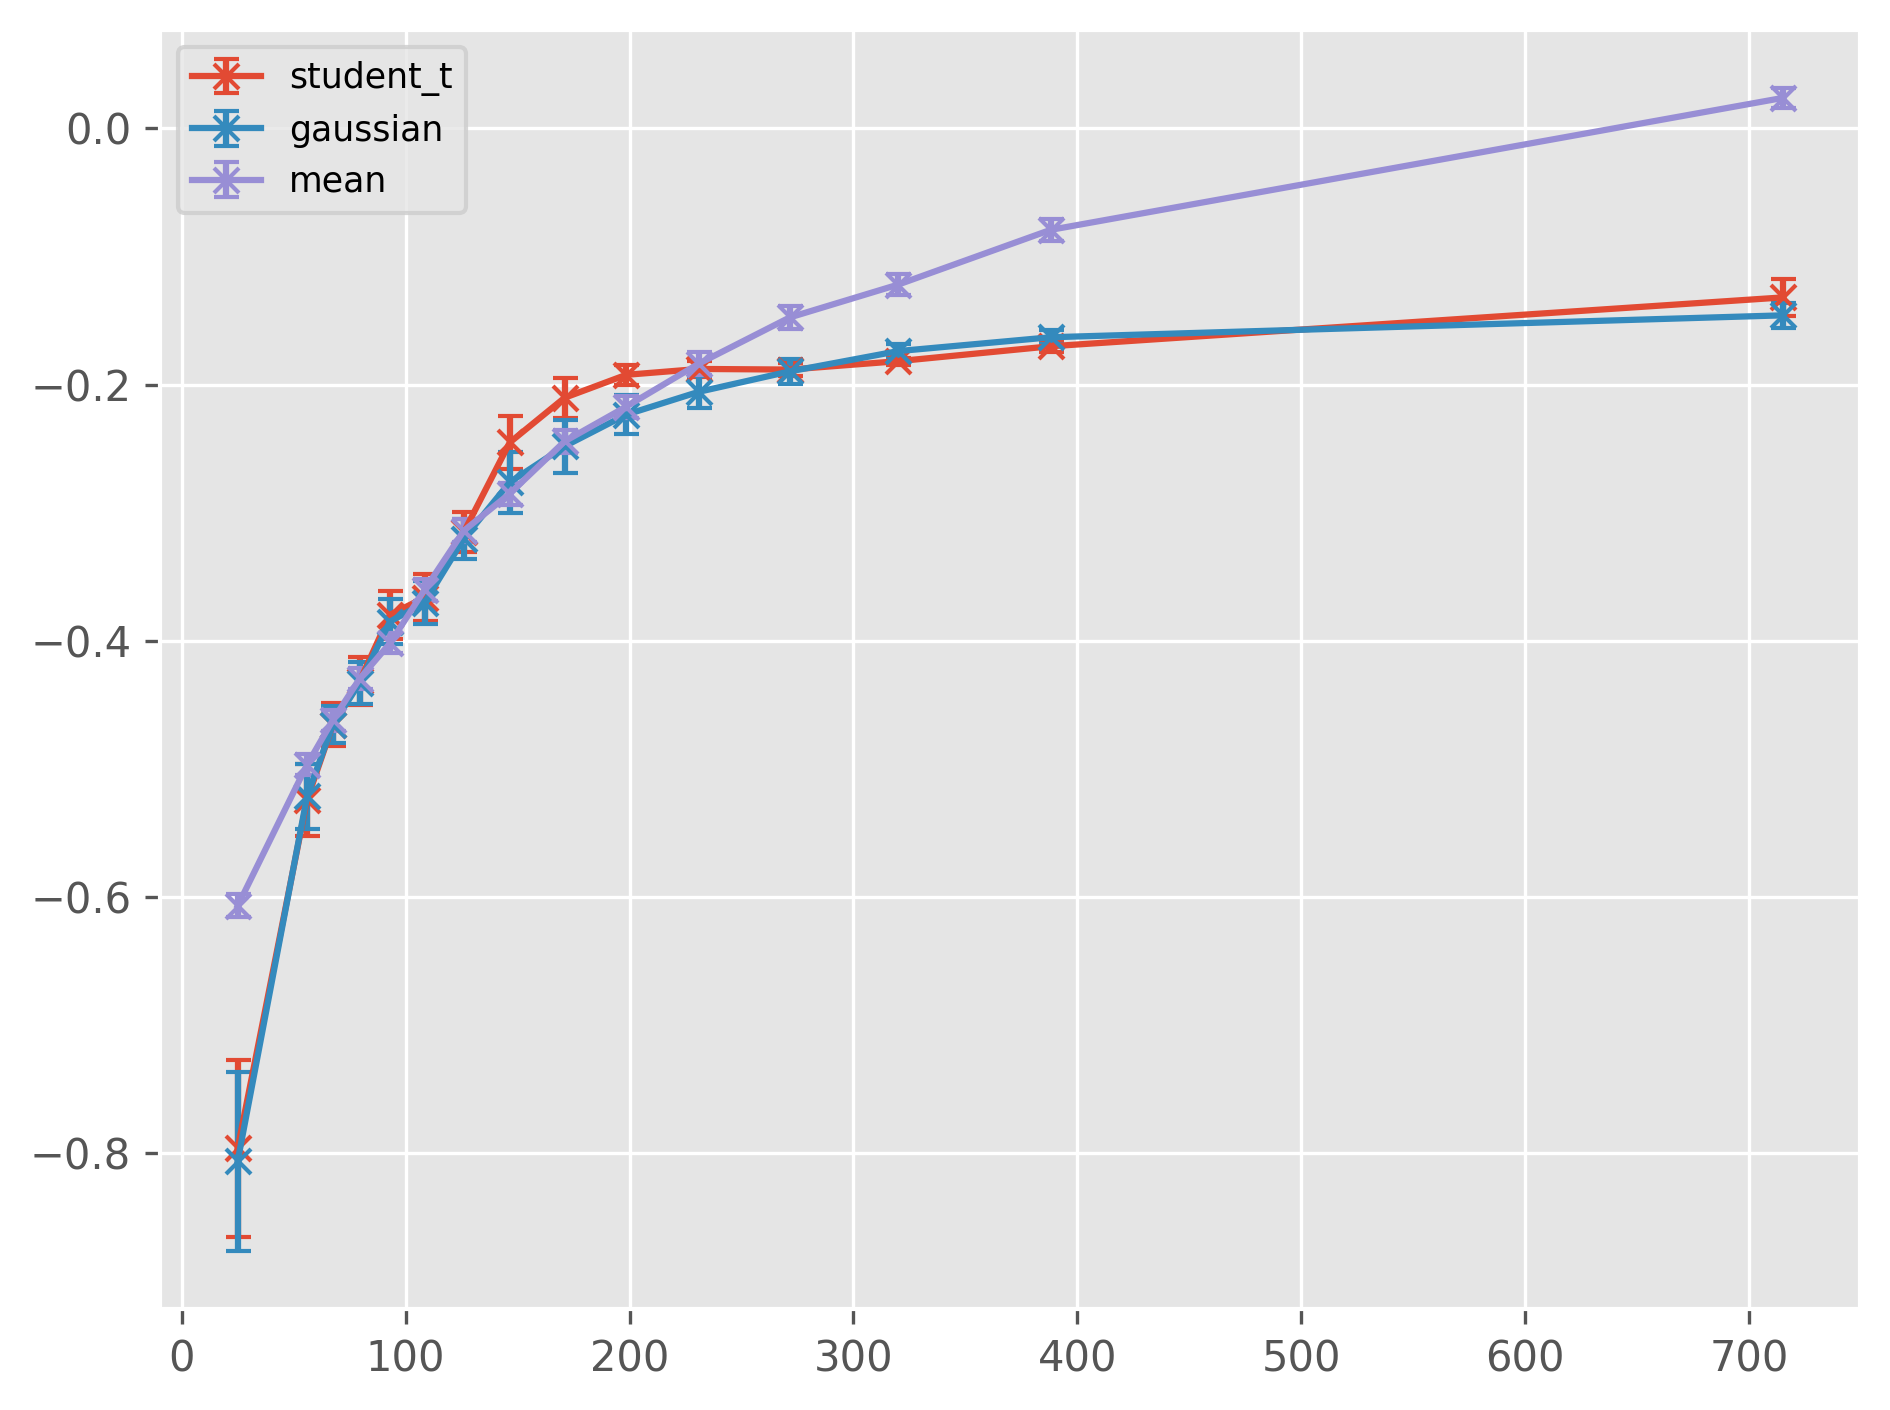

In [30]:
x = (bins[1:] + bins[:-1]) / 2
for i, cv in enumerate(central_values):
    Plots.Plot(x, np.array(central_values[cv][0], dtype = float), yerr = np.array(central_values[cv][1], dtype = float), marker = "x", label = cv, color = f"C{i}", newFigure = False)

## fractional error fit

student_t

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:102: RuntimeWarning: invalid value encountered in log
  return p0 * np.log(x - p1) + p2


gaussian

mean

{
    'student_t': array([ 0.11482795, 24.01158728, -0.83158488]),
    'gaussian': array([ 0.12576031, 23.46724048, -0.90543613]),
    'mean': array([  0.22177318, -10.05788836,  -1.41330206])
}

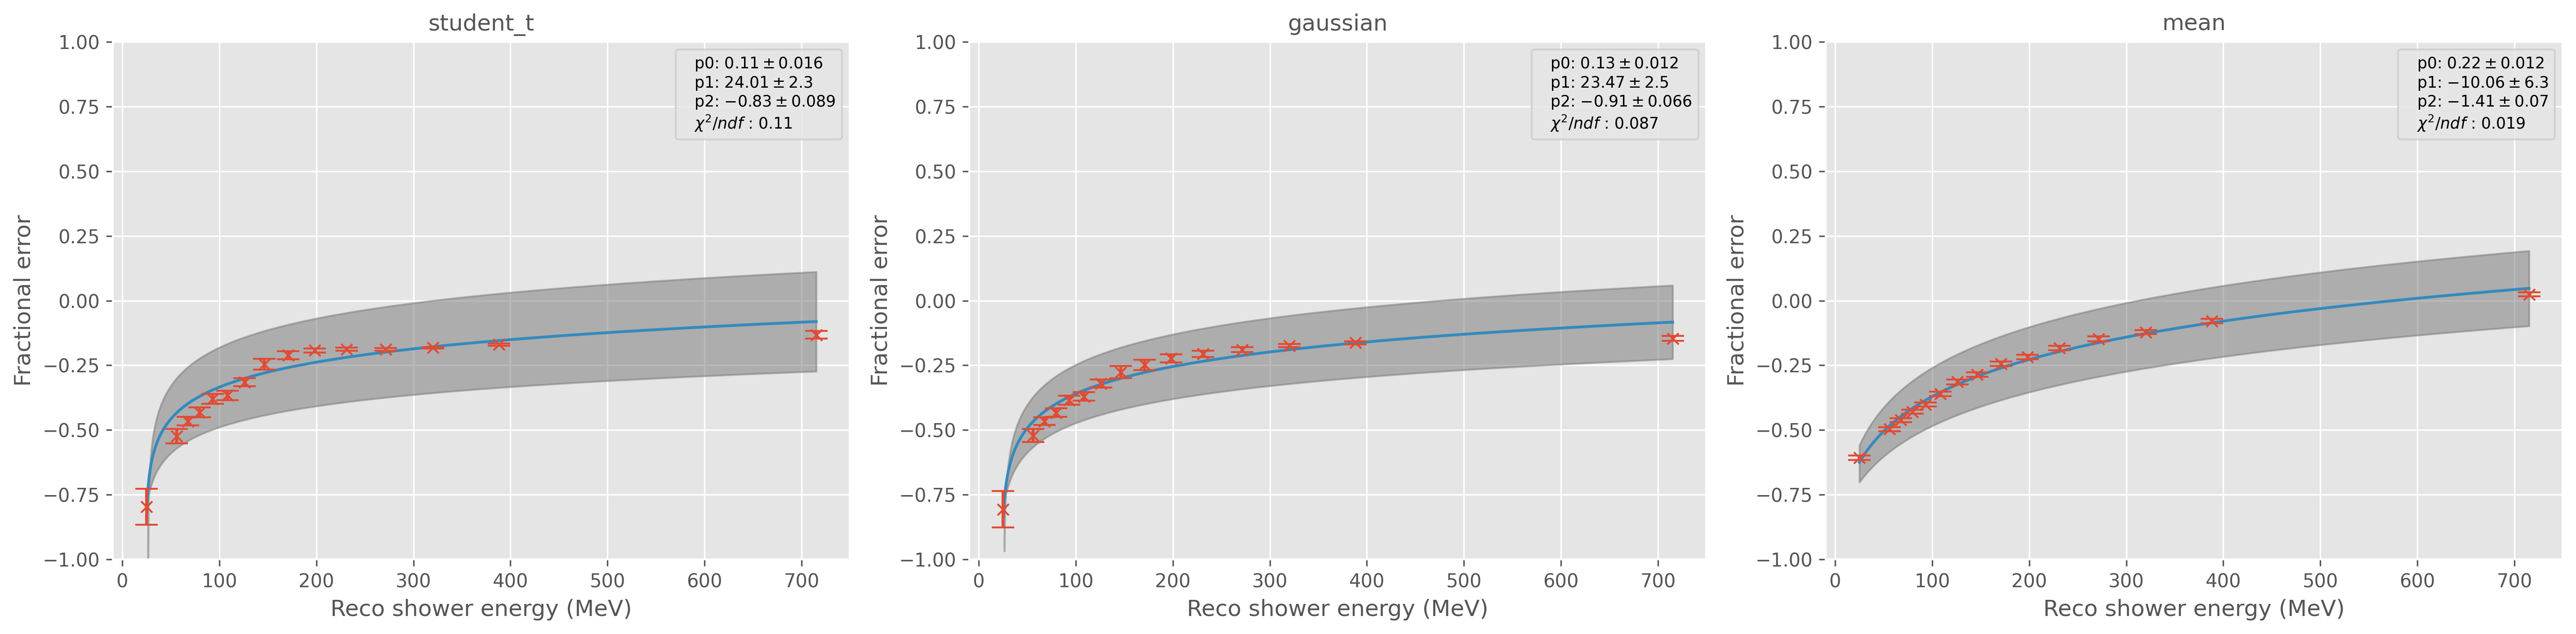

In [31]:
response_params = {}

for i, cv in Plots.IterMultiPlot(central_values):
    print(cv)
    popt = cross_section.Fitting.Fit((bins[1:] + bins[:-1]) / 2, central_values[cv][0], central_values[cv][1], cross_section.EnergyCorrection.ResponseFit, xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error")
    plt.ylim(-1, 1)
    plt.title(cv)
    response_params[cv] = popt

print(response_params)
if save: Plots.Save("respone_fits", path)

# Linear vs response fit

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


uncorrected : mean -0.261 std 0.348

linear : mean -0.164 std 0.394

student_t : mean 0.016 std 0.422

gaussian : mean 0.048 std 0.485

mean : mean 0.013 std 0.416

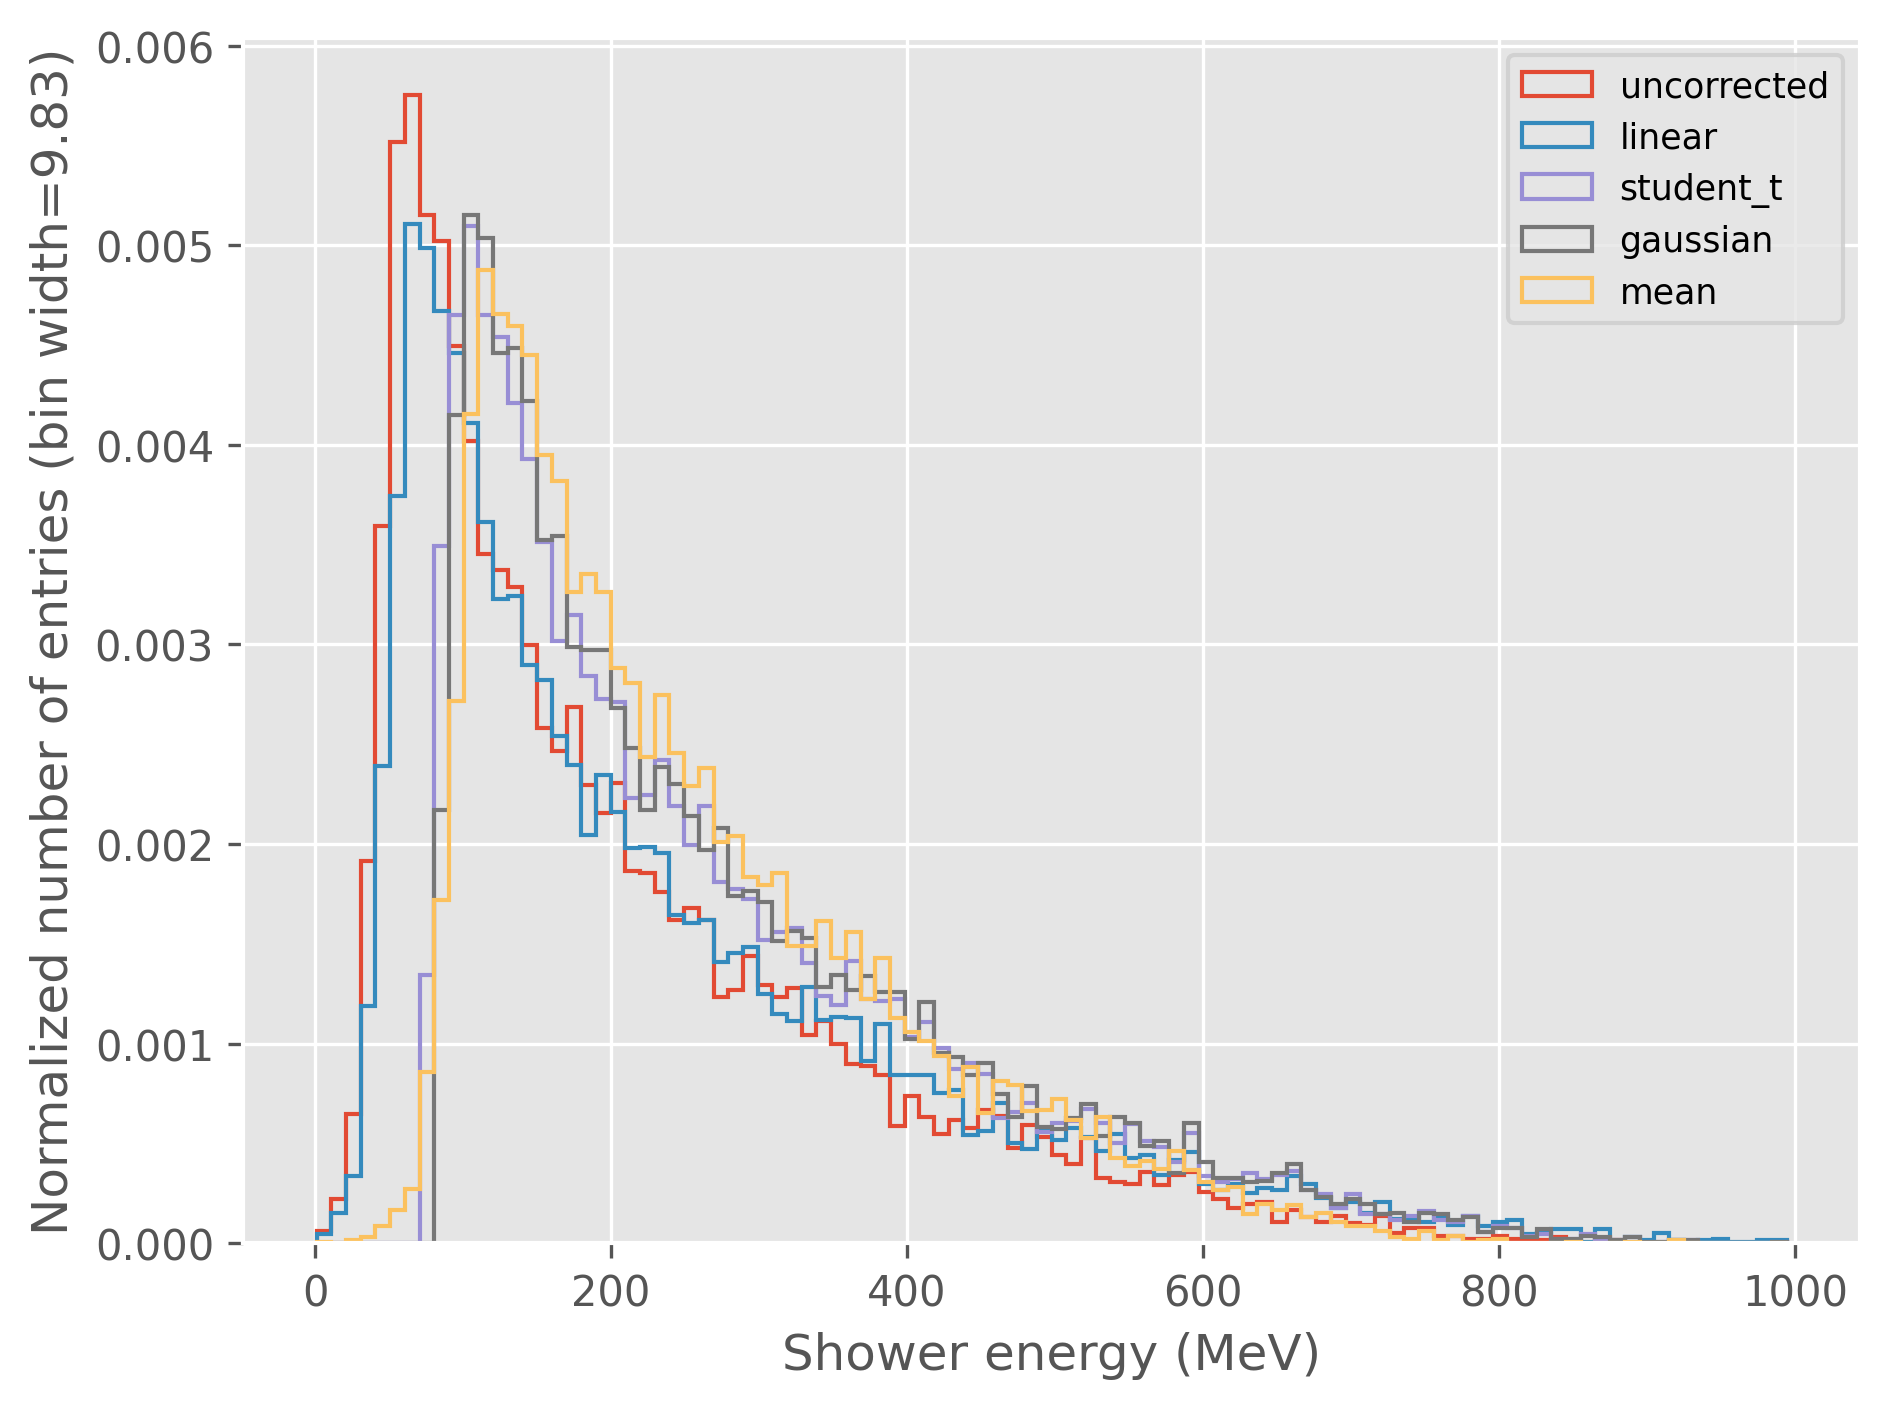

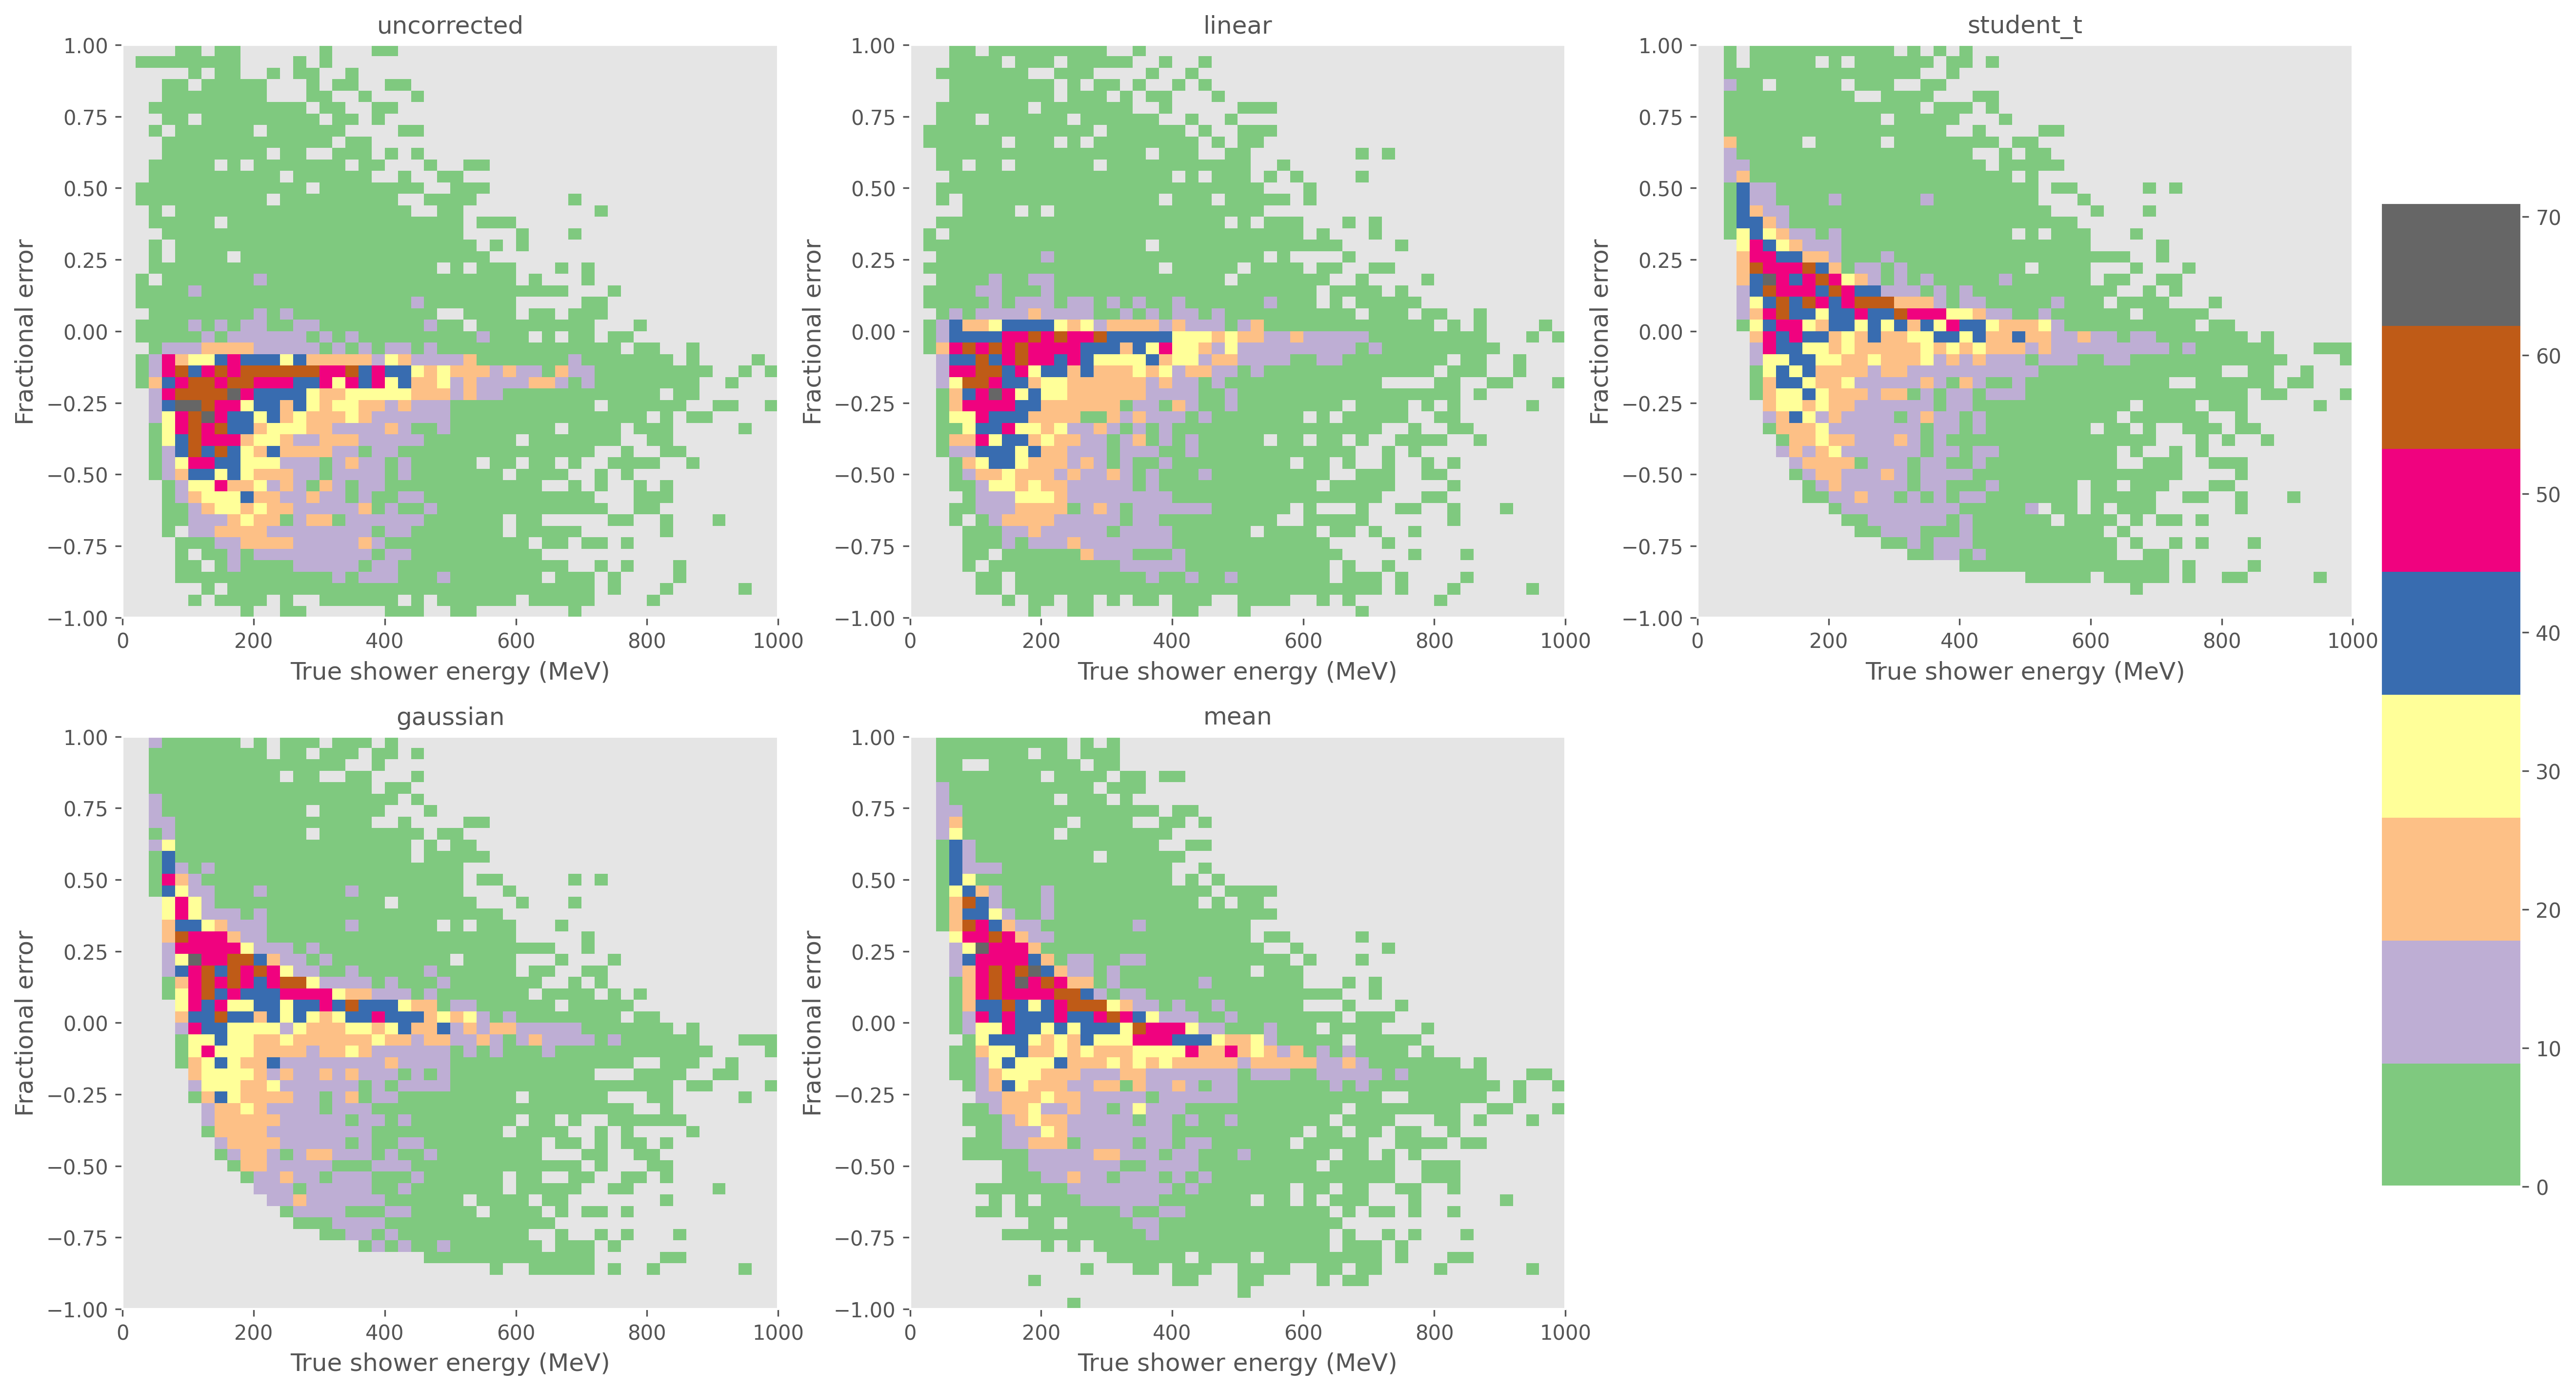

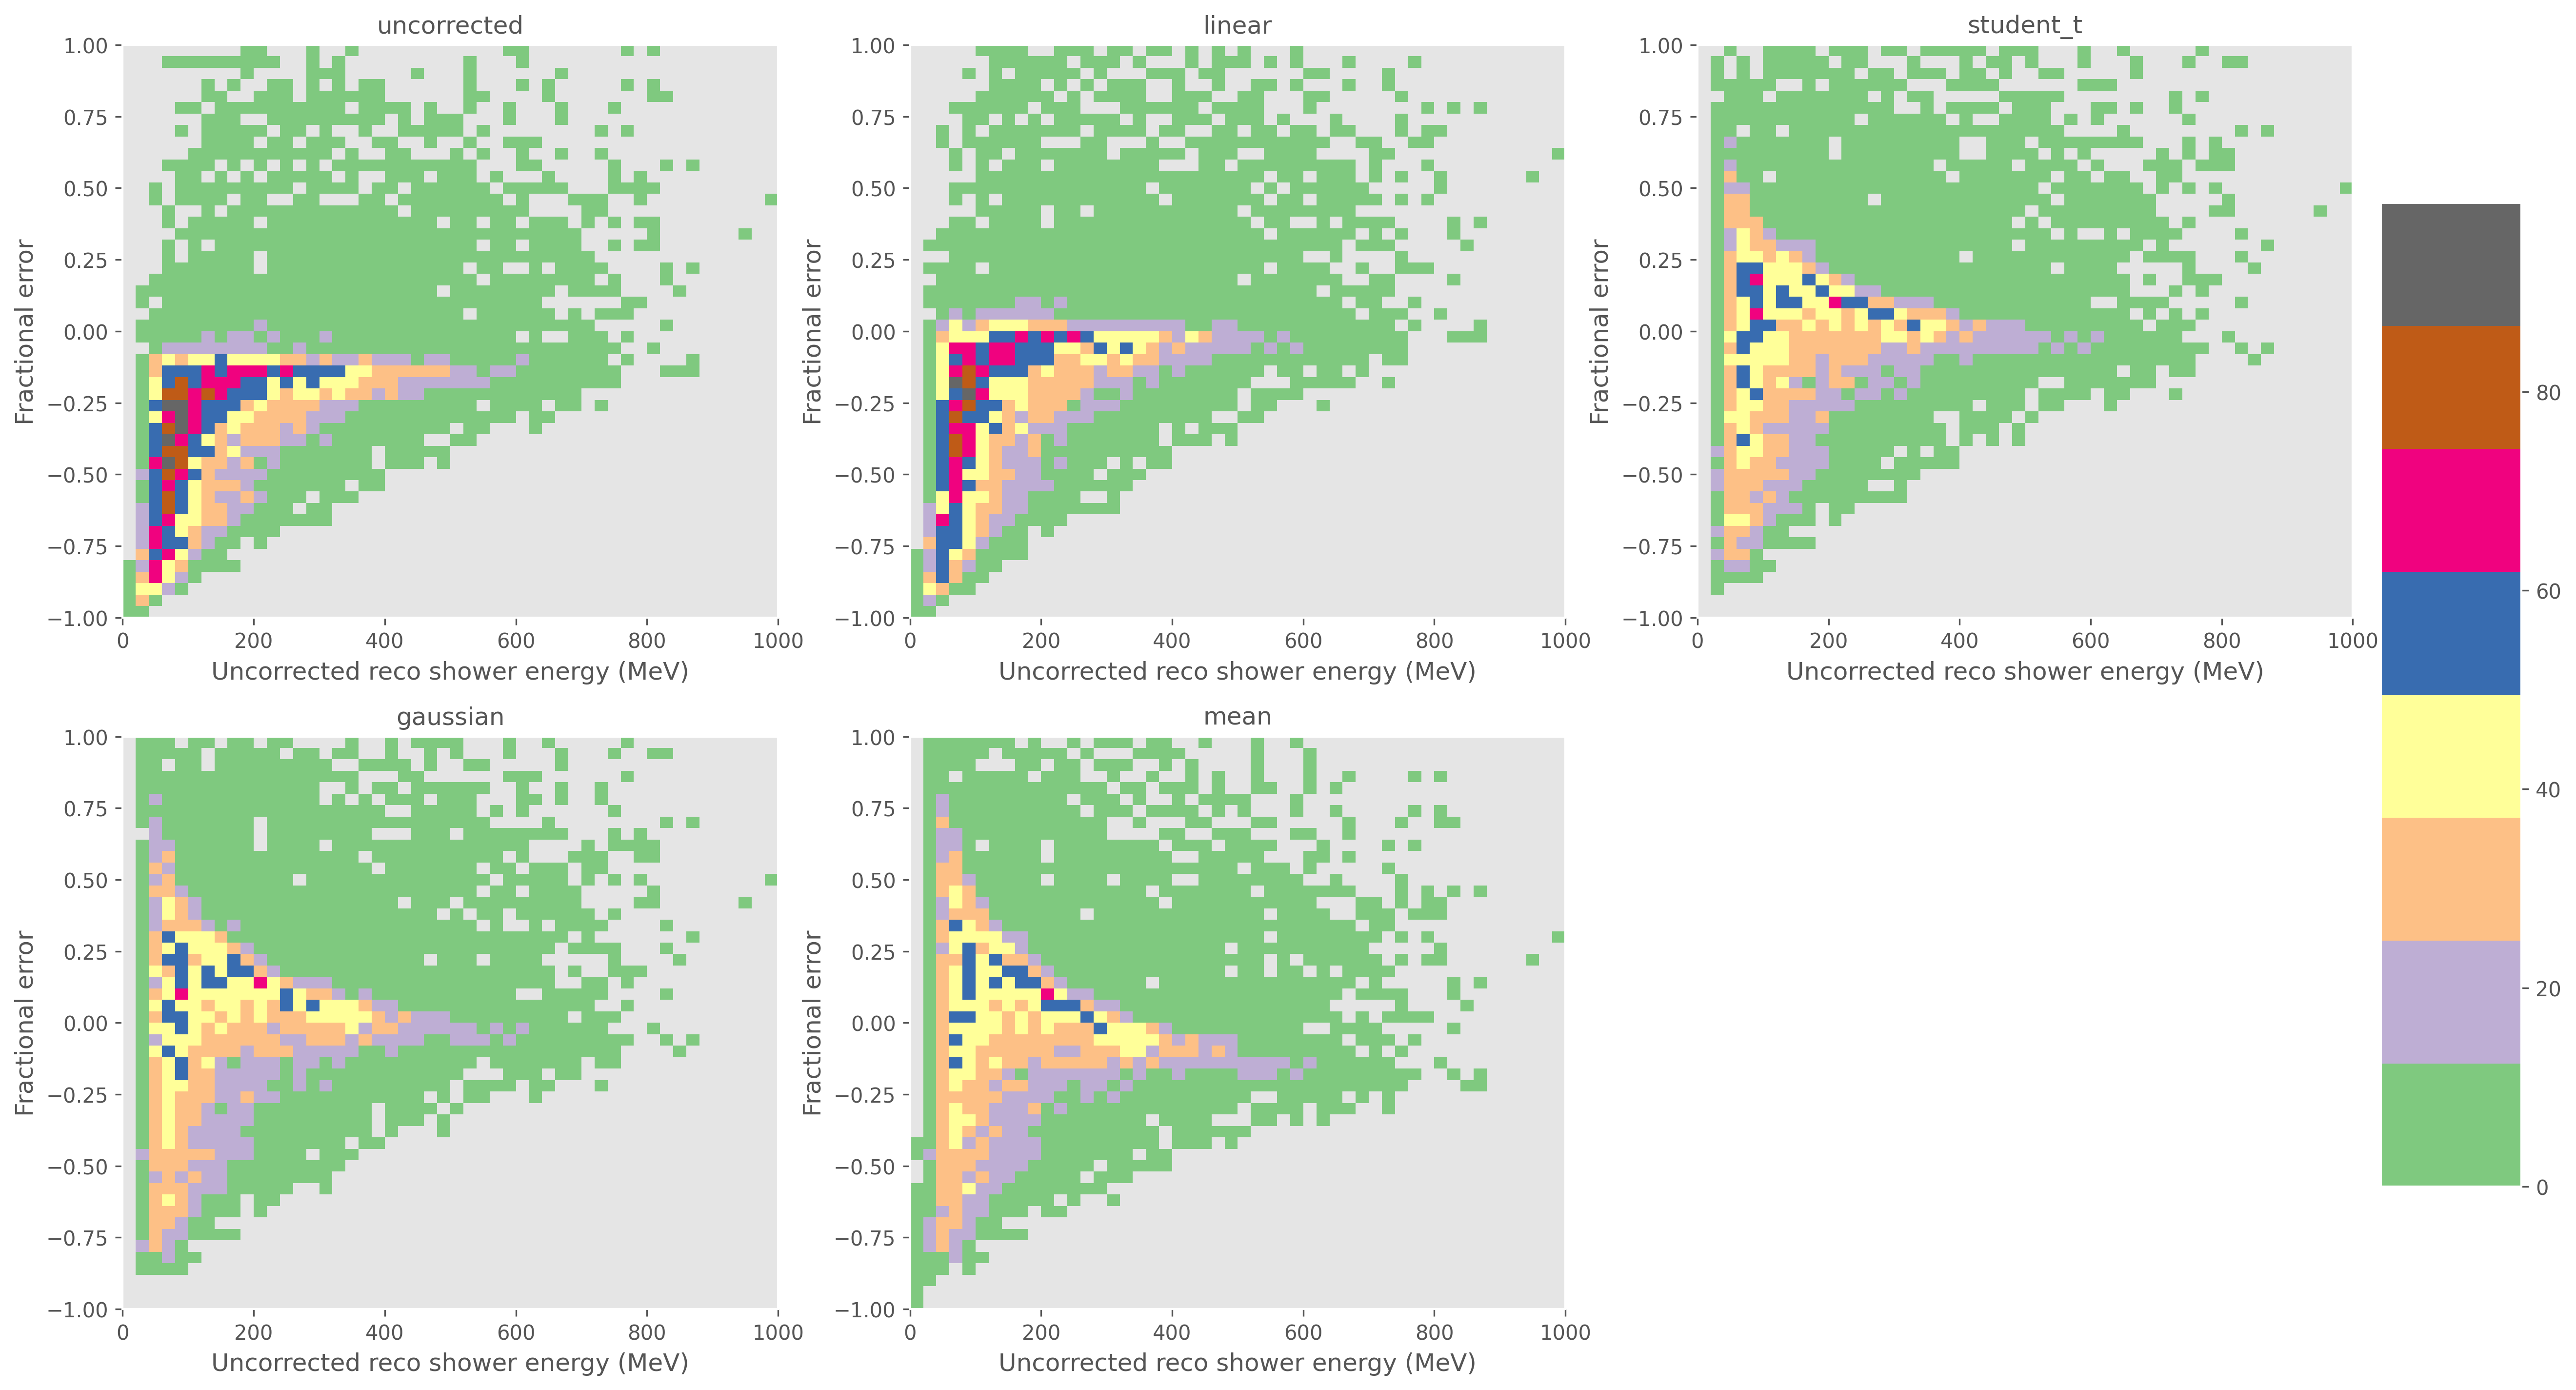

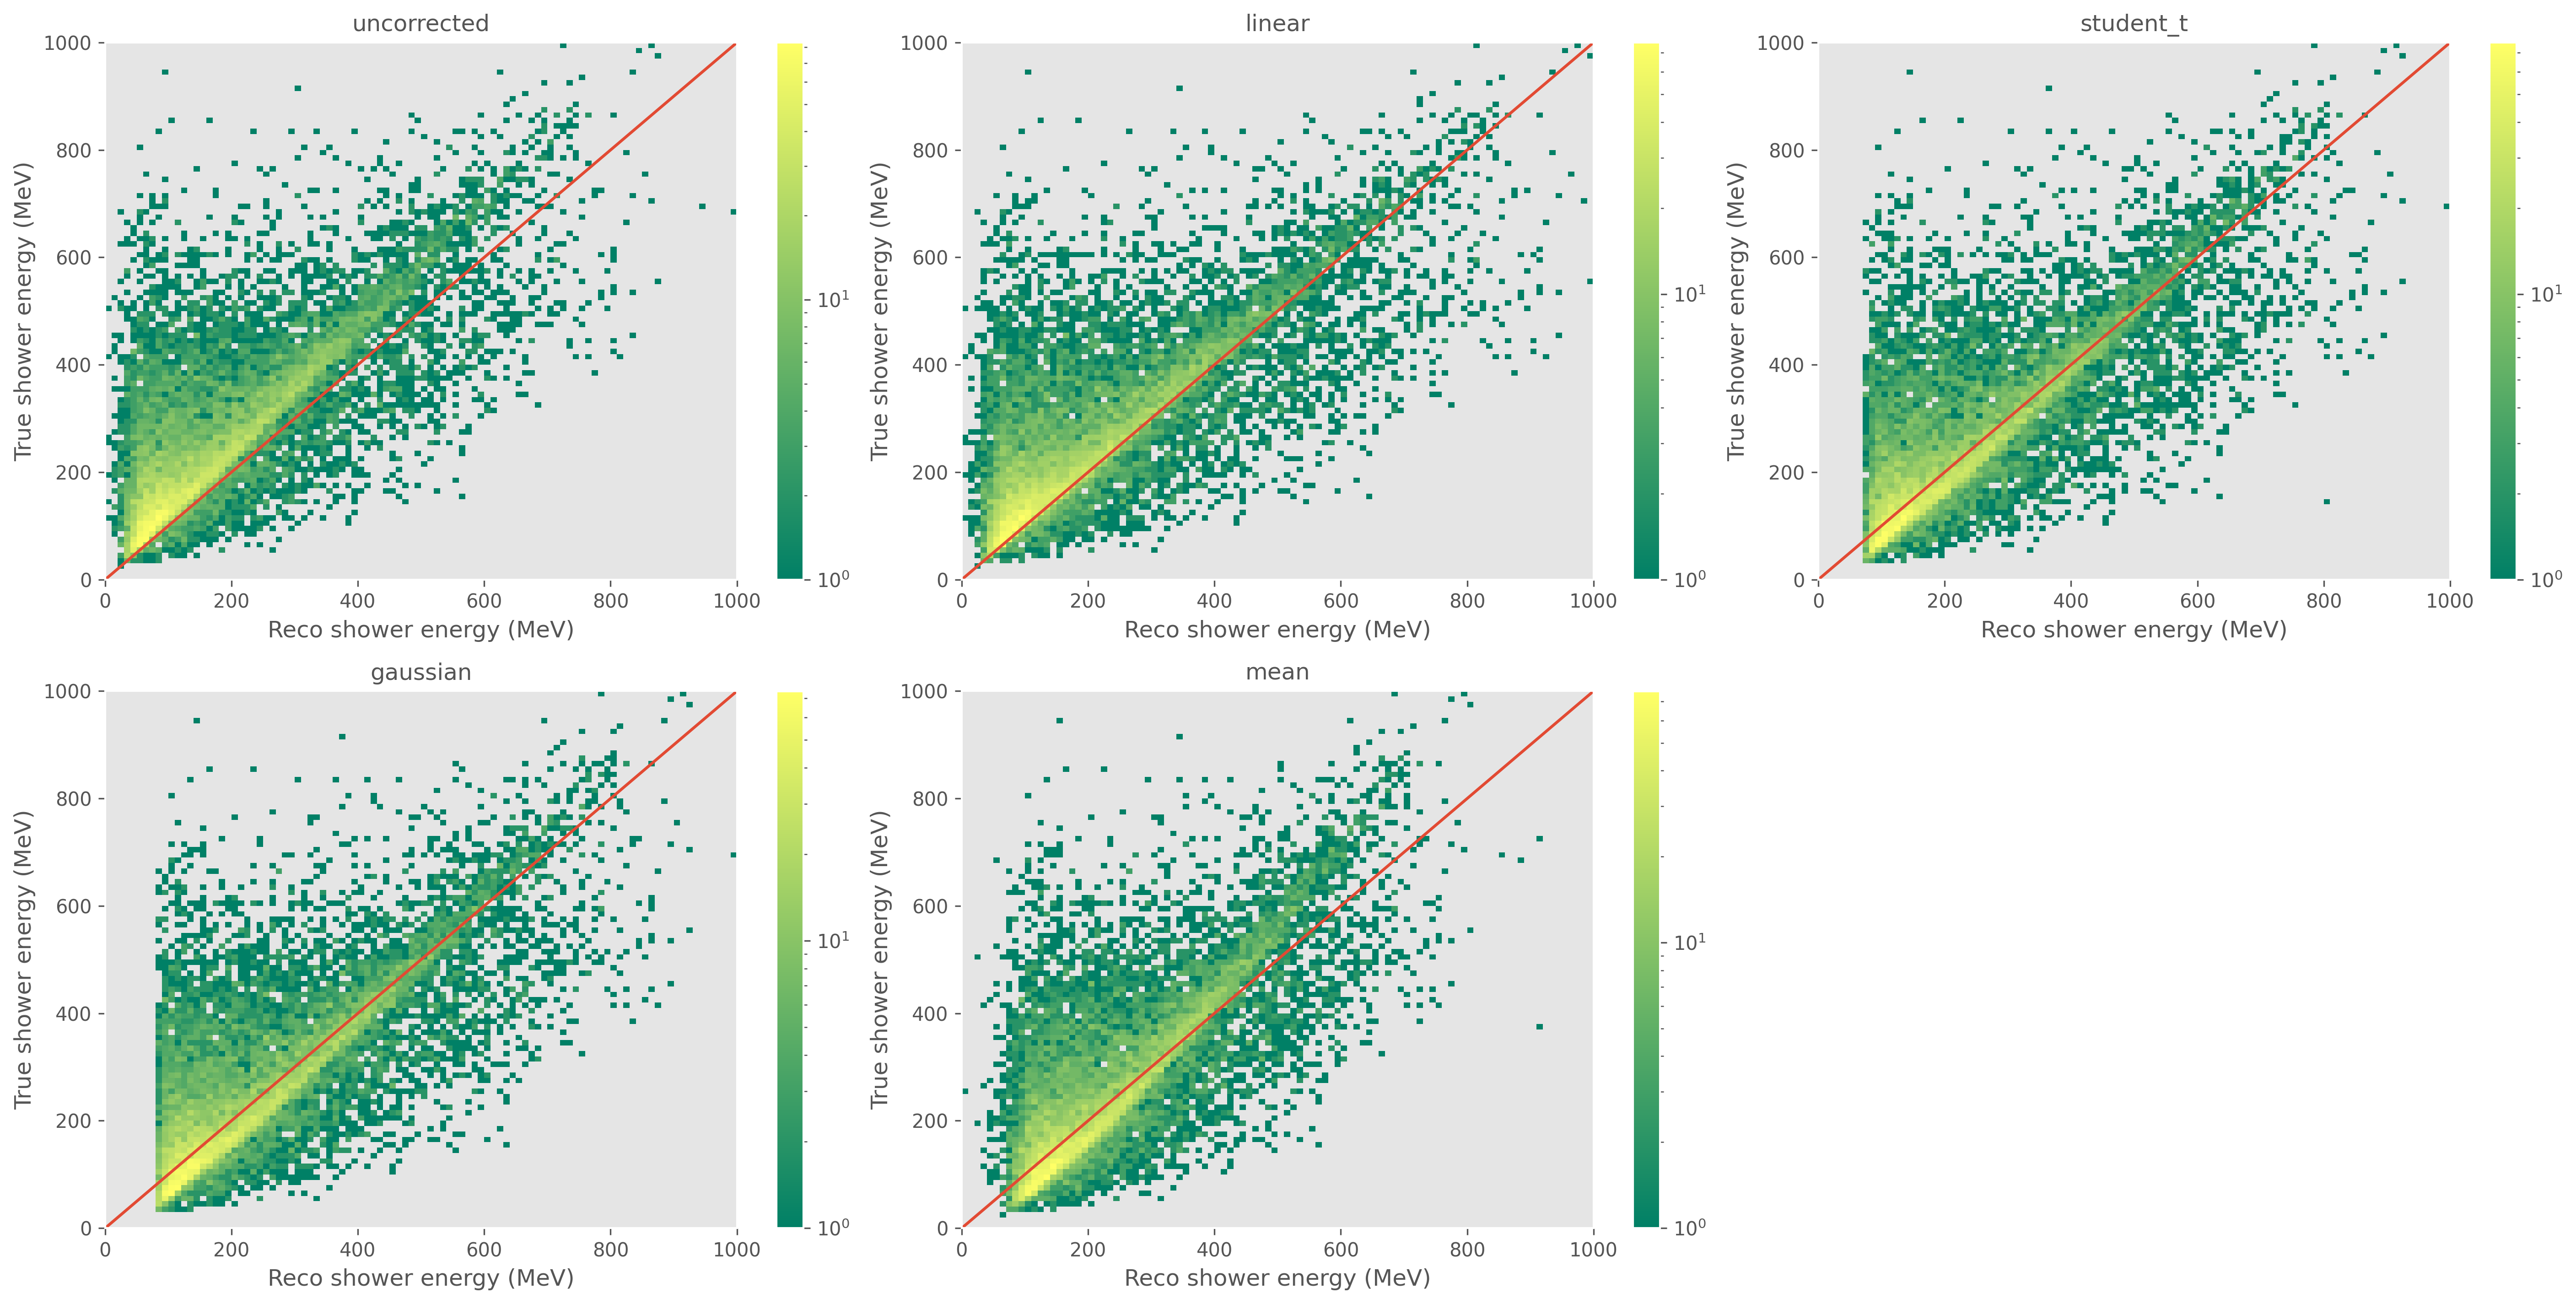

In [34]:
energies = {"uncorrected" : df.reco_energy, "linear" : df.reco_energy / linear_correction}

for p in response_params:
    energies[p] = cross_section.EnergyCorrection.ResponseCorrection(df.reco_energy, *response_params[p])

Plots.PlotHistComparison(list(energies.values()), labels = list(energies.keys()), xRange = energy_range, xlabel = "Shower energy (MeV)")

fe = {i : (energies[i]/df.true_energy) - 1 for i in energies}

Plots.PlotHist2DComparison([df.true_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", x_labels = ["True shower energy (MeV)"]*len(fe), y_labels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
if save is True: Plots.Save("fraction_error_all", path)

Plots.PlotHist2DComparison([df.reco_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", x_labels = ["Uncorrected reco shower energy (MeV)"]*len(fe), y_labels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
if save is True: Plots.Save("fraction_error_reco_all", path)

for i, (l, e) in Plots.IterMultiPlot(energies.items()):
    Plots.PlotHist2D(e, df.true_energy, bins = 100, title = l, xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)", x_range = energy_range, y_range = energy_range, cmap = "summer", newFigure = False)
    plt.plot(energy_range, energy_range)
if save is True: Plots.Save("truth_reco_all", path)

for l, f in fe.items():
    print(f"{l} : mean {f.mean():.3f} std {f.std():.3f}")

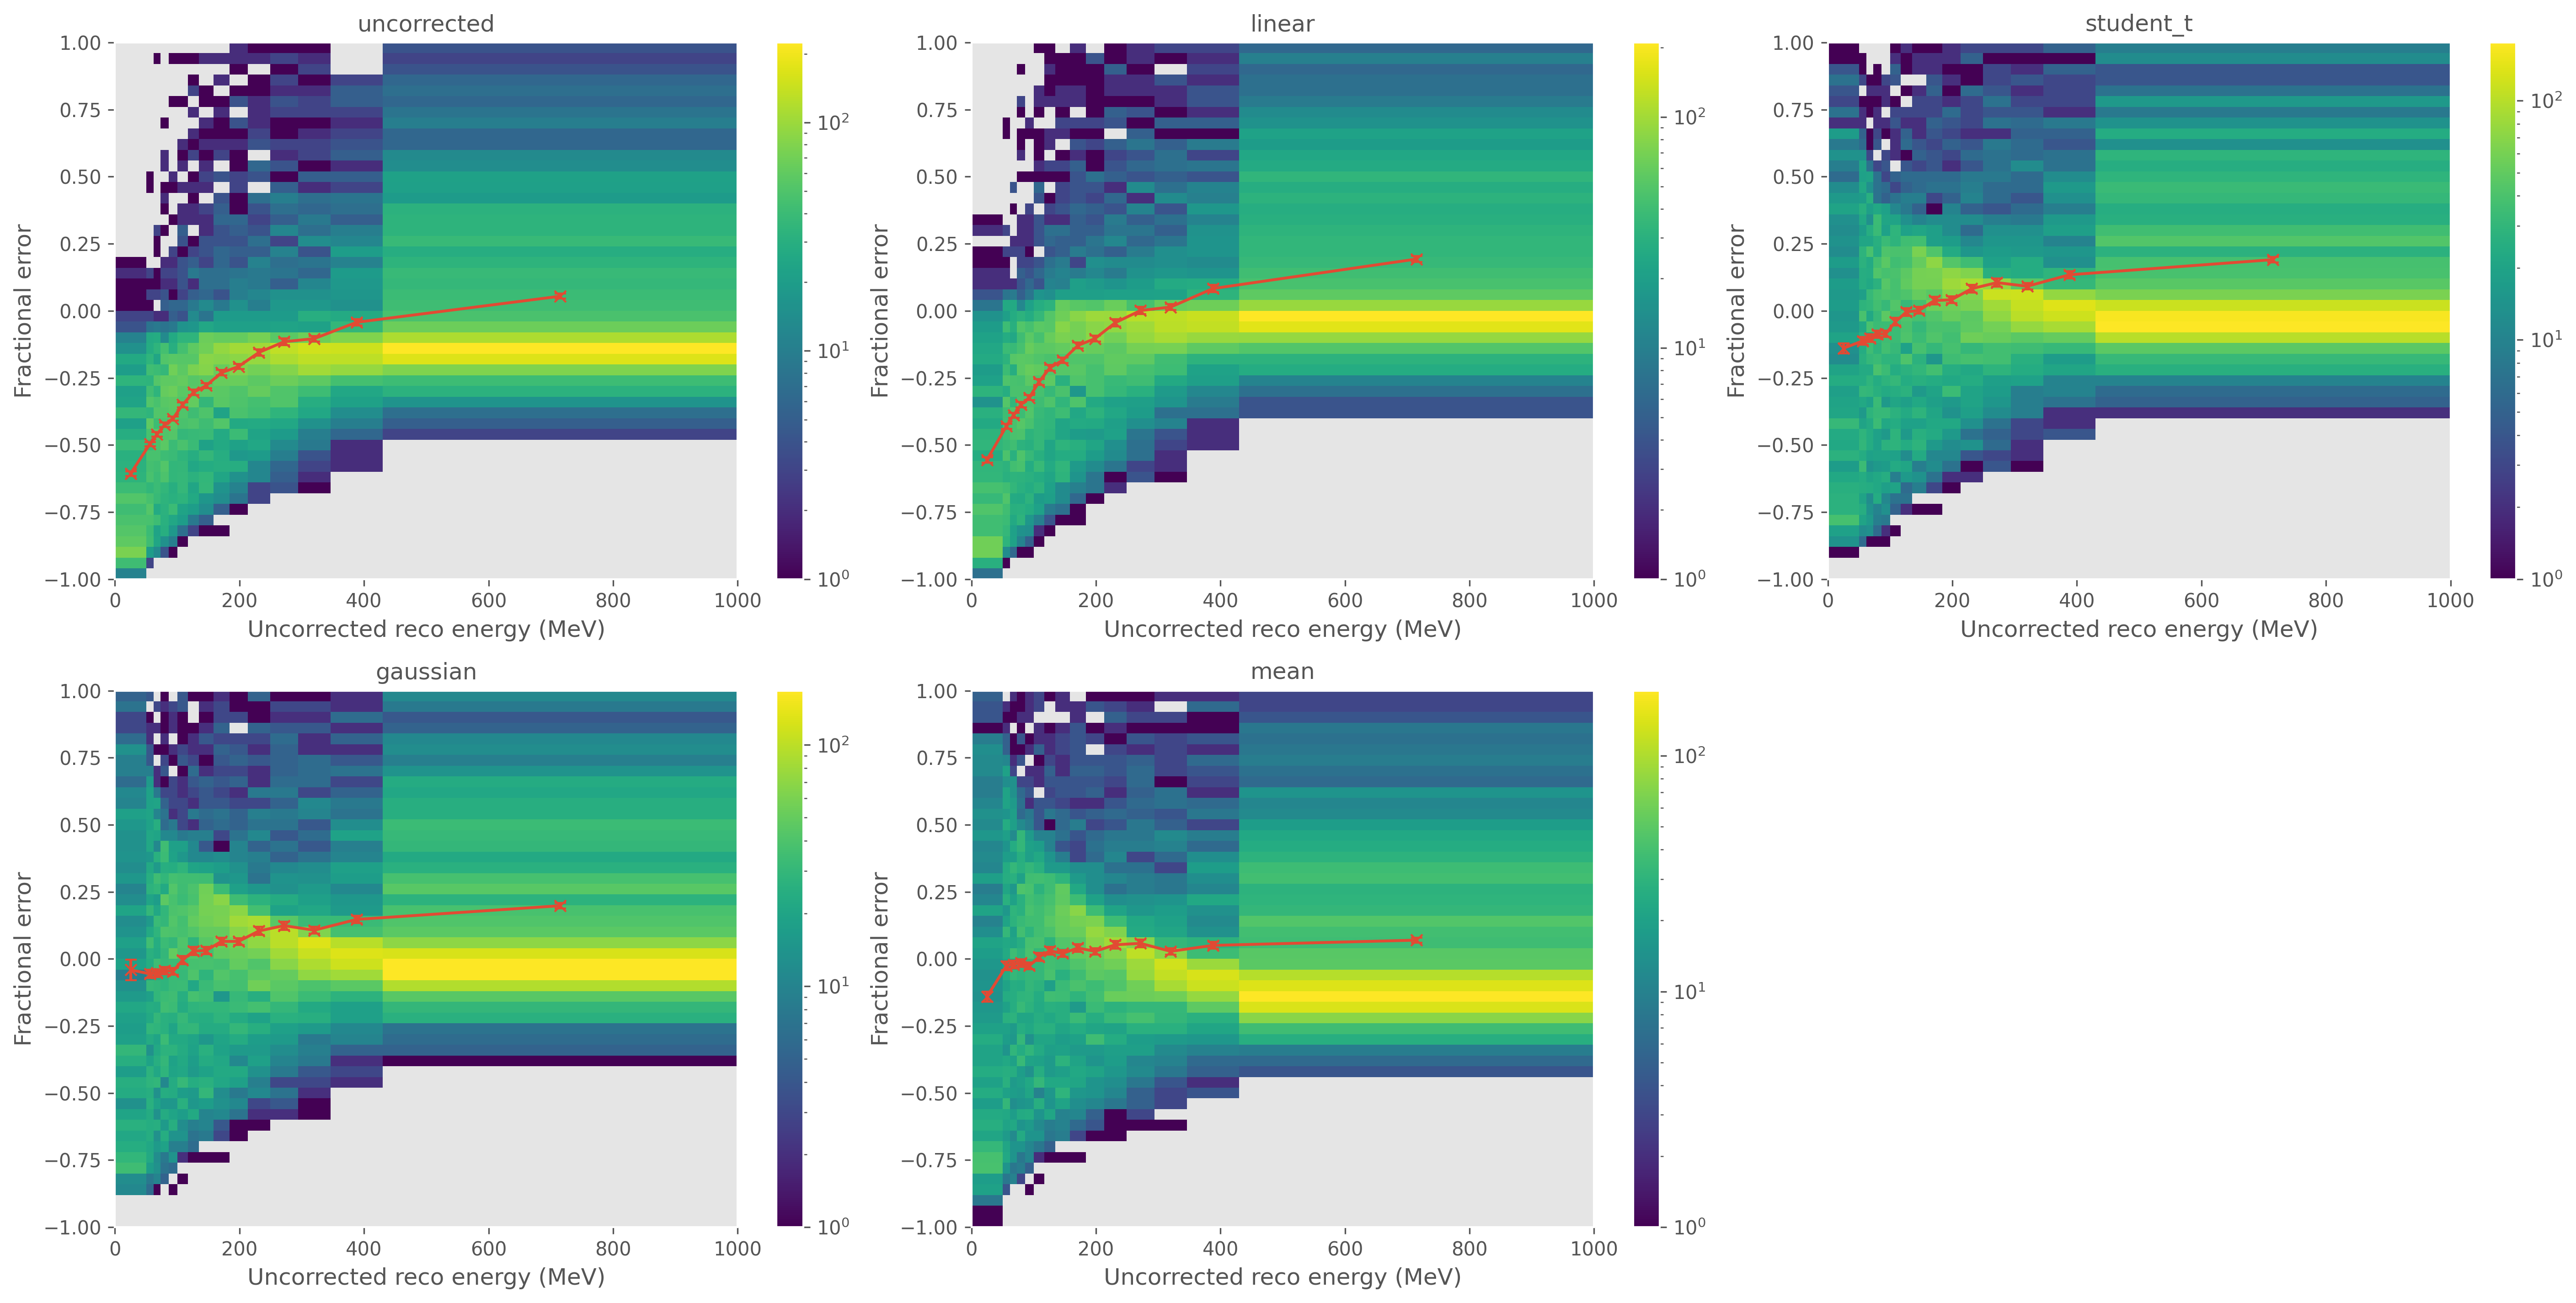

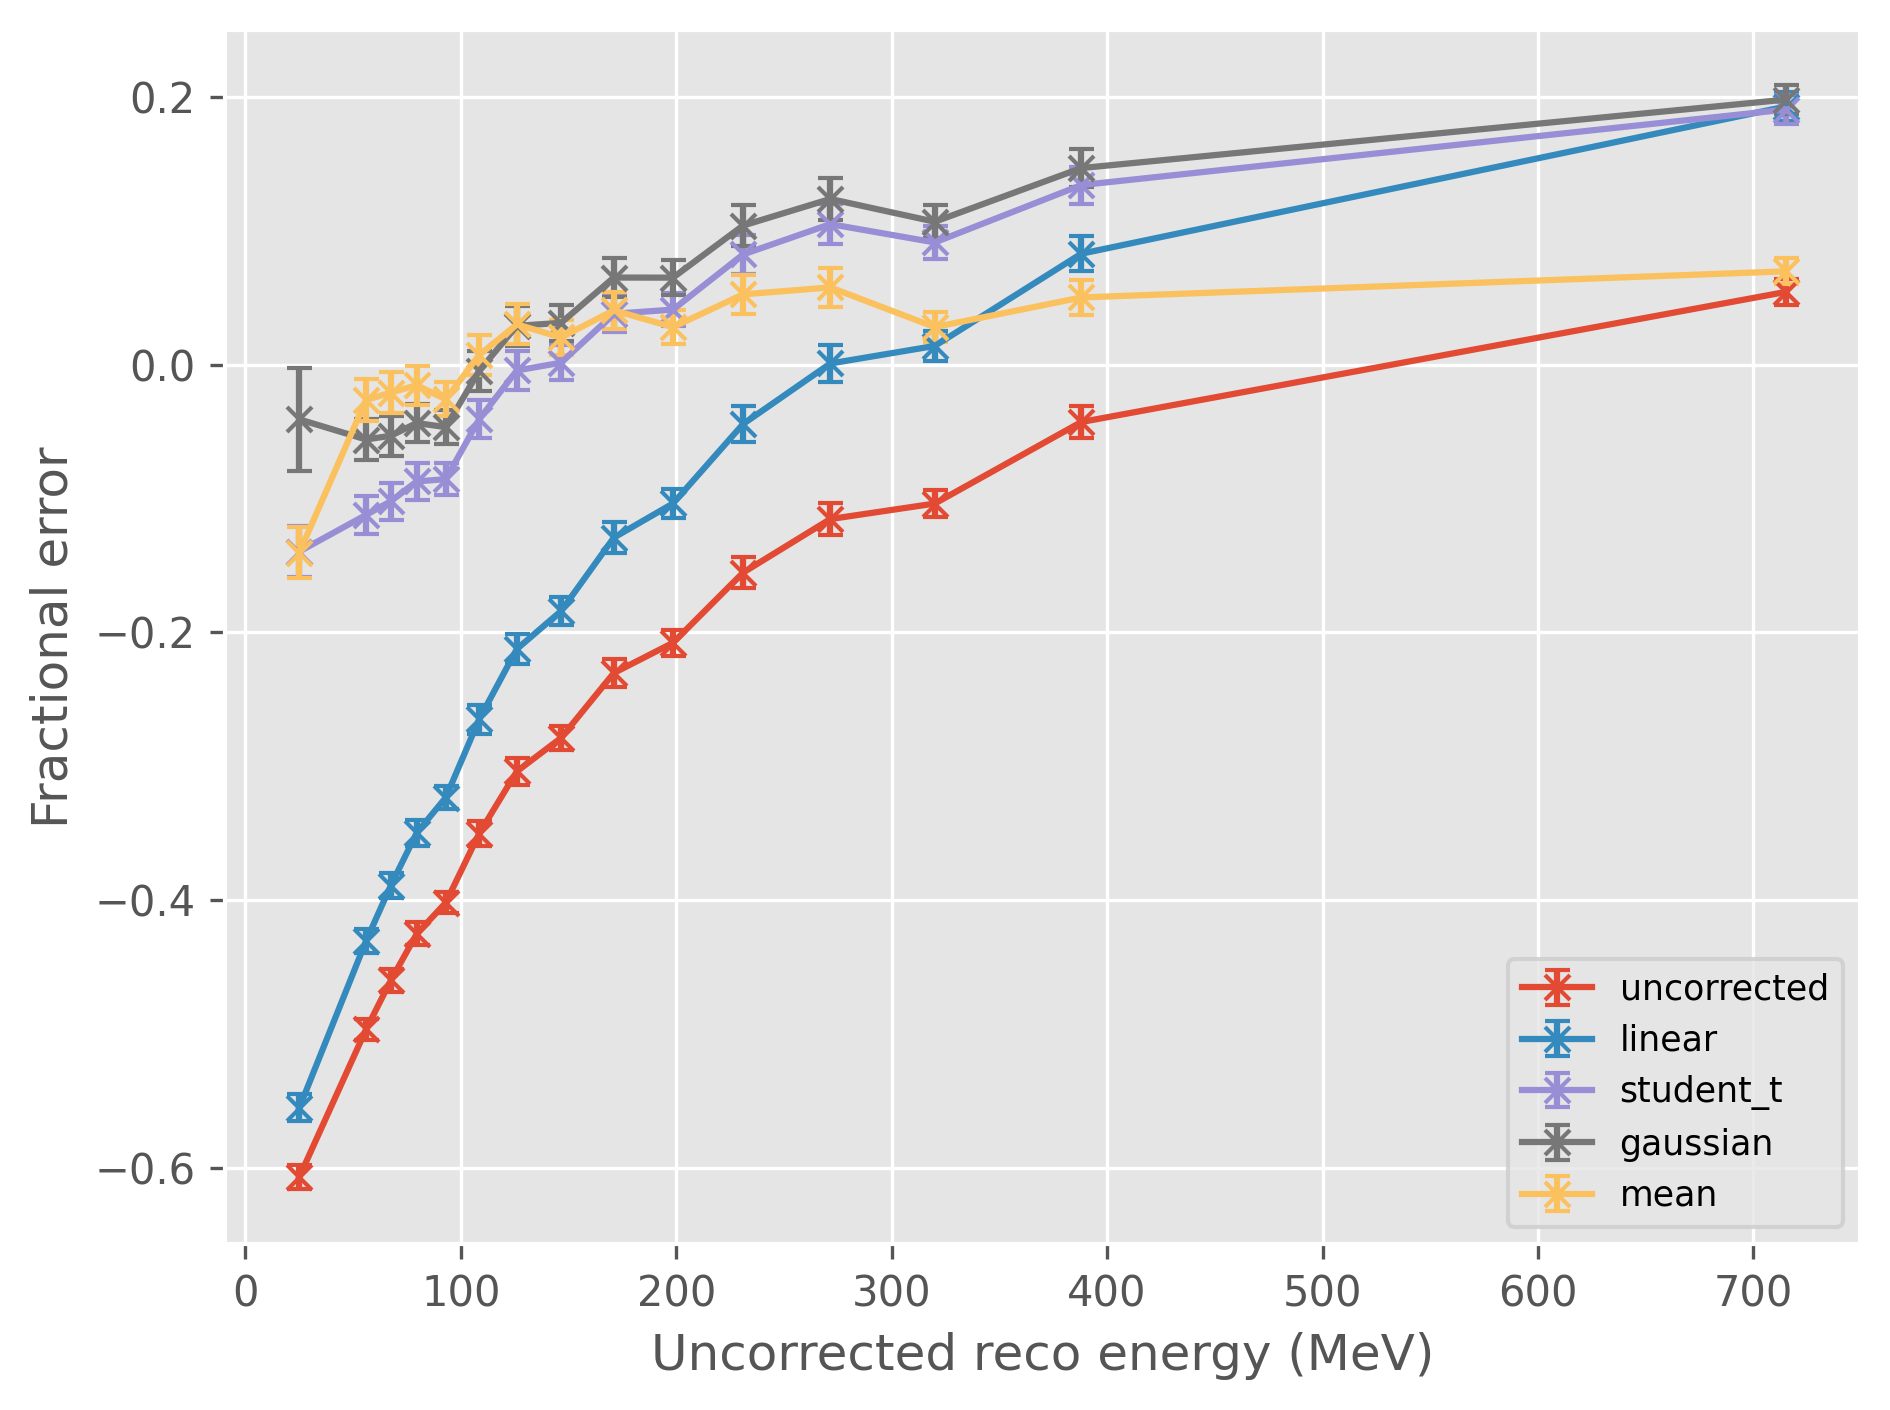

In [49]:
for i, f in Plots.IterMultiPlot(fe):
    binned_data = [fe[f][(df.reco_energy > bins[i + 0]) & (df.reco_energy < bins[i + 1])] for i in range(len(bins)-1)]

    mean = [d.mean() for d in binned_data]
    sem = [d.std()/(len(d)**0.5) for d in binned_data]
    Plots.Plot((bins[1:] + bins[:-1]) / 2, mean, yerr = sem, marker = "x", capsize = 3, newFigure = False)
    Plots.PlotHist2D(df.reco_energy, fe[f], bins = [bins, 50], x_range = energy_range, y_range = [-1, 1], newFigure = False, xlabel = "Uncorrected reco energy (MeV)", ylabel = "Fractional error", title = f)


plt.figure()
for i, f in enumerate(fe):
    binned_data = [fe[f][(df.reco_energy > bins[i + 0]) & (df.reco_energy < bins[i + 1])] for i in range(len(bins)-1)]
    mean = [d.mean() for d in binned_data]
    sem = [d.std()/(len(d)**0.5) for d in binned_data]
    Plots.Plot((bins[1:] + bins[:-1]) / 2, mean, yerr = sem, marker = "x", capsize = 3, label = f, newFigure = False)
    plt.xlabel("Uncorrected reco energy (MeV)")
    plt.ylabel("Fractional error")
    plt.legend()


# Performance

In [35]:
def UnpackPi0Tags(tags : pd.DataFrame) -> Tags.Tags:
    """ Read tags from dataframe to Tags object.

    Args:
        tags (pd.DataFrame): pi0 tags from file

    Returns:
        Tags.Tags: pi0 tags
    """
    pi0_tags = Tags.Tags()
    for i in range(4):
        pi0_tags[tags.pi0_tags[i].name] = tags.pi0_tags[i]
    return pi0_tags


pairs = pd.read_hdf(photon_file, "photon_pairs")
tags = pd.read_hdf(photon_file, "tags")

mass = {"uncorrected" : Master.ShowerPairs.Mass(pairs.shower_pairs_reco_lead_energy, pairs.shower_pairs_reco_sub_energy, pairs.shower_pairs_reco_angle)}
mass["linear"] = Master.ShowerPairs.Mass(
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_lead_energy, linear_correction), 
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_sub_energy, linear_correction), 
    pairs.shower_pairs_reco_angle
    )

for p in response_params:
    mass[p] = Master.ShowerPairs.Mass(
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_lead_energy, *response_params[p]),
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_sub_energy,  *response_params[p]),
        pairs.shower_pairs_reco_angle
        )

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones


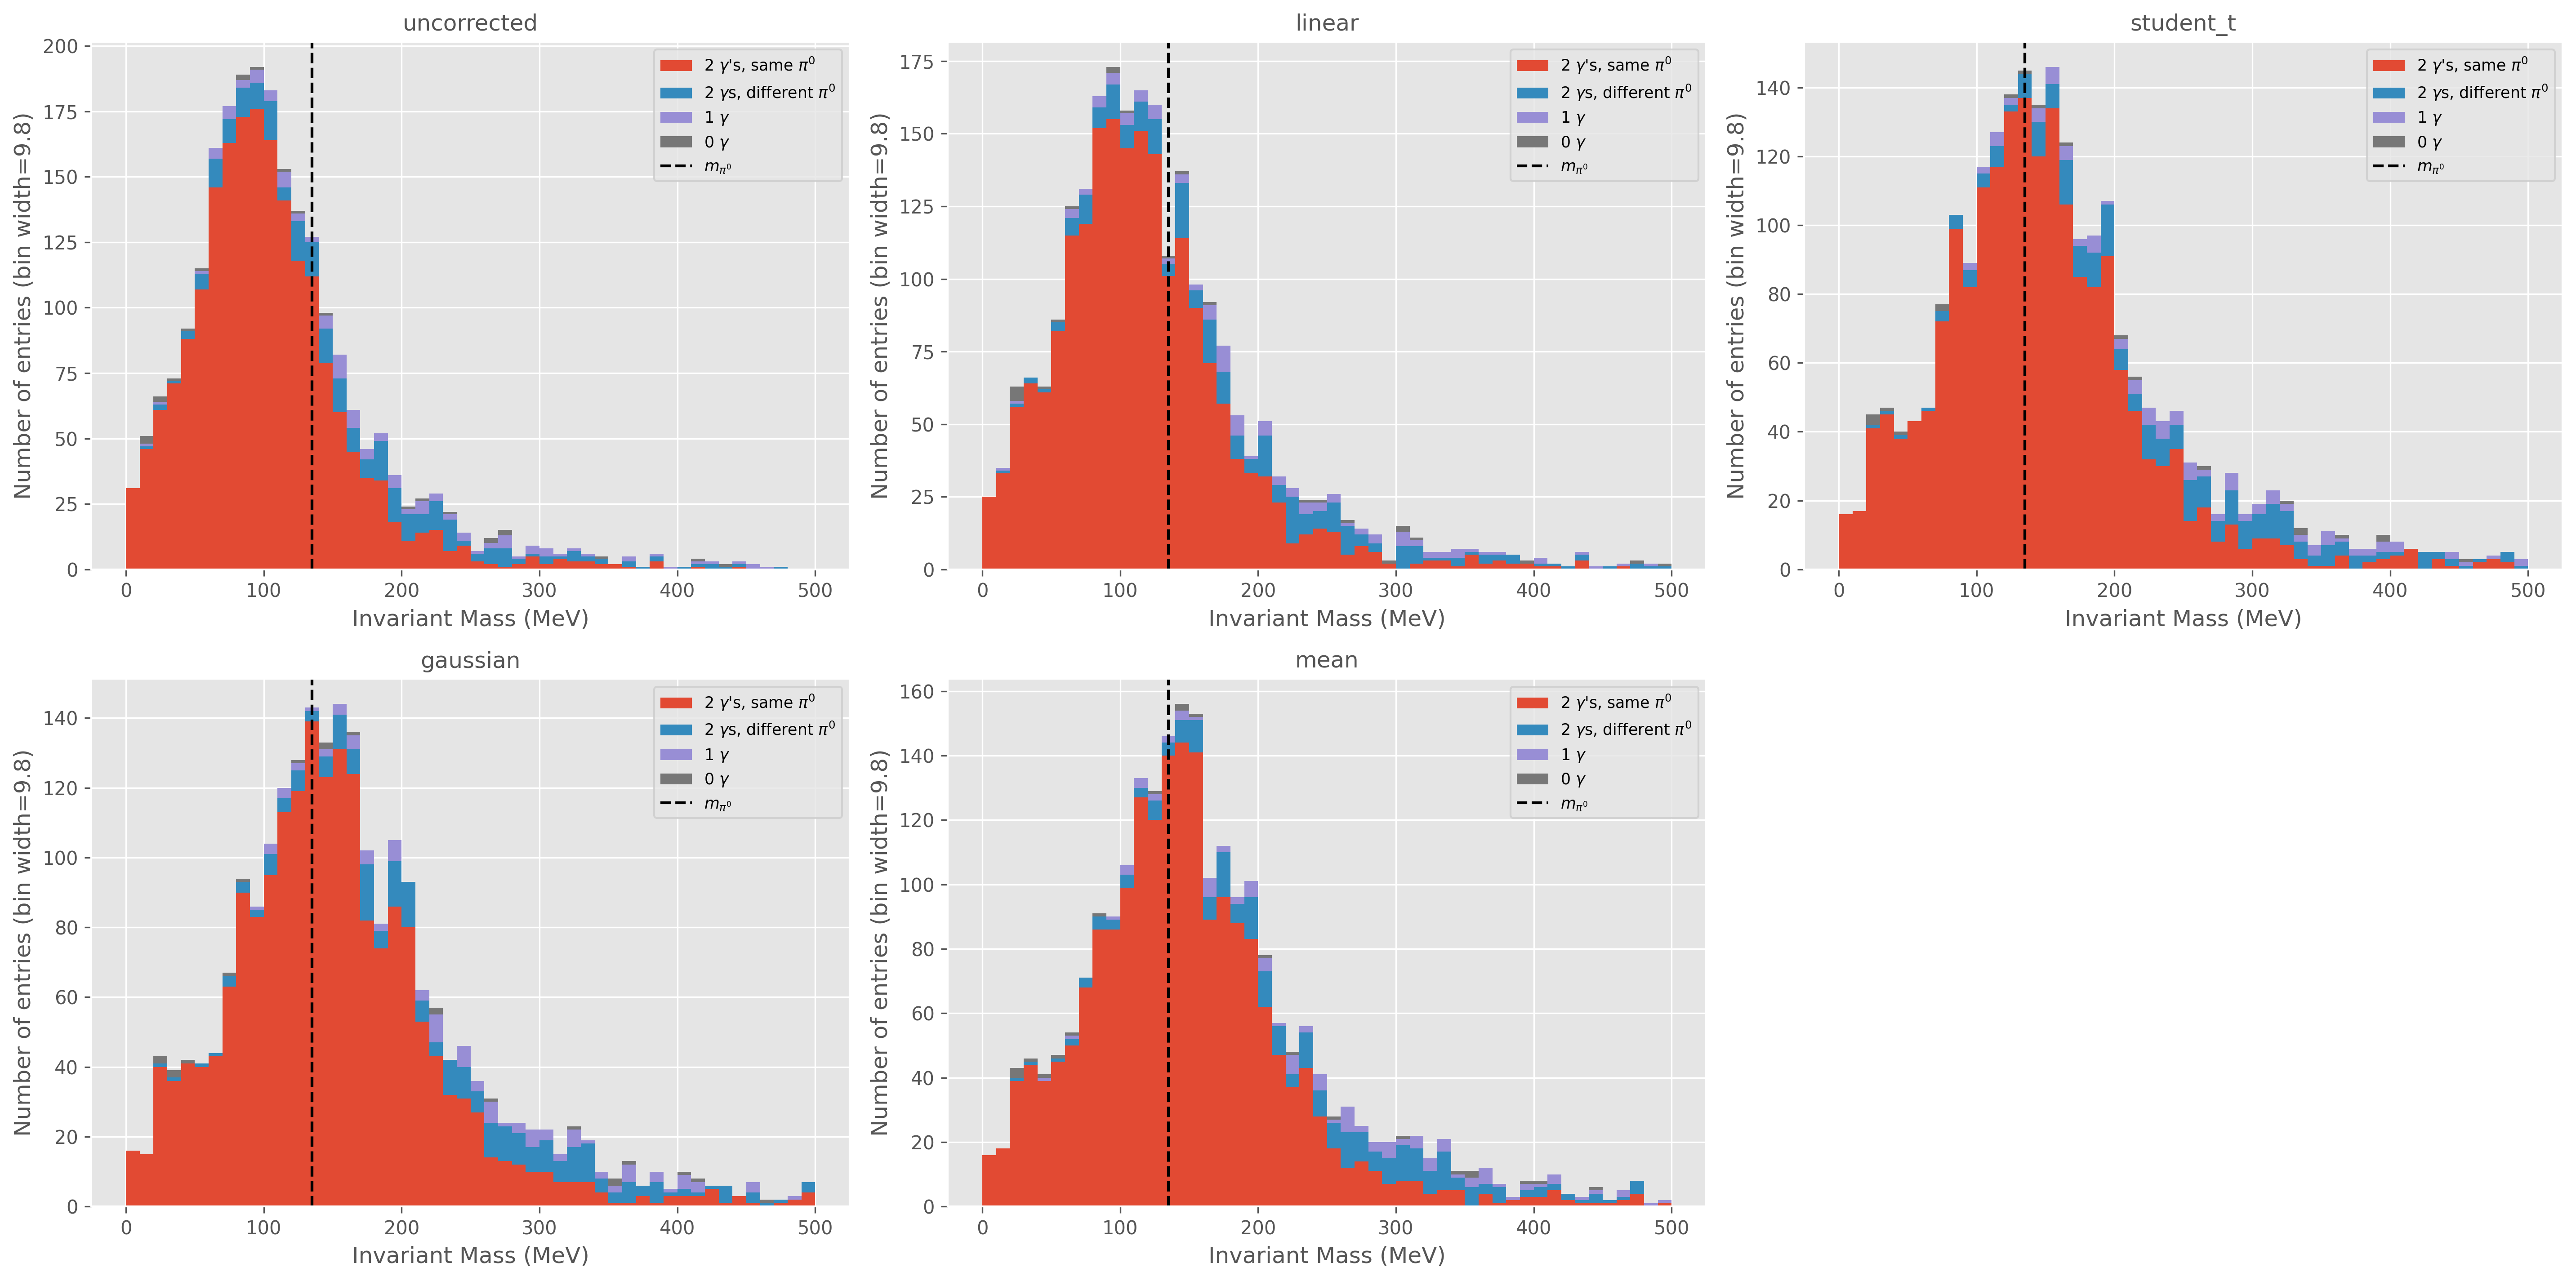

In [38]:
def cut_scan(value : np.array, signal_mask : np.array, nsamples : int = 100) -> tuple:
    """Cut on value, compute purity and efficiency for multiple cut values.

    Args:
        value (np.array): value to cut on
        signal_mask (np.array): mask which defines signal
        nsamples (int, optional): number of cut values to try. Defaults to 100.

    Returns:
        tuple: performance metrics
    """
    cuts = np.nanpercentile(value, np.linspace(1, 99, nsamples))

    s_e = []
    s_p = []
    s_y = []
    b_y = []
    for c in cuts:
        mask = value < c
        s_e.append(np.sum(signal_mask[mask]) / len(signal_mask))
        s_p.append(np.sum(signal_mask[mask]) / len(signal_mask[mask]))
        s_y.append(np.sum(signal_mask[mask]))
        b_y.append(np.sum(~signal_mask[mask]))
        
    s_e = np.array(s_e) # signal efficiency
    s_p = np.array(s_p) # signal purity
    s_y = np.array(s_y) # signal yield
    b_y = np.array(b_y) # background yield
    return s_e, s_p, s_y, b_y, cuts


def optimal_cut(value : np.array, signal_mask : np.array, visualise : bool = False) -> tuple:
    """ Based on metrics from cut_scan, decide which is the best cut value.

    Args:
        value (np.array): value cut on
        signal_mask (np.array): mask which defines signal
        visualise (bool, optional): make plots. Defaults to False.

    Returns:
        tuple: optimal cut and the signal purity and efficiency at that cut
    """

    s_e, s_p, _, _, cuts = cut_scan(value, signal_mask)
    score = s_e * s_p

    best = np.nanargmax(score)
    optimal = cuts[best]

    if visualise:
        Plots.PlotComparison([cuts]*3, [s_e, s_p, score], labels = ["efficiency", "purity", "purity $\\times$ efficiency"], newFigure = False)
        plt.axvline(optimal, linestyle = "--", color = "black", label = f"optimal cut: {optimal:.0f}")
        plt.xlabel("value")
        plt.legend()
        plt.ylim(0, 1)
    return optimal, s_p[best], s_e[best]


def mass_tag_plots(tags : Tags.Tags):
    """ Plot shower pair invariant mass and plot where the optimal cut position would be, for each correction method.

    Args:
        tags (Tags.Tags): _description_
    """
    for i, (l, m) in Plots.IterMultiPlot(mass.items()):
        Plots.PlotTagged(m, tags, title = l, x_range = [0, 500], bins = 50, newFigure = False, x_label = "Invariant Mass (MeV)")
        cut_position, purity, efficiency = optimal_cut(m, tags.number[0].mask)
        plt.axvline(Particle.from_pdgid(111).mass, color = "black", linestyle = "--", label = "$m_{\pi^{0}}$")
        plt.legend()

pi0_tags = UnpackPi0Tags(tags)

mass_tag_plots(pi0_tags)
if save is True: Plots.Save("inv_mass_pi0", path)


In [52]:
counts = {}
purities = {}
efficiencies = {}
for m in mass:
    print(m)
    cut_position, _, _ = optimal_cut(mass[m], pi0_tags.number[0].mask)
    mask = mass[m] < cut_position

    c = {}
    p = {}
    e = {}
    for t in pi0_tags:
        c[t] = np.sum(pi0_tags[t].mask[mask])
        e[t] = np.sum(pi0_tags[t].mask[mask])/np.sum(pi0_tags[t].mask)
        p[t] = np.sum(pi0_tags[t].mask[mask])/len(pi0_tags[t].mask[mask])
    purities[m] = p
    counts[m] = c
    efficiencies[m] = e

no_cut_counts = {t : np.sum(pi0_tags[t].mask) for t in pi0_tags}
no_cut_purity = {t : np.sum(pi0_tags[t].mask)/len(pi0_tags[t].mask) for t in pi0_tags}

counts = pd.DataFrame(counts)
counts["before cut"] = no_cut_counts
counts.loc["total"] = counts.sum(axis = "rows")
efficiencies = pd.DataFrame(efficiencies)
efficiencies.loc["total"] = efficiencies.sum(axis = "rows")

purities = pd.DataFrame(purities)
purities["before cut"] = no_cut_purity
purities.loc["total"] = purities.sum(axis = "rows")

if save:
    counts.to_latex(path + "mass_perf_counts.tex")
    purities.to_latex(path + "mass_perf_purity.tex")
    efficiencies.to_latex(path + "mass_perf_efficiency.tex")

print(counts)
print(purities)
print(efficiencies)


uncorrected

linear

student_t

gaussian

mean

uncorrected  linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$             1929    1929       1864      1865   
2 $\gamma$s, different $\pi^{0}$          218     218        169       168   
1 $\gamma$                                 84      84         63        63   
0 $\gamma$                                 18      18         14        14   
total                                    2249    2249       2110      2110   

                                  mean  before cut  
2 $\gamma$'s, same $\pi^{0}$      1888        1962  
2 $\gamma$s, different $\pi^{0}$   165         259  
1 $\gamma$                          64         115  
0 $\gamma$                          15          31  
total                             2132        2367

uncorrected    linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$         0.857715  0.857715   0.883412  0.883886   
2 $\gamma$s, different $\pi^{0}$     0.096932  0.096932   0.080095  0.079621   
1 $\gamma$                           0.037350  0.037350   0.029858  0.029858   
0 $\gamma$                           0.008004  0.008004   0.006635  0.006635   
total                                1.000000  1.000000   1.000000  1.000000   

                                      mean  before cut  
2 $\gamma$'s, same $\pi^{0}$      0.885553    0.828897  
2 $\gamma$s, different $\pi^{0}$  0.077392    0.109421  
1 $\gamma$                        0.030019    0.048585  
0 $\gamma$                        0.007036    0.013097  
total                             1.000000    1.000000

uncorrected    linear  student_t  gaussian  \
2 $\gamma$'s, same $\pi^{0}$         0.983180  0.983180   0.950051  0.950561   
2 $\gamma$s, different $\pi^{0}$     0.841699  0.841699   0.652510  0.648649   
1 $\gamma$                           0.730435  0.730435   0.547826  0.547826   
0 $\gamma$                           0.580645  0.580645   0.451613  0.451613   
total                                3.135959  3.135959   2.602000  2.598648   

                                      mean  
2 $\gamma$'s, same $\pi^{0}$      0.962283  
2 $\gamma$s, different $\pi^{0}$  0.637066  
1 $\gamma$                        0.556522  
0 $\gamma$                        0.483871  
total                             2.639742

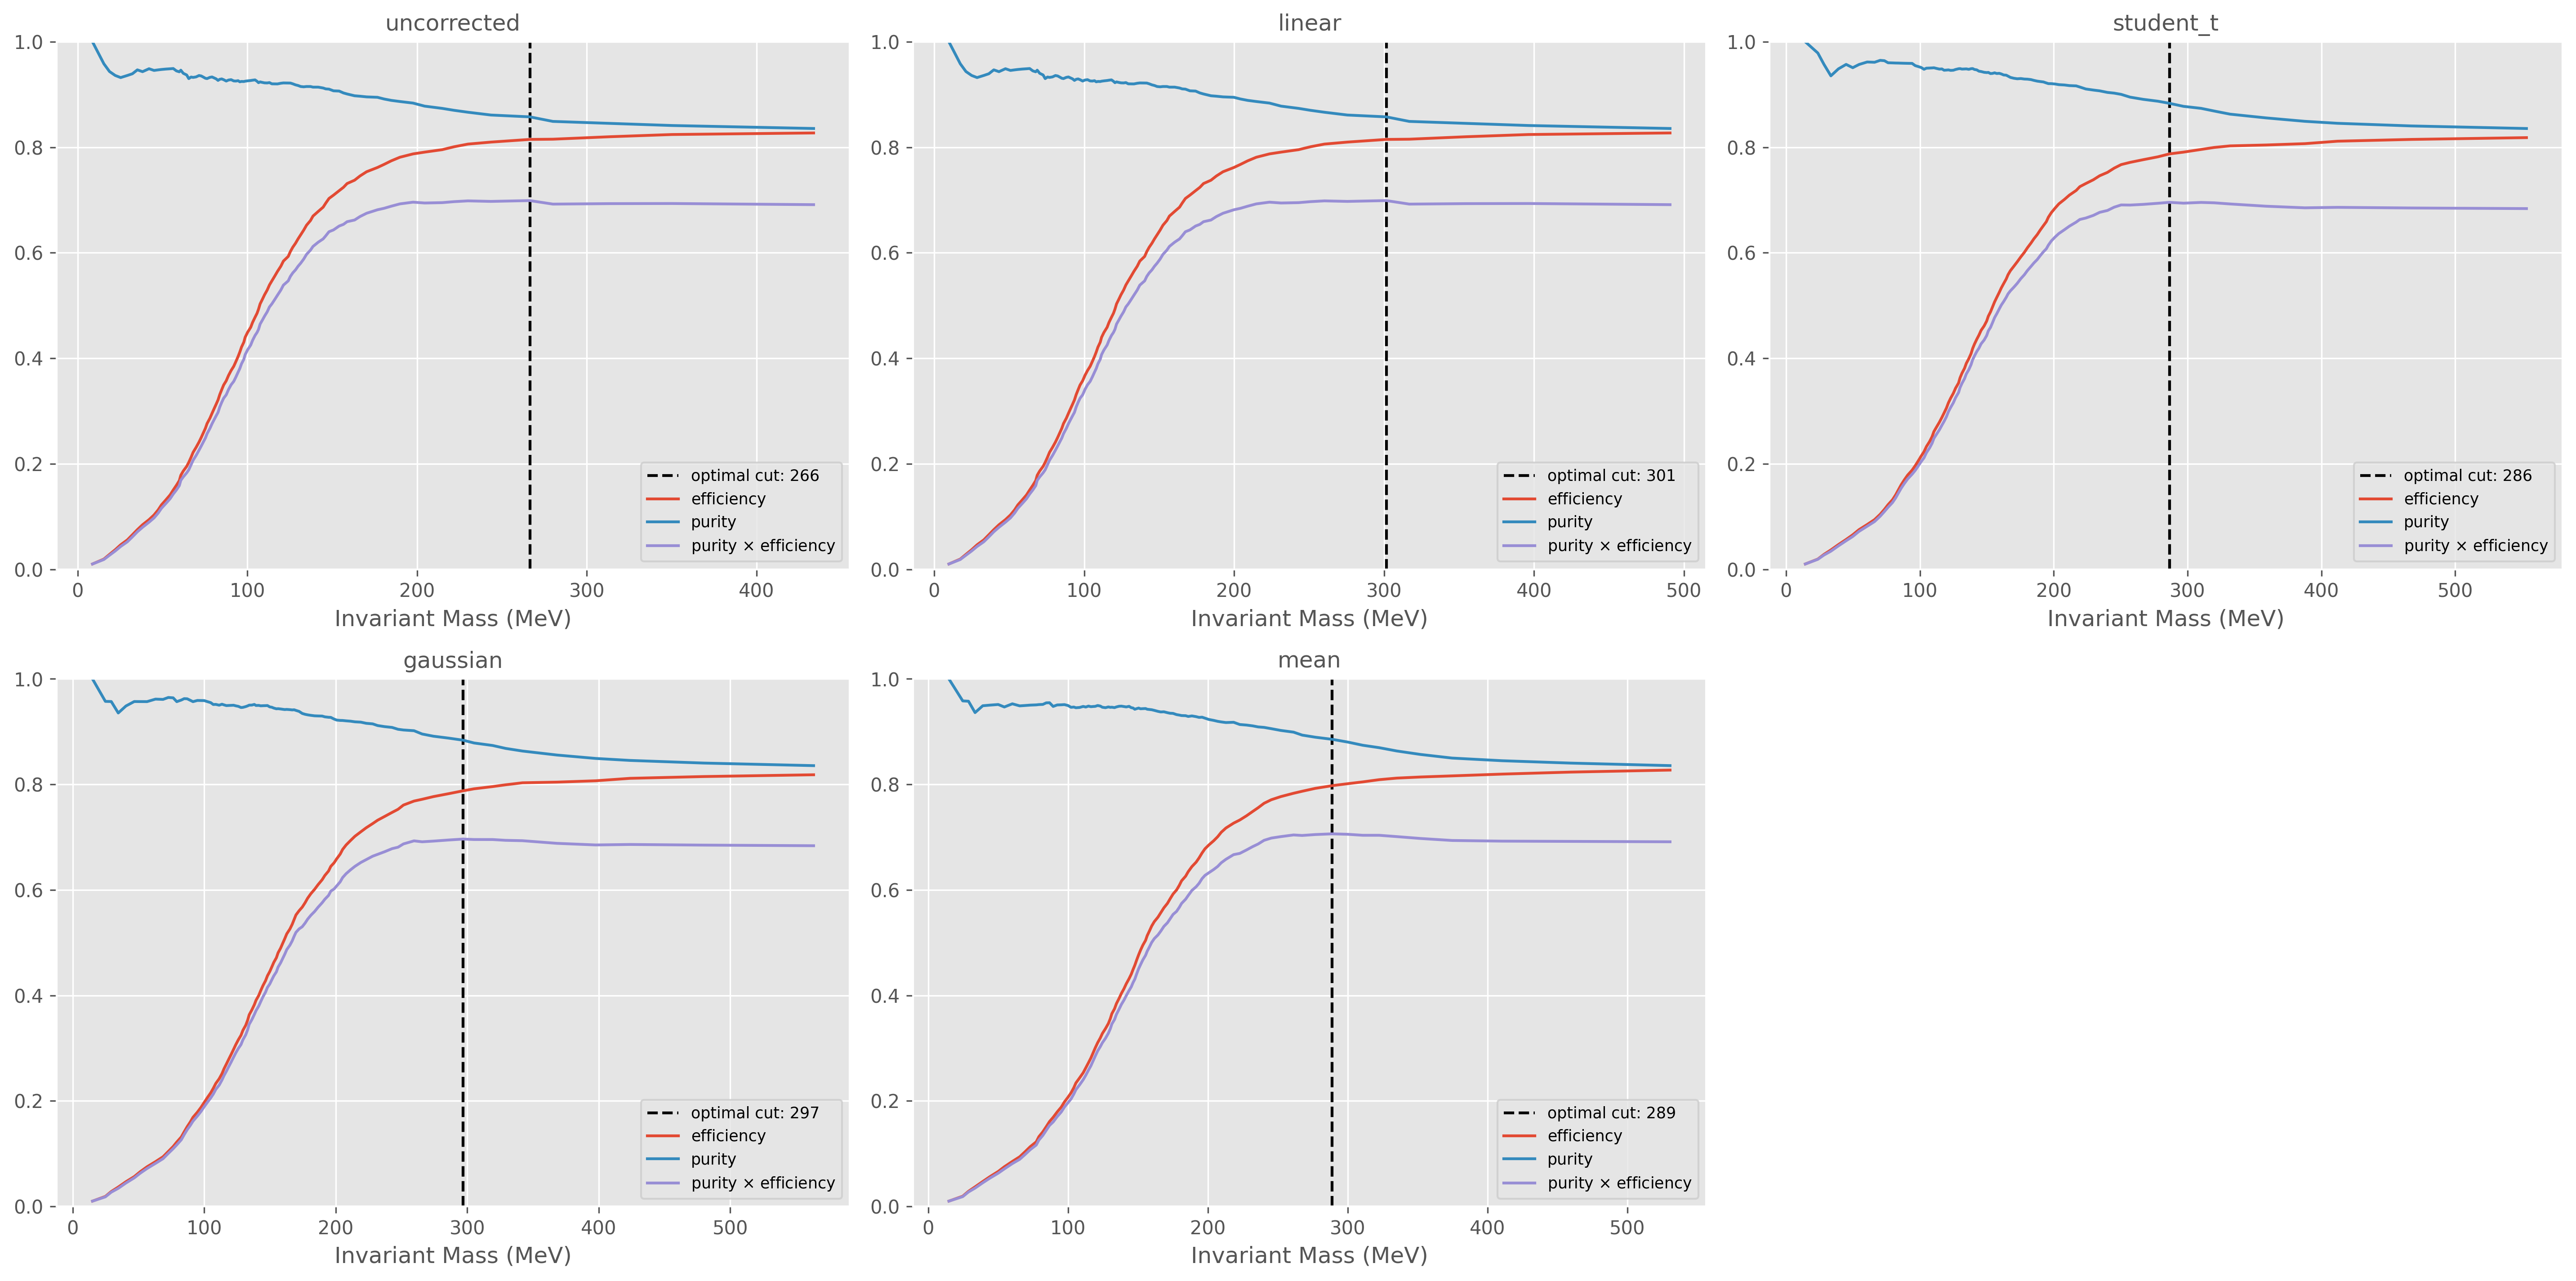

In [53]:
for i, m in Plots.IterMultiPlot(mass):
    optimal_cut(mass[m], pi0_tags.name_simple["pi0s"].mask, True)
    plt.xlabel("Invariant Mass (MeV)")
    plt.title(m)
if save: Plots.Save("optimal_cuts", path)


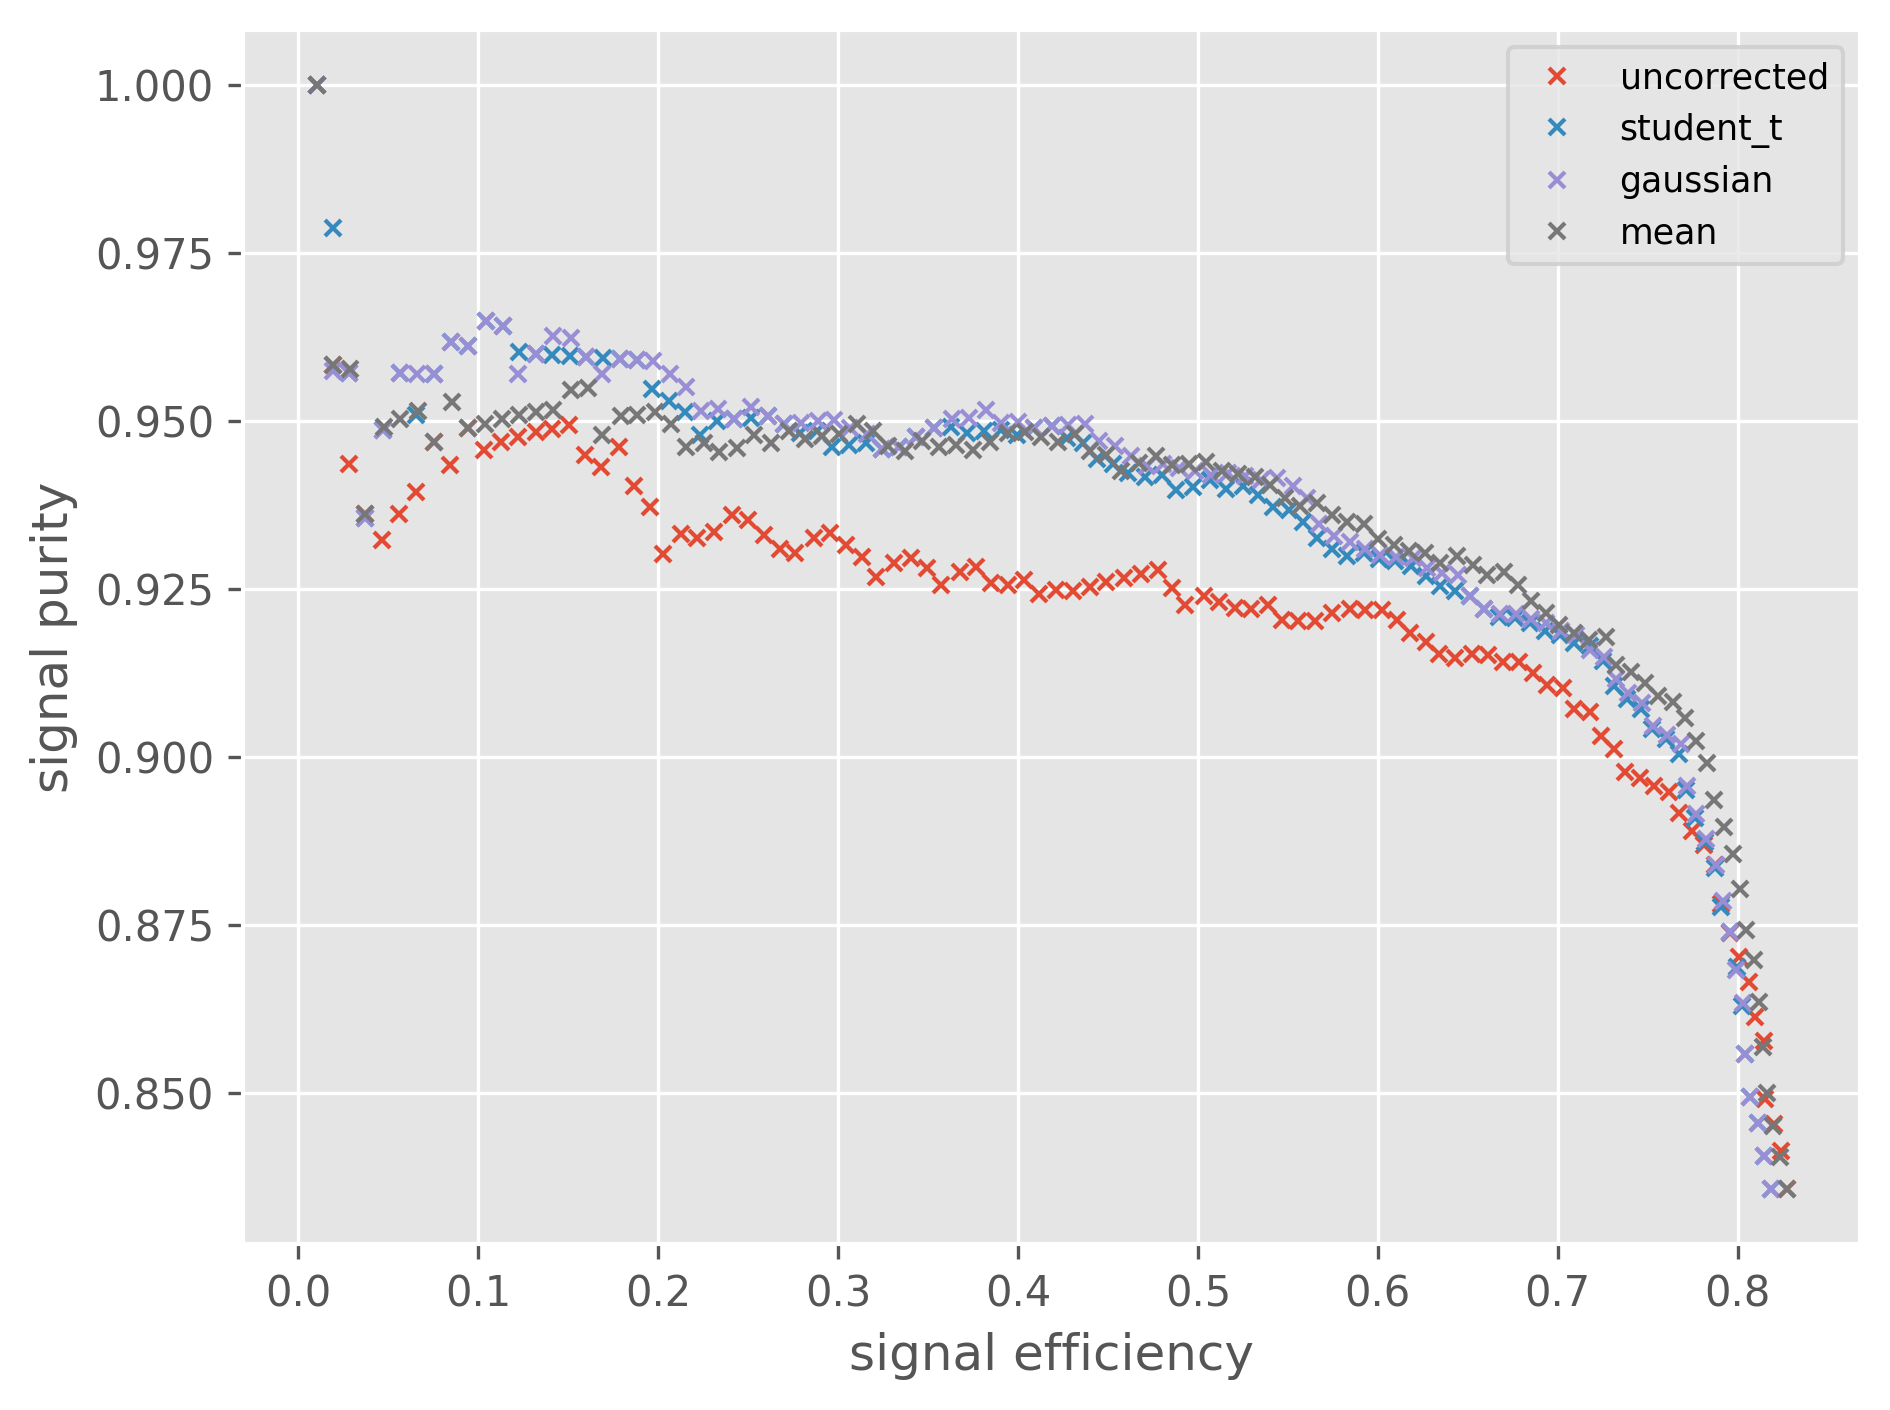

In [40]:
labels = []
efficiencies = []
purities = []

for m in mass:
    if m in ["linear"]: continue
    e, p, _, _, _ = cut_scan(mass[m], pi0_tags.name_simple["pi0s"].mask)
    efficiencies.append(e)
    purities.append(p)
    labels.append(m)

Plots.PlotComparison(efficiencies, purities, marker = "x", labels = labels, xlabel = "signal efficiency", ylabel = "signal purity", markersize = 4, newFigure = False, linestyle="")


1962

2367

0.8288973384030418

1587

1943

0.8167781780751415

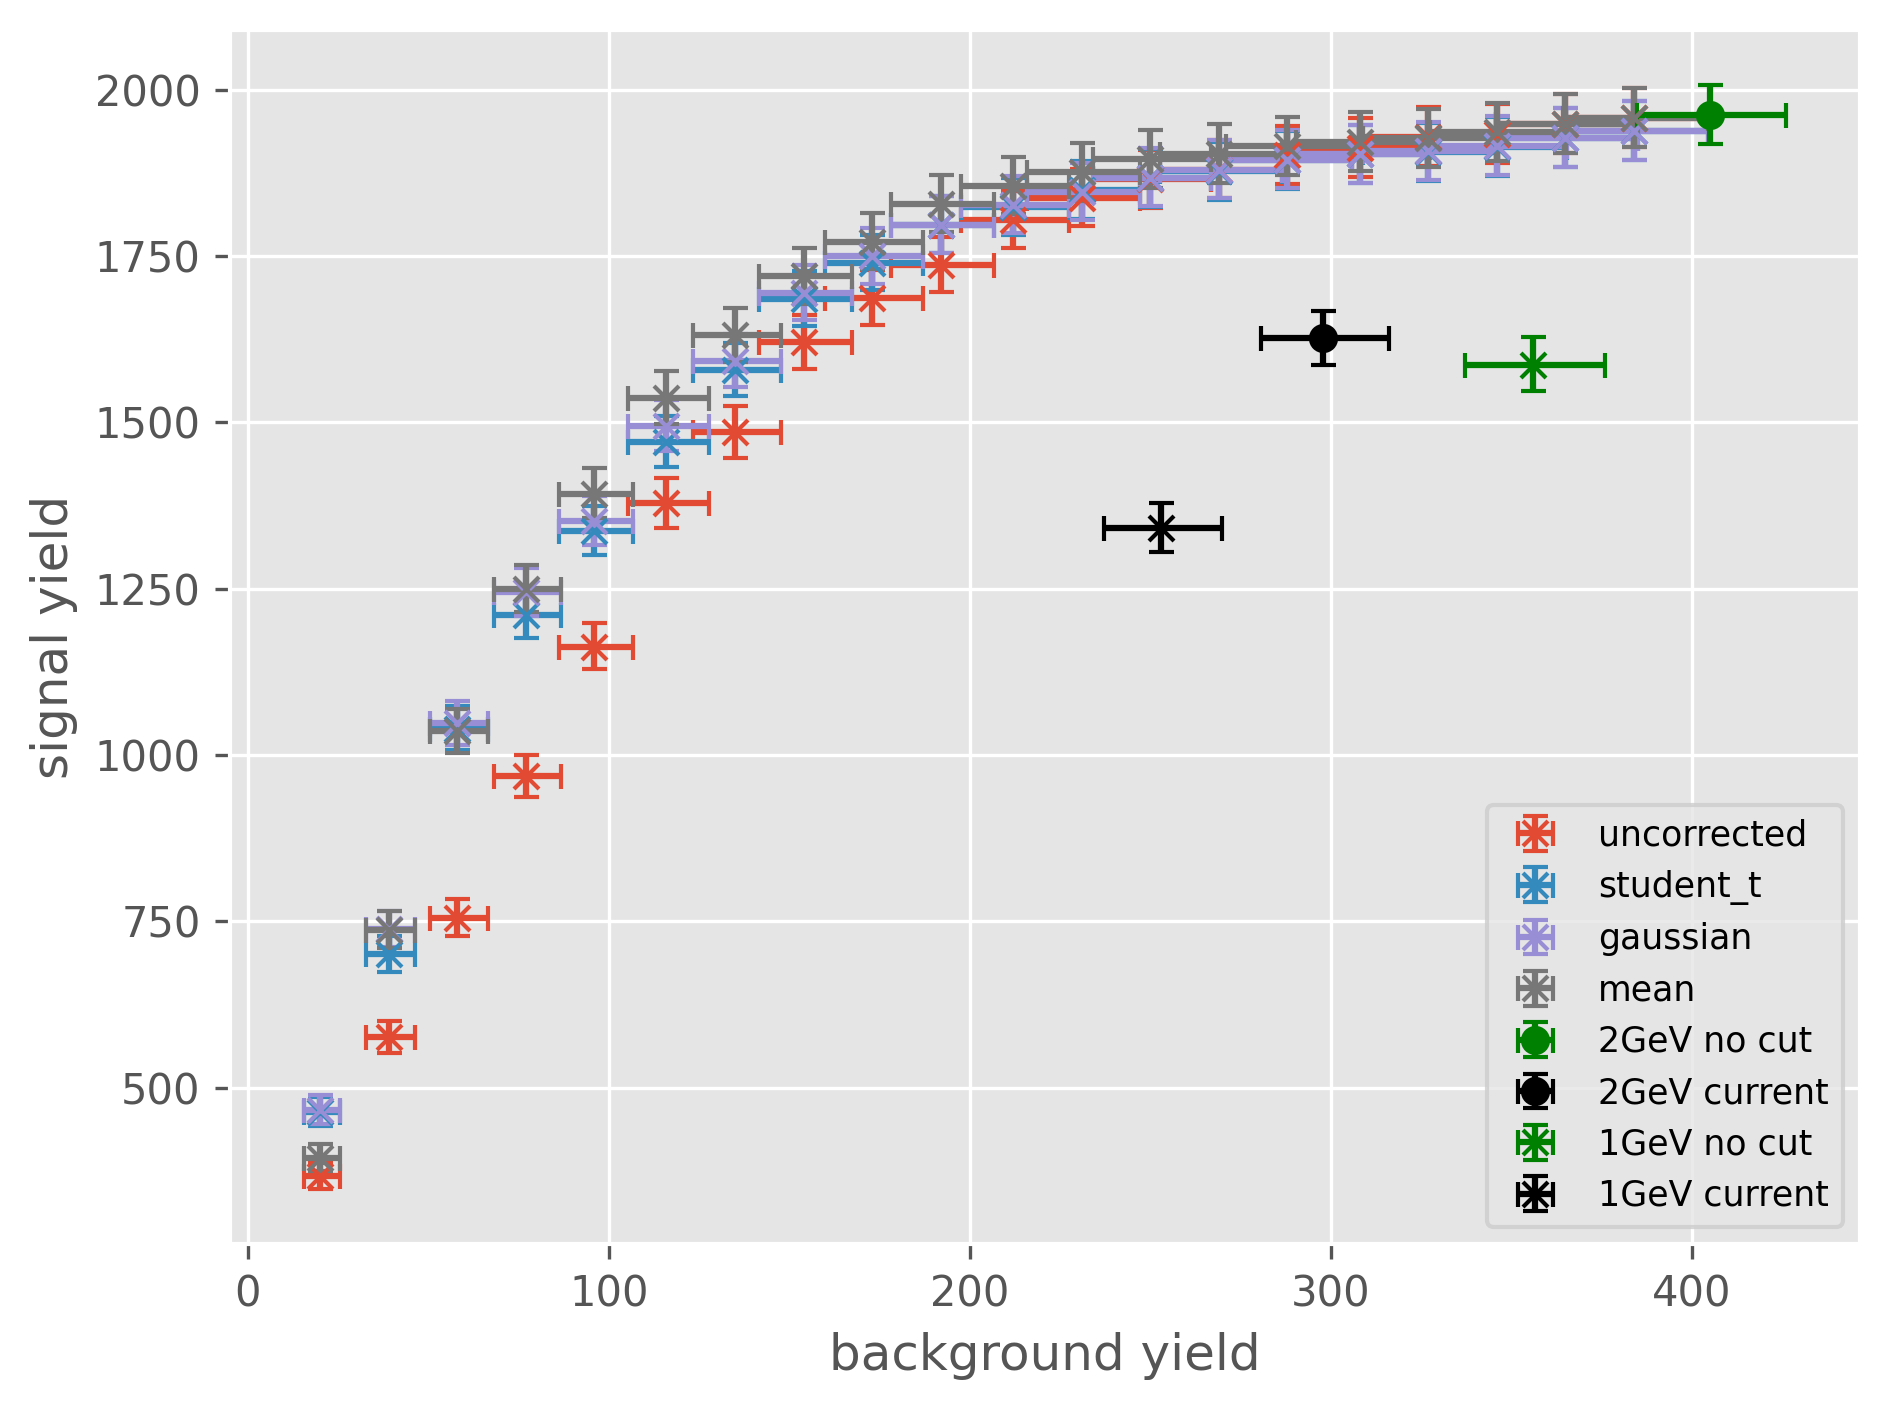

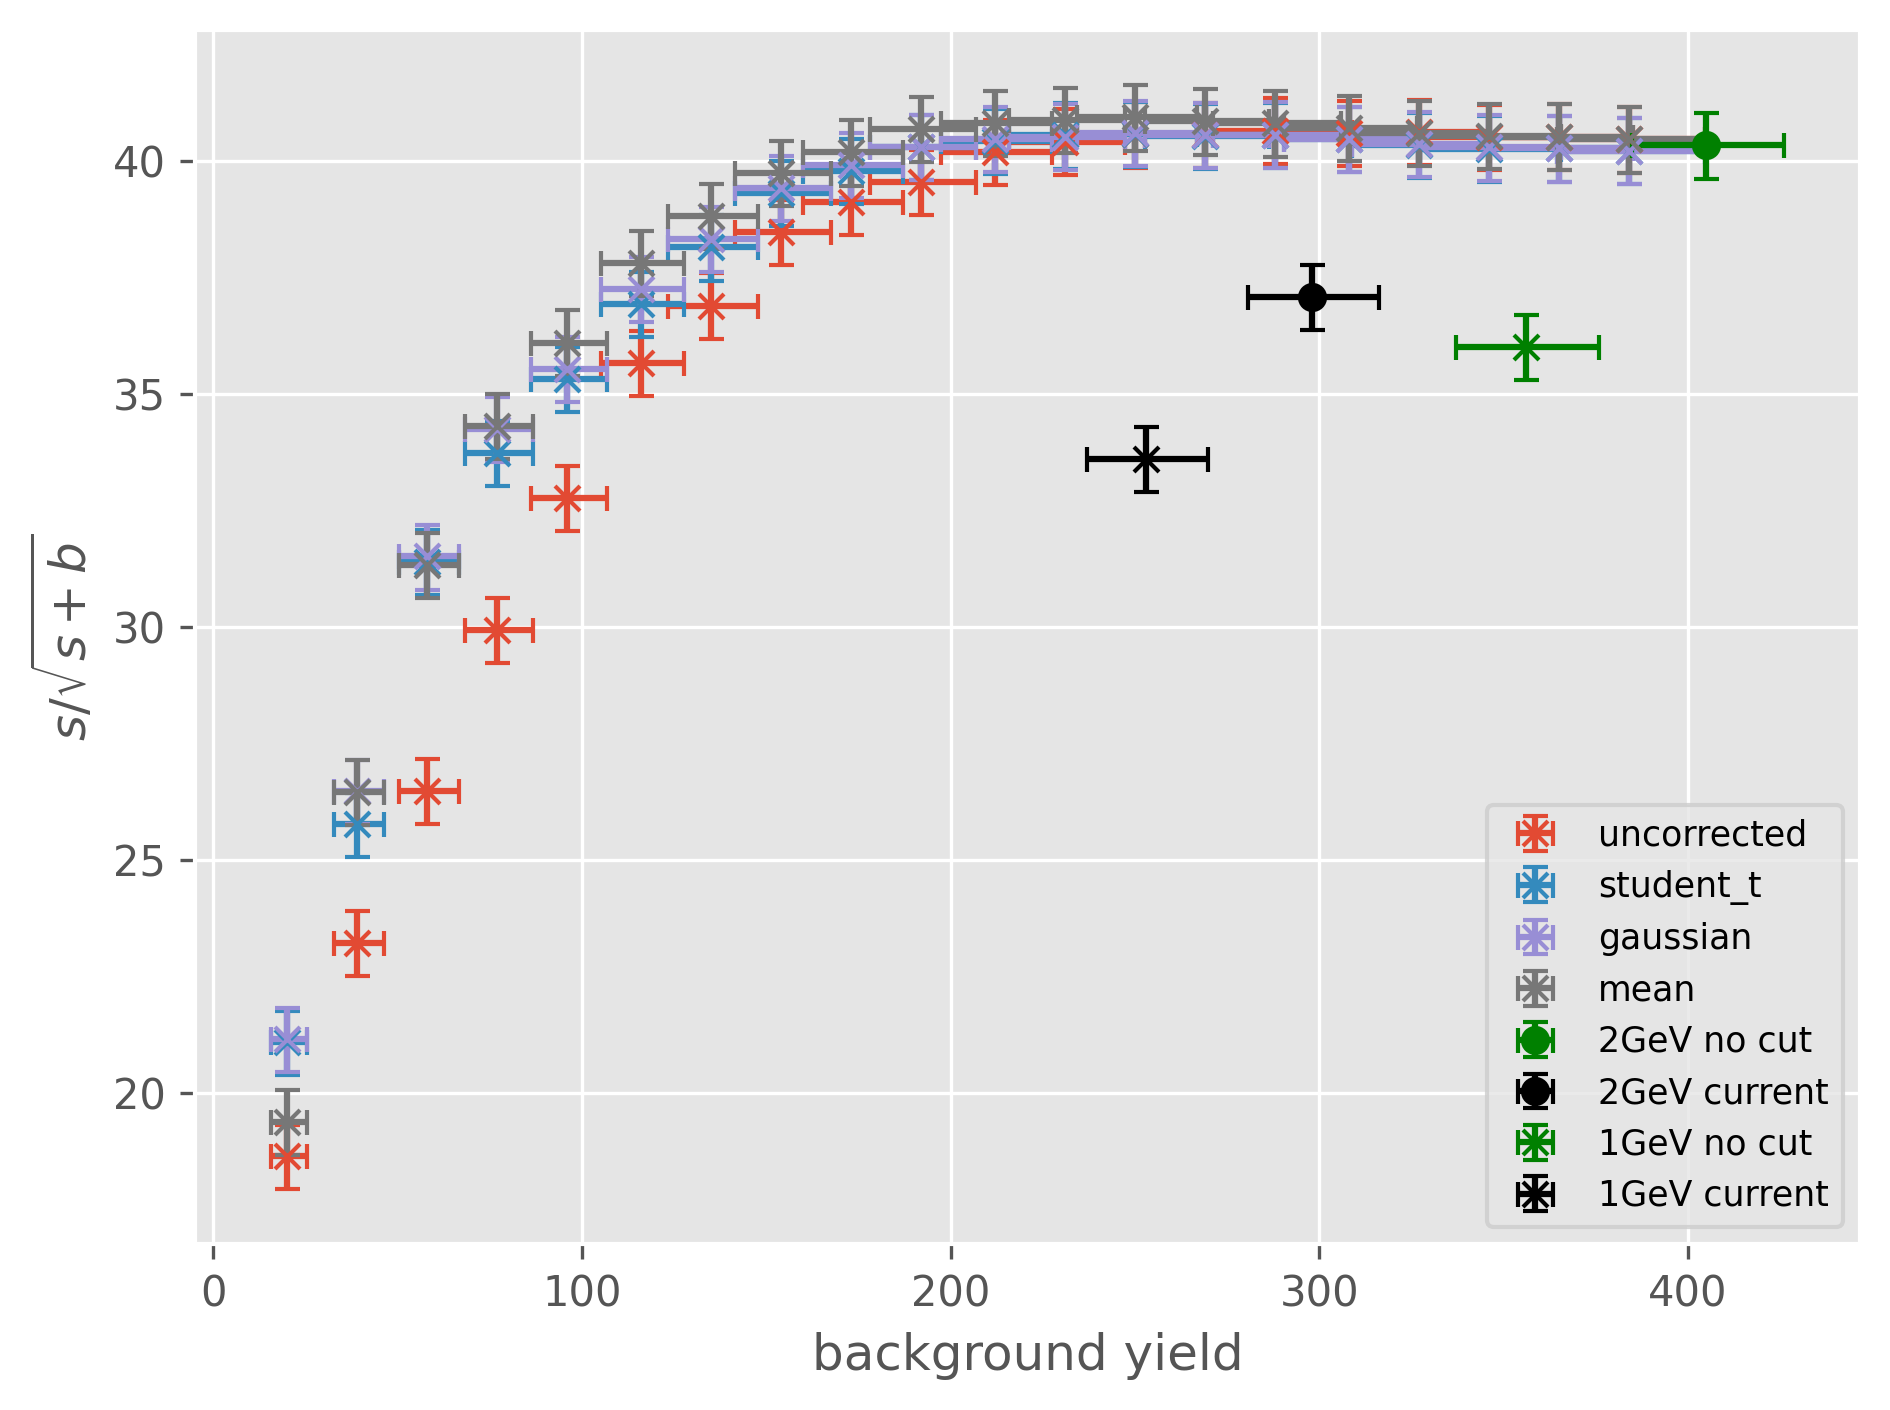

In [55]:
def optimal_cut_yield(value : np.array, signal_mask : np.array) -> tuple:
    """ Metrics to plot optimal cuts, at fixed amounts of background yield.

    Args:
        value (np.array): value to cut
        signal_mask (np.array): signal mask

    Returns:
        tuple: metrics for plots
    """
    n_signal = np.sum(signal_mask)
    n_background = np.sum(~signal_mask)

    sorted_ind = np.argsort(np.array(value))
    sorted_value = np.array(value[sorted_ind])
    sorted_mask = np.array(signal_mask[sorted_ind])

    bkg_yields = np.array(n_background * np.linspace(0.05, 0.95, 20), dtype = int)

    sig_yields = []
    total_yields = []
    cuts = []

    purity = []
    efficiency = []

    for y in bkg_yields:
        cut_value = sorted_value[~sorted_mask][y]
        cuts.append(cut_value)
        sig_yields.append(np.sum(signal_mask[value < cut_value]))
        total_yields.append(len(signal_mask[value < cut_value]))

        purity.append(np.sum(signal_mask[value < cut_value]) / len(signal_mask[value < cut_value]))
        efficiency.append(np.sum(signal_mask[value < cut_value]) / n_signal)

    return np.array(bkg_yields), np.array(sig_yields), np.array(total_yields), np.array(purity), np.array(efficiency), np.array(cuts)


def CorrectionPerformance() -> dict:
    """ Run optimal_cut_yield for each correction.

    Returns:
        dict: metrics
    """
    metrics = {}
    for m in mass:
        by, sy, ty, p, e, cuts = optimal_cut_yield(mass[m], pi0_tags.name_simple["pi0s"].mask)
        metrics[m] = {"background_yield" : by,
         "signal_yield" : sy,
         "total_yield" : ty,
         "purity" : p,
         "efficiency" : e,
         "cuts" : cuts
        }
    return metrics

def binom_error(q : np.array, n : np.array, sigma : float) -> np.array:
    """ Binomial error for stastical uncertainty.

    Args:
        q (np.array): counts
        n (np.array): observations
        sigma (int): confidence interval

    Returns:
        np.array: binomial error
    """
    p = 1 - (stats.norm.cdf(sigma, 0, 1) - stats.norm.cdf(-sigma, 0, 1))
    conf_int = sm.stats.proportion_confint(q, n, p, method = "beta")
    error = abs(q - n * np.array(conf_int))
    return error


def CurrentMassCut(mass : np.array, signak_mask : np.array, ntrials : int, cut : bool = True) -> tuple:
    """ Compute performance for current Invariant mass cut.

    Args:
        mass (np.array): mass
        signak_mask (np.array): signal
        ntrials (int): number of events
        cut (bool, optional): whether to cut data or not before computing metrics. Defaults to True.

    Returns:
        tuple: metrics
    """
    if cut:
        mask = (50 < mass) & (mass < 250)
    else:
        mask = True
    s = np.sum(mask & signak_mask)
    b = np.sum(mask & ~signak_mask)
    s_e = binom_error(s, ntrials, 1)
    b_e = binom_error(b, ntrials, 1)

    return s, b, s_e[:, np.newaxis], b_e[:, np.newaxis]

performance_results = CorrectionPerformance()
trials = 141548
# trials = len(pi0_tags.name_simple["pi0s"].mask)

s_error = {}
b_error = {}
t_error = {}
p_error = {}
ta_error = {}
e_error = {}

for m in mass:
    s_error[m] = binom_error(performance_results[m]["signal_yield"], trials, 1)
    b_error[m] = binom_error(performance_results[m]["background_yield"], trials, 1)

    t_error[m] = binom_error(performance_results[m]["total_yield"], trials, 1)
    p_error[m] = performance_results[m]["purity"] * ((s_error[m]/performance_results[m]["signal_yield"])**2 + (t_error[m]/performance_results[m]["total_yield"])**2)**0.5

    tmp = binom_error(len(pi0_tags.name_simple["pi0s"].mask), trials, 1)
    ta_error[m] =  np.array([[tmp[0]], [tmp[1]]])
    e_error[m] = performance_results[m]["efficiency"] * ((s_error[m]/performance_results[m]["signal_yield"])**2 + (ta_error[m]/len(pi0_tags.name_simple["pi0s"].mask))**2)**0.5

plt.figure()
for m in mass:
    if m in ["linear"]: continue
    Plots.Plot(x = performance_results[m]["background_yield"], y = performance_results[m]["signal_yield"], xerr = b_error[m], yerr = s_error[m], ylabel = "signal yield", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, label = m, newFigure = False)

n2 = CurrentMassCut(mass["uncorrected"], pi0_tags.name_simple["pi0s"].mask, trials, False)
plt.errorbar(n2[1], n2[0], yerr = n2[2], xerr = n2[3], marker = "o", linestyle = "", color = "green", label = "2GeV no cut", capsize = 3)

c2 = CurrentMassCut(mass["uncorrected"], pi0_tags.name_simple["pi0s"].mask, trials)
plt.errorbar(c2[1], c2[0], yerr = c2[2], xerr = c2[3], marker = "o", linestyle = "", color = "black", label = "2GeV current", capsize = 3)

df_1GeV = {
    "pairs" : pd.read_hdf("test/1GeV_shower_energy/photon_energies.hdf5", "photon_pairs"),
    "tags" : UnpackPi0Tags(pd.read_hdf("test/1GeV_shower_energy/photon_energies.hdf5", "tags")),
    "trials" : 298194
}
df_1GeV["mass"] = Master.ShowerPairs.Mass(df_1GeV["pairs"].shower_pairs_reco_lead_energy, df_1GeV["pairs"].shower_pairs_reco_sub_energy, df_1GeV["pairs"].shower_pairs_reco_angle)

print(np.sum(pi0_tags.name_simple["pi0s"].mask))
print(len(pi0_tags.name_simple["pi0s"].mask))
print(np.sum(pi0_tags.name_simple["pi0s"].mask) / len(pi0_tags.name_simple["pi0s"].mask))

print(np.sum(df_1GeV["tags"].name_simple["pi0s"].mask))
print(len(df_1GeV["tags"].name_simple["pi0s"].mask))
print(np.sum(df_1GeV["tags"].name_simple["pi0s"].mask) / len(df_1GeV["tags"].name_simple["pi0s"].mask))

n1 = CurrentMassCut(df_1GeV["mass"], df_1GeV["tags"].name_simple["pi0s"].mask, df_1GeV["trials"], False)
plt.errorbar(n1[1], n1[0], yerr = n1[2], xerr = n1[3], marker = "x", linestyle = "", color = "green", label = "1GeV no cut", capsize = 3)

c1 = CurrentMassCut(df_1GeV["mass"], df_1GeV["tags"].name_simple["pi0s"].mask, df_1GeV["trials"])
plt.errorbar(c1[1], c1[0], yerr = c1[2], xerr = c1[3], marker = "x", linestyle = "", color = "black", label = "1GeV current", capsize = 3)
plt.legend()

def perf_metric(s, b, s_e, b_e):
    p = s / np.sqrt(b + s)
    p_e = ((s_e / s)**2 + 0.5 * (s + b) / (s_e**2 + b_e**2))**0.5
    return p, p_e

plt.figure()
for m in mass:
    if m in ["linear"]: continue
    p, p_e = perf_metric(performance_results[m]["signal_yield"], performance_results[m]["background_yield"], s_error[m], b_error[m])
    # p = performance_results[m]["signal_yield"] / (performance_results[m]["signal_yield"] + performance_results[m]["background_yield"])**0.5
    # p_e = (s_error[m] / performance_results[m]["signal_yield"])**2 + 0.5 * (performance_results[m]["signal_yield"] + performance_results[m]["background_yield"]) / (s_error[m]**2 + b_error[m]**2)
    Plots.Plot(performance_results[m]["background_yield"], p, xerr = b_error[m], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, label = m, newFigure = False)

p, p_e = perf_metric(n2[0], n2[1], n2[2], n2[3])
Plots.Plot(n2[1], p, xerr = n2[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "o", markersize = 6, color = "green", label = "2GeV no cut", newFigure = False)

p, p_e = perf_metric(c2[0], c2[1], c2[2], c2[3])
Plots.Plot(c2[1], p, xerr = c2[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "o", markersize = 6, color = "black", label = "2GeV current", newFigure = False)

p, p_e = perf_metric(n1[0], n1[1], n1[2], n1[3]) 
Plots.Plot(n1[1], p, xerr = n1[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, color = "green", label = "1GeV no cut", newFigure = False)

p, p_e = perf_metric(c1[0], c1[1], c1[2], c1[3]) 
Plots.Plot(c1[1], p, xerr = c1[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, color = "black", label = "1GeV current", newFigure = False)


In [27]:
#! first is total
# no\_selection, 1941, 1585, 201, 125, 30
# angle       , 1540, 1383, 96, 53, 8
# mass        , 1356, 1229, 84, 40, 3
# no\_selection,   2670, 1561, 640, 417, 52
# angle       ,  1953, 1339, 386, 208, 20
# mass        ,  1557, 1176, 232, 136, 13


# Output

In [60]:
import json
params = {p : {f"p{i}" : response_params[p][i] for i in range(len(response_params[p]))} for p in response_params}

for name, p in params.items():
    with open(path + name + ".json", "w") as f:
        json.dump(p, f)
